In [1]:
import sys
sys.path.append("..")

import re
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
from glob import glob
from matplotlib import pyplot as plt
from utils.utils import getHashFromDict, readContentFromFile
from concurrent.futures import ProcessPoolExecutor
plt.rcParams.update({'font.size': 13})

In [2]:
EXPERIMENTS_BASE_PATH = "./experiments"

# **Cross Validation**

In [3]:
crossValidationExperimentsPath = f"{EXPERIMENTS_BASE_PATH}/crossValidation"

In [4]:
# def calculateUtility(experimentId, targetUtilityAlphaList):
#     foldPredictionPathList = glob(f"{crossValidationExperimentsPath}/{experimentId}/**/aucTemp.txt", recursive = True)
#     utilities = []
#     for predictionPath in foldPredictionPathList:
#         fold = re.findall(r".*(fold[0-9]+).*", predictionPath)[0]
#         foldUtilities = []
#         for targetUtilityAlpha in targetUtilityAlphaList:
#             oneMinusTargetUtilityAlpha = 1 - targetUtilityAlpha
#             foldPredictions = readContentFromFile(predictionPath).strip()
#             foldPredictions = pd.DataFrame([
#                 [float(value) for value in instance.split(" ")] for instance in foldPredictions.split("\n")
#             ], columns = ["prob", "label"])
#             foldPredictions["label"] = foldPredictions.label.astype(int)
#             foldPredictions["pmf"] = foldPredictions.apply(lambda row: row.prob if row.label == 1 else (1-row.prob), axis = 1)
#             foldPredictions["alphaFairness"] = foldPredictions.pmf.apply(lambda z: np.log(z) if targetUtilityAlpha == 1 else np.power(z,oneMinusTargetUtilityAlpha)/oneMinusTargetUtilityAlpha)
#             foldUtility = foldPredictions.alphaFairness.mean()
#             foldUtilities.append(foldUtility)
#         utilities.append([experimentId, fold, *foldUtilities])
#     return pd.DataFrame(data = utilities, columns = ["experimentID", "fold", *[f"utility@targetAlpha_{alpha}" for alpha in targetUtilityAlphaList]])

In [5]:
experimentsResults = []
for path in tqdm(glob(f"{crossValidationExperimentsPath}/*")):
    experimentId = os.path.basename(path)
    if len(experimentId) == 64:
        try: 
            with open(f"{crossValidationExperimentsPath}/{experimentId}/setting.json") as f:
                experimentSetting = json.load(f)
            with open(f"{crossValidationExperimentsPath}/{experimentId}/metrics.json") as f:
                experimentMetrics = {"metrics": json.load(f)}
            experimentResult = {
                "id": experimentId,
                **experimentSetting,
                **experimentMetrics
            }
            experimentsResults.append(experimentResult)
        except Exception as e:
            print(f"Error while loading {experimentId} results.")
            print(e)

experimentsResultsDF = pd.DataFrame.from_dict(experimentsResults)

targetDatabaseDF = experimentsResultsDF["targetDatabase"].apply(pd.Series)
targetDatabaseDF.columns = ["targetDomain", "target_targetPredicate", "target_resetTargetPredicate"]
targetDatabaseDF["targetDomain"] = targetDatabaseDF.targetDomain.apply(lambda databasePath: os.path.basename(databasePath))
sourceDatabaseDF = experimentsResultsDF["sourceDatabase"].apply(pd.Series)
sourceDatabaseDF.columns = ["sourceDomain", "source_targetPredicate", "source_resetTargetPredicate"]
sourceDatabaseDF["sourceDomain"] = sourceDatabaseDF.sourceDomain.apply(lambda databasePath: os.path.basename(databasePath))
metricsDF = experimentsResultsDF["metrics"].apply(pd.Series)
metricsDF.columns = ["metrics_transferLearning", "metrics_originalRDNBoost", "metrics_analogousToOriginalRDNBoost"]

experimentsResultsDF = pd.concat([experimentsResultsDF, targetDatabaseDF, sourceDatabaseDF, metricsDF], axis = 1)
experimentsResultsDF = experimentsResultsDF.drop(["targetDatabase", "sourceDatabase", "metrics", "ignoreSTDOUT"], axis = 1)

# experimentsResultsDF["target_targetPredicate"] = experimentsResultsDF.apply(
#     lambda row: re.findall(
#         r"targetPred:\s+(\w.*)/\d+", 
#         readContentFromFile(glob(f"{row.path}/{row.id}/**/train_output.txt", recursive = True)[0])
#     )[0], 
#     axis = 1
# )

print("Total experiments:", experimentsResultsDF.shape[0])

100%|██████████| 3516/3516 [11:28<00:00,  5.11it/s]


Total experiments: 3516


In [6]:
# experimentIdList = experimentsResultsDF.id.unique().tolist()
# with ProcessPoolExecutor(max_workers = 10) as p:
#     results = list(
#         tqdm(
#             p.map(calculateUtility, experimentIdList, [(0.0,0.3,0.6,1.0,1.3) for i in experimentIdList]), 
#             total=len(experimentIdList)
#         )
#     )

# experimentsUtilitiesDF = pd.concat(results, axis = 0).reset_index(drop = True)
# print(experimentsUtilitiesDF.shape)
# experimentsUtilitiesDF.head()

In [7]:
experimentsResultsDF.groupby(["sourceDomain", "targetDomain"])[["id"]].count()

id
sourceDomain  targetDomain      
cora          imdb           502
imdb          cora           502
              uwcse          502
nell_finances nell_sports    502
nell_sports   nell_finances  502
twitter       yeast          502
uwcse         imdb             2
yeast         twitter        502

In [8]:
print("Hyperparameters of RDN-Boost")
for column in ["numberOfClauses", "numberOfCycles", "maxTreeDepth", "nEstimators", "nodeSize", "negPosRatio"]:
    print(f"Unique values for column {column}: {experimentsResultsDF[column].unique()}")

Hyperparameters of RDN-Boost
Unique values for column numberOfClauses: [8]
Unique values for column numberOfCycles: [100]
Unique values for column maxTreeDepth: [3]
Unique values for column nEstimators: [10]
Unique values for column nodeSize: [2]
Unique values for column negPosRatio: [2]


In [9]:
modelDF = experimentsResultsDF[["runTransferLearning", "runOriginalRDNBoost", "runAnalogousToOriginalRDNBoost"]]
modelDF.apply(lambda row: modelDF.columns[row.values == True][0], axis = 1).value_counts()

runTransferLearning               3500
runOriginalRDNBoost                  8
runAnalogousToOriginalRDNBoost       8
dtype: int64

In [10]:
# Experiments Results DataFrame Sample
print("Columns:")
print("=======")
print("\n".join(experimentsResultsDF.columns))
experimentsResultsDF.head(3)

Columns:
id
path
randomSeed
numberOfClauses
numberOfCycles
maxTreeDepth
nEstimators
nodeSize
negPosRatio
maxFailedNegSamplingRetries
useRecursion
runTransferLearning
sourceUtilityAlpha
targetUtilityAlpha
utilityAlphaSetIter
weight
mapping
runOriginalRDNBoost
runAnalogousToOriginalRDNBoost
targetDomain
target_targetPredicate
target_resetTargetPredicate
sourceDomain
source_targetPredicate
source_resetTargetPredicate
metrics_transferLearning
metrics_originalRDNBoost
metrics_analogousToOriginalRDNBoost


id  \
0  0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...   
1  00211469e7d68242b8a5fd2170a8001164382df617e84d...   
2  00479b54d3e9c1a180fbdc3ee8a06a209072013989ed7b...   

                            path  randomSeed  numberOfClauses  numberOfCycles  \
0  ./experiments/crossValidation          11                8             100   
1  ./experiments/crossValidation          11                8             100   
2  ./experiments/crossValidation          11                8             100   

   maxTreeDepth  nEstimators  nodeSize  negPosRatio  \
0             3           10         2            2   
1             3           10         2            2   
2             3           10         2            2   

   maxFailedNegSamplingRetries  ...  runAnalogousToOriginalRDNBoost  \
0                           50  ...                             NaN   
1                           50  ...                             NaN   
2                           50  ...                             NaN   

  targetDomain  target_targetPredicate  target_resetTargetPredicate  \
0  nell_sports                    None                        False   
1      twitter                    None                        False   
2        uwcse                    None                        False   

    sourceDomain source_targetPredicate source_resetTargetPredicate  \
0  nell_finances                   None                       False   
1          yeast                   None                       False   
2           imdb                   None                       False   

                            metrics_transferLearning metrics_originalRDNBoost  \
0  {'fold01': {'threshold': '0.490', 'cll': '-0.1...                      NaN   
1  {'fold01': {'threshold': '0.472', 'cll': '-0.1...                      NaN   
2  {'fold00': {'threshold': '0.476', 'cll': '-0.2...                      NaN   

  metrics_analogousToOriginalRDNBoost  
0                                 NaN  
1                                 NaN  
2                                 NaN  

[3 rows x 28 columns]

In [11]:
# # Checking if Analogous to RDN-Boost has the same performance as the Original RDN-Boost and 
# analogousAndOriginalRDNBoostDF = pd.merge(
#     experimentsResultsDF[experimentsResultsDF.runOriginalRDNBoost == True][["targetDomain", "metrics_originalRDNBoost"]].sort_values("targetDomain").reset_index(drop = True),
#     experimentsResultsDF[experimentsResultsDF.runAnalogousToOriginalRDNBoost == True][["targetDomain", "metrics_analogousToOriginalRDNBoost"]].sort_values("targetDomain").reset_index(drop = True),
#     on = "targetDomain",
#     how = "inner",
# )
# domain = "cora"
# pd.concat(
#     [
#         pd.json_normalize(analogousAndOriginalRDNBoostDF[analogousAndOriginalRDNBoostDF.targetDomain == database].iloc[0]["metrics_originalRDNBoost"]),
#         pd.json_normalize(analogousAndOriginalRDNBoostDF[analogousAndOriginalRDNBoostDF.targetDomain == database].iloc[0]["metrics_analogousToOriginalRDNBoost"]),
#     ],
#     axis = 0
# ).T

# **Original RDN-Boost**

In [12]:
originalRDNBoostDF = experimentsResultsDF[experimentsResultsDF["runOriginalRDNBoost"] == True].copy(deep = True)

originalRDNBoostMetricsDF = originalRDNBoostDF[["id", "metrics_originalRDNBoost"]].copy()
originalRDNBoostMetricsDF.columns = ["experimentID", "metrics"]
originalRDNBoostMetricsDF["metrics"] = originalRDNBoostMetricsDF.metrics.apply(
    lambda metrics: metrics.items()
)
originalRDNBoostMetricsDF = originalRDNBoostMetricsDF.explode("metrics")
originalRDNBoostMetricsDF["fold"] = originalRDNBoostMetricsDF.metrics.apply(lambda metrics: metrics[0])
originalRDNBoostMetricsDF["metrics"] = originalRDNBoostMetricsDF.metrics.apply(lambda metrics: metrics[1])
originalRDNBoostMetricsDF = pd.concat(
    [originalRDNBoostMetricsDF, originalRDNBoostMetricsDF.metrics.apply(pd.Series).astype(float)], 
    axis = 1
)
originalRDNBoostMetricsDF = originalRDNBoostMetricsDF.drop(["metrics"], axis = 1)
originalRDNBoostMetricsDF = originalRDNBoostMetricsDF.sort_values("experimentID")
originalRDNBoostMetricsDF = originalRDNBoostMetricsDF.reset_index(drop = True)
# originalRDNBoostMetricsDF = pd.merge(
#     originalRDNBoostMetricsDF, 
#     experimentsUtilitiesDF, 
#     on = ["experimentID", "fold"], 
#     how = "left"
# )

columnsToKeep = [
    'id', 'targetDomain', 'target_targetPredicate', 'useRecursion', 'path', 'negPosRatio', 'randomSeed', 
    'maxFailedNegSamplingRetries', 'numberOfClauses', 'numberOfCycles', 'maxTreeDepth', 'nEstimators', 'nodeSize'
]
originalRDNBoostDF = originalRDNBoostDF[columnsToKeep].copy(deep = True)

originalRDNBoostDF["aucROC_mean"] = originalRDNBoostDF["id"].apply(
    lambda expID: originalRDNBoostMetricsDF[originalRDNBoostMetricsDF["experimentID"] == expID].aucROC.mean()
)
originalRDNBoostDF["aucROC_std"] = originalRDNBoostDF["id"].apply(
    lambda expID: originalRDNBoostMetricsDF[originalRDNBoostMetricsDF["experimentID"] == expID].aucROC.std()
)
originalRDNBoostDF["aucPR_mean"] = originalRDNBoostDF["id"].apply(
    lambda expID: originalRDNBoostMetricsDF[originalRDNBoostMetricsDF["experimentID"] == expID].aucPR.mean()
)
originalRDNBoostDF["aucPR_std"] = originalRDNBoostDF["id"].apply(
    lambda expID: originalRDNBoostMetricsDF[originalRDNBoostMetricsDF["experimentID"] == expID].aucPR.std()
)

In [13]:
originalRDNBoostDF

id   targetDomain  \
93    0726cac0b41d9aa866dbf57bd36b115ed1c50e11afedc0...    nell_sports   
1124  51d101f2e9cfac1aa4edb1f463accf3f6b5d41f573f52a...           imdb   
1451  6a38ecd1ee6f57493bdc4d5565d196340eefe7466041f7...           imdb   
1457  6a9f022b5fc34609ec98a9898cafb1845f9e40acb61a13...          yeast   
1778  816f88e322ad9332974b410b99743c591cfb2829177084...           cora   
2542  b66e86ba8b85a4ad471123e9d4010515430a0c49c6fa23...        twitter   
2641  bf61e2b7f32e7599b7a4c2e147a01836132f2ca951dcf0...  nell_finances   
2661  c0b61053859b77b0901fecdeaad7db8405a209cd76add3...          uwcse   

     target_targetPredicate  useRecursion                           path  \
93                     None          True  ./experiments/crossValidation   
1124                   None         False  ./experiments/crossValidation   
1451                   None         False  ./experiments/crossValidation   
1457                   None          True  ./experiments/crossValidation   
1778                   None         False  ./experiments/crossValidation   
2542                   None          True  ./experiments/crossValidation   
2641                   None          True  ./experiments/crossValidation   
2661                   None         False  ./experiments/crossValidation   

      negPosRatio  randomSeed  maxFailedNegSamplingRetries  numberOfClauses  \
93              2          11                           50                8   
1124            2          11                           50                8   
1451            2          11                           50                8   
1457            2          11                           50                8   
1778            2          11                           50                8   
2542            2          11                           50                8   
2641            2          11                           50                8   
2661            2          11                           50                8   

      numberOfCycles  maxTreeDepth  nEstimators  nodeSize  aucROC_mean  \
93               100             3           10         2     0.989048   
1124             100             3           10         2     1.000000   
1451             100             3           10         2     1.000000   
1457             100             3           10         2     0.867002   
1778             100             3           10         2     0.646198   
2542             100             3           10         2     0.993062   
2641             100             3           10         2     0.718829   
2661             100             3           10         2     0.921652   

      aucROC_std  aucPR_mean  aucPR_std  
93      0.006170    0.965925   0.026593  
1124    0.000000    1.000000   0.000000  
1451    0.000000    1.000000   0.000000  
1457    0.088602    0.811415   0.109036  
1778    0.146544    0.473191   0.151364  
2542    0.003844    0.982757   0.011079  
2641    0.051323    0.628930   0.070847  
2661    0.040539    0.783410   0.097891

In [14]:
originalRDNBoostDF[["id", "targetDomain"]].set_index("id")

targetDomain
id                                                               
0726cac0b41d9aa866dbf57bd36b115ed1c50e11afedc02...    nell_sports
51d101f2e9cfac1aa4edb1f463accf3f6b5d41f573f52ae...           imdb
6a38ecd1ee6f57493bdc4d5565d196340eefe7466041f7a...           imdb
6a9f022b5fc34609ec98a9898cafb1845f9e40acb61a132...          yeast
816f88e322ad9332974b410b99743c591cfb28291770844...           cora
b66e86ba8b85a4ad471123e9d4010515430a0c49c6fa23f...        twitter
bf61e2b7f32e7599b7a4c2e147a01836132f2ca951dcf02...  nell_finances
c0b61053859b77b0901fecdeaad7db8405a209cd76add3a...          uwcse

In [15]:
def filterOriginalRDNBoostResultsDF(
    targetDomain = None, 
    target_targetPredicate = None,
):
    df = originalRDNBoostDF.copy()

    if targetDomain:
        df = df[df.targetDomain == targetDomain]

    # if target_targetPredicate:
    #     df = df[df.target_targetPredicate == target_targetPredicate]

    return df

In [16]:
originalRDNBoostDF

id   targetDomain  \
93    0726cac0b41d9aa866dbf57bd36b115ed1c50e11afedc0...    nell_sports   
1124  51d101f2e9cfac1aa4edb1f463accf3f6b5d41f573f52a...           imdb   
1451  6a38ecd1ee6f57493bdc4d5565d196340eefe7466041f7...           imdb   
1457  6a9f022b5fc34609ec98a9898cafb1845f9e40acb61a13...          yeast   
1778  816f88e322ad9332974b410b99743c591cfb2829177084...           cora   
2542  b66e86ba8b85a4ad471123e9d4010515430a0c49c6fa23...        twitter   
2641  bf61e2b7f32e7599b7a4c2e147a01836132f2ca951dcf0...  nell_finances   
2661  c0b61053859b77b0901fecdeaad7db8405a209cd76add3...          uwcse   

     target_targetPredicate  useRecursion                           path  \
93                     None          True  ./experiments/crossValidation   
1124                   None         False  ./experiments/crossValidation   
1451                   None         False  ./experiments/crossValidation   
1457                   None          True  ./experiments/crossValidation   
1778                   None         False  ./experiments/crossValidation   
2542                   None          True  ./experiments/crossValidation   
2641                   None          True  ./experiments/crossValidation   
2661                   None         False  ./experiments/crossValidation   

      negPosRatio  randomSeed  maxFailedNegSamplingRetries  numberOfClauses  \
93              2          11                           50                8   
1124            2          11                           50                8   
1451            2          11                           50                8   
1457            2          11                           50                8   
1778            2          11                           50                8   
2542            2          11                           50                8   
2641            2          11                           50                8   
2661            2          11                           50                8   

      numberOfCycles  maxTreeDepth  nEstimators  nodeSize  aucROC_mean  \
93               100             3           10         2     0.989048   
1124             100             3           10         2     1.000000   
1451             100             3           10         2     1.000000   
1457             100             3           10         2     0.867002   
1778             100             3           10         2     0.646198   
2542             100             3           10         2     0.993062   
2641             100             3           10         2     0.718829   
2661             100             3           10         2     0.921652   

      aucROC_std  aucPR_mean  aucPR_std  
93      0.006170    0.965925   0.026593  
1124    0.000000    1.000000   0.000000  
1451    0.000000    1.000000   0.000000  
1457    0.088602    0.811415   0.109036  
1778    0.146544    0.473191   0.151364  
2542    0.003844    0.982757   0.011079  
2641    0.051323    0.628930   0.070847  
2661    0.040539    0.783410   0.097891

# **Instance-based Transfer Learning (Our Approach)**

In [17]:
transferLearningDF = experimentsResultsDF[experimentsResultsDF["runTransferLearning"] == True].copy(deep = True)
transferLearningDF["mappingID"] = transferLearningDF.mapping.apply(lambda mapping: getHashFromDict(mapping))
transferLearningDF["weightID"] = transferLearningDF.weight.apply(lambda weight: getHashFromDict(weight))

transferLearningMappingsDF = transferLearningDF["mapping"].apply(pd.Series)
transferLearningMappingsDF = pd.concat([transferLearningDF[["mappingID"]], transferLearningMappingsDF], axis = 1)
transferLearningMappingsDF = transferLearningMappingsDF.drop_duplicates(subset = ["mappingID"])
transferLearningMappingsDF = transferLearningMappingsDF.reset_index(drop = True)
transferLearningMappingsDF["mappingShortID"] = [f"M{id+1:03d}" for id in transferLearningMappingsDF.index]
# NOTE: the mappingShortID may change when new experiments are carried out. Always be sure that the plots related to mappings are updated.

transferLearningWeightDF = transferLearningDF["weight"].apply(pd.Series)
transferLearningWeightDF = pd.concat([transferLearningDF[["weightID"]], transferLearningWeightDF], axis = 1)
transferLearningWeightDF = transferLearningWeightDF.drop_duplicates(subset = ["weightID"])
transferLearningWeightDF = transferLearningWeightDF.reset_index(drop = True)
transferLearningWeightDF["weightShortID"] = [f"W{id+1:03d}" for id in transferLearningWeightDF.index]
# NOTE: the mappingShortID may change when new experiments are carried out. Always be sure that the plots related to mappings are updated.

transferLearningMetricsDF = transferLearningDF[["id", "metrics_transferLearning"]].copy()
transferLearningMetricsDF.columns = ["experimentID", "metrics"]
transferLearningMetricsDF["metrics"] = transferLearningMetricsDF.metrics.apply(
    lambda metrics: metrics.items()
)
transferLearningMetricsDF = transferLearningMetricsDF.explode("metrics")
transferLearningMetricsDF["fold"] = transferLearningMetricsDF.metrics.apply(lambda metrics: metrics[0])
transferLearningMetricsDF["metrics"] = transferLearningMetricsDF.metrics.apply(lambda metrics: metrics[1])
transferLearningMetricsDF = pd.concat(
    [transferLearningMetricsDF, transferLearningMetricsDF.metrics.apply(pd.Series).astype(float)], 
    axis = 1
)
transferLearningMetricsDF = transferLearningMetricsDF.drop(["metrics"], axis = 1)
transferLearningMetricsDF = transferLearningMetricsDF.sort_values("experimentID")
transferLearningMetricsDF = transferLearningMetricsDF.reset_index(drop = True)
# transferLearningMetricsDF = pd.merge(
#     transferLearningMetricsDF, 
#     experimentsUtilitiesDF, 
#     on = ["experimentID", "fold"], 
#     how = "left"
# )

columnsToKeep = [
    'id', 'sourceDomain', 'targetDomain', 'target_targetPredicate', 'sourceUtilityAlpha', 'targetUtilityAlpha',  
    'utilityAlphaSetIter', 'mappingID', 'weightID', 'useRecursion', 'path', 'negPosRatio', 'randomSeed', 
    'maxFailedNegSamplingRetries', 'numberOfClauses', 'numberOfCycles', 'maxTreeDepth', 'nEstimators', 'nodeSize'
]
transferLearningDF = transferLearningDF[columnsToKeep].copy(deep = True)

transferLearningDF = pd.merge(
    transferLearningDF, 
    transferLearningMappingsDF[["mappingID", "mappingShortID"]], 
    on = "mappingID", 
    how = "left"
)

transferLearningDF = pd.merge(
    transferLearningDF, 
    transferLearningWeightDF[["weightID", "weightShortID"]], 
    on = "weightID", 
    how = "left"
)

transferLearningDF["aucROC_mean"] = transferLearningDF["id"].apply(
    lambda expID: transferLearningMetricsDF[transferLearningMetricsDF["experimentID"] == expID].aucROC.mean()
)
transferLearningDF["aucROC_std"] = transferLearningDF["id"].apply(
    lambda expID: transferLearningMetricsDF[transferLearningMetricsDF["experimentID"] == expID].aucROC.std()
)
transferLearningDF["aucPR_mean"] = transferLearningDF["id"].apply(
    lambda expID: transferLearningMetricsDF[transferLearningMetricsDF["experimentID"] == expID].aucPR.mean()
)
transferLearningDF["aucPR_std"] = transferLearningDF["id"].apply(
    lambda expID: transferLearningMetricsDF[transferLearningMetricsDF["experimentID"] == expID].aucPR.std()
)

In [18]:
print(transferLearningDF.shape)
transferLearningDF.head(3)

(3500, 25)


id   sourceDomain  \
0  0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...  nell_finances   
1  00211469e7d68242b8a5fd2170a8001164382df617e84d...          yeast   
2  00479b54d3e9c1a180fbdc3ee8a06a209072013989ed7b...           imdb   

  targetDomain target_targetPredicate  sourceUtilityAlpha  targetUtilityAlpha  \
0  nell_sports                   None                 0.3                 1.0   
1      twitter                   None                 1.3                 0.0   
2        uwcse                   None                 1.0                 1.0   

   utilityAlphaSetIter                                          mappingID  \
0                  3.0  77d1b001c655f10d6af95f3425c9f67c79008674133a3b...   
1                  5.0  afe4407960a1617c8a6b385a75d1aeb5c73f3e177c95fe...   
2                  3.0  1ffdbc8a031887b5269deb3e32673c646b3a72c585e7e0...   

                                            weightID  useRecursion  ...  \
0  d42b44f4c3a4e5502499c32e1bc8e995921ae19dad0d01...          True  ...   
1  d42b44f4c3a4e5502499c32e1bc8e995921ae19dad0d01...          True  ...   
2  d42b44f4c3a4e5502499c32e1bc8e995921ae19dad0d01...         False  ...   

  numberOfCycles  maxTreeDepth  nEstimators  nodeSize  mappingShortID  \
0            100             3           10         2            M001   
1            100             3           10         2            M002   
2            100             3           10         2            M003   

   weightShortID  aucROC_mean  aucROC_std  aucPR_mean aucPR_std  
0           W001     0.991085    0.005759    0.977933  0.020142  
1           W001     0.992087    0.002684    0.976052  0.014832  
2           W001     0.925333    0.020834    0.794794  0.055202  

[3 rows x 25 columns]

In [19]:
# # TODO: I can remove this cell because it is just to compare the models by visual inspection.
# columns = ["sourceDomain", "targetDomain", "sourceUtilityAlpha", "targetUtilityAlpha", "utilityAlphaSetIter", "aucROC_mean", "aucROC_std", "aucPR_mean", "aucPR_std", "mappingID"]
# transferLearningDF.sort_values(["mappingID", "utilityAlphaSetIter", "sourceUtilityAlpha", "targetUtilityAlpha"])[columns]

In [20]:
print(transferLearningMappingsDF.shape)
transferLearningMappingsDF.head(3)

(35, 4)


mappingID  \
0  77d1b001c655f10d6af95f3425c9f67c79008674133a3b...   
1  afe4407960a1617c8a6b385a75d1aeb5c73f3e177c95fe...   
2  1ffdbc8a031887b5269deb3e32673c646b3a72c585e7e0...   

                                     relationMapping  \
0  {'bankbankincountry': 'teamplayssport', 'recur...   
1  {'enzyme': 'accounttype', 'recursion_enzyme': ...   
2  {'workedunder': 'advisedby', 'female': None, '...   

                                     termTypeMapping mappingShortID  
0  {'person': 'sportsteam', 'country': 'sport', '...           M001  
1  {'protein': 'account', 'enz': 'type', 'fun': '...           M002  
2  {'person': 'person', 'movie': 'person', 'genre...           M003

In [21]:
print(transferLearningMetricsDF.shape)
transferLearningMetricsDF.head(3)

(13500, 9)


experimentID    fold  threshold  \
0  0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...  fold01      0.490   
1  0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...  fold02      0.489   
2  0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...  fold00      0.454   

        cll    aucROC     aucPR   prec       rec        f1  
0 -0.180192  0.984483  0.955207  0.490  0.988506  0.960894  
1 -0.161034  0.993700  0.985012  0.489  0.984791  0.971857  
2 -0.167207  0.995072  0.993580  0.454  0.984733  0.980989

In [22]:
print(transferLearningWeightDF.shape)
transferLearningWeightDF.head(3)

(1, 4)


weightID strategy     parameters  \
0  d42b44f4c3a4e5502499c32e1bc8e995921ae19dad0d01...   scalar  {'weight': 1}   

  weightShortID  
0          W001

In [23]:
def filterTransferLearningResultsDF(
    sourceDomain = None, 
    targetDomain = None, 
    target_targetPredicate = None,
    mappingID = None,
    weightID = None
):
    df = transferLearningDF.copy()

    if sourceDomain:
        df = df[df.sourceDomain == sourceDomain]

    if targetDomain:
        df = df[df.targetDomain == targetDomain]

    # if target_targetPredicate:
    #     df = df[df.target_targetPredicate == target_targetPredicate]

    if mappingID:
        df = df[df.mappingID == mappingID]

    if weightID:
        df = df[df.weightID == weightID]

    return df

In [24]:
def plotPredictedPredictions(experimentId, title = "Predicted Probabilities"):
    foldPredictionPathList = glob(f"{crossValidationExperimentsPath}/{experimentId}/**/aucTemp.txt", recursive = True)
    predictions = []
    for predictionPath in foldPredictionPathList:
        foldPredictions = readContentFromFile(predictionPath).strip()
        predictions += [
            [float(value) for value in instance.split(" ")] for instance in foldPredictions.split("\n")
        ]
    predictionsDF = pd.DataFrame(predictions, columns = ["predictedProbability", "instanceLabel"])
    predictionsDF["instanceLabel"] = predictionsDF.instanceLabel.astype(int)
    fig = sns.histplot(data = predictionsDF, x = "predictedProbability", hue = "instanceLabel", stat = "proportion", bins = 30)
    _ = plt.xticks([i/10 for i in range(11)])
    plt.ylim([0,0.5])
    plt.title(title)
    plt.show()

In [25]:
def printMappings(mappingShortIDList):
    mappingsDF = transferLearningMappingsDF[
        transferLearningMappingsDF.mappingShortID.isin(mappingShortIDList)
    ].drop("mappingID", axis = 1)
    for idx, row in mappingsDF.iterrows():
        relationMappings = pd.Series(row.relationMapping).reset_index().fillna("empty")
        relationMappings = relationMappings.groupby(0).agg({"index": lambda x: tuple(x)}).reset_index()
        relationMappings["index"] = relationMappings['index'].apply(lambda idx: idx[0] if len(idx) == 1 else idx)
        relationMappings = relationMappings.set_index("index")[0]

        termTypeMappings = pd.Series(row.termTypeMapping).reset_index().fillna("empty")
        termTypeMappings = termTypeMappings.groupby(0).agg({"index": lambda x: tuple(x)}).reset_index()
        termTypeMappings["index"] = termTypeMappings['index'].apply(lambda idx: idx[0] if len(idx) == 1 else idx)
        termTypeMappings = termTypeMappings.set_index("index")[0]

        print(f"Mapping Short ID: {row.mappingShortID}")

        print("\nRelation Mappings:")
        for sourceRelations, targetRelation in relationMappings.items():
            print(f"\t{sourceRelations} -> {targetRelation}")

        print("\nTerm Type Mappings:")
        for sourceTypes, targetType in termTypeMappings.items():
            print(f"\t{sourceTypes} -> {targetType}")
        print()
        print("="*70)
        print()

In [26]:
def describeTransferExperiment(transferExperimentDict): 
    sourceUtilityAlpha = transferExperimentDict.sourceUtilityAlpha
    targetUtilityAlpha = transferExperimentDict.targetUtilityAlpha
    utilityAlphaSetIter = transferExperimentDict.utilityAlphaSetIter
    mapping = transferLearningMappingsDF[transferLearningMappingsDF.mappingID == transferExperimentDict.mappingID].iloc[0]
    aucROC = f"{transferExperimentDict.aucROC_mean} +- {transferExperimentDict.aucROC_std}"
    aucPR = f"{transferExperimentDict.aucPR_mean} +- {transferExperimentDict.aucPR_std}"

    print(f"Experiment ID: {transferExperimentDict.id}")
    print(f"Source utility alpha: {sourceUtilityAlpha}")
    print(f"Target utility alpha: {targetUtilityAlpha}")
    print(f"Utility alpha set iteration: {utilityAlphaSetIter}")
    print(f"Mapping Short ID: {mapping.mappingShortID}")
    print(f"Relation mapping: {mapping.relationMapping}")
    print(f"Term type mapping: {mapping.termTypeMapping}")

    # Paired T-Test (Transfer Experiment vs Learning From Scratch With RDN-B)
    originalRDNBoostExperimentDict = originalRDNBoostDF[originalRDNBoostDF.targetDomain == transferExperimentDict.targetDomain].iloc[0]
    
    transferExperimentFoldMetrics = transferLearningMetricsDF[transferLearningMetricsDF.experimentID == transferExperimentDict.id].sort_values("fold")
    originalRDNBoostFoldMetrics = originalRDNBoostMetricsDF[originalRDNBoostMetricsDF.experimentID == originalRDNBoostExperimentDict.id].sort_values("fold")

    print(f"AUC-ROC: {aucROC} {transferExperimentFoldMetrics['aucROC'].tolist()}")
    print(f"AUC-PR: {aucPR} {transferExperimentFoldMetrics['aucPR'].tolist()}")

    aucROC_ttest = stats.ttest_rel(transferExperimentFoldMetrics["aucROC"], originalRDNBoostFoldMetrics["aucROC"])
    aucPR_ttest = stats.ttest_rel(transferExperimentFoldMetrics["aucPR"], originalRDNBoostFoldMetrics["aucPR"])
    significance = 0.05
    print(f"Paired T-Test between this transfer model and original RDN-Boost (Alpha = {significance}):")
    print(f"---- AUC-ROC: {'Difference is significant' if aucROC_ttest.pvalue <= significance else 'Difference is NOT significant'}, {aucROC_ttest.pvalue} (p-value), {aucROC_ttest.statistic} (statistic)")
    print(f"---- AUC-PR: {'Difference is significant' if aucPR_ttest.pvalue <= significance else 'Difference is NOT significant'}, {aucPR_ttest.pvalue} (p-value), {aucPR_ttest.statistic} (statistic)")

    print("\n")

In [27]:
def plotRadar(transferExperimentDict):
    # Best AUC-PR
    dataCombination_utility = transferExperimentDict.sort_values(["mappingShortID", "aucPR_mean"], ascending = True)

    dataCombination_utility_best = dataCombination_utility.drop_duplicates(
        subset = ["mappingID"], keep = "last"
    ).sort_values("mappingShortID")

    dataCombination_utility_worst = dataCombination_utility.drop_duplicates(
        subset = ["mappingID"], keep = "first"
    ).sort_values("mappingShortID")

    dataCombination_noUtility = transferExperimentDict[
        (transferExperimentDict.utilityAlphaSetIter == 1) &
        (transferExperimentDict.sourceUtilityAlpha == 1) &
        (transferExperimentDict.targetUtilityAlpha == 1)
    ].sort_values("mappingShortID")

    targetDomain = transferExperimentDict.targetDomain.unique()[0]

    targetDomainOriginalRDNBoost = originalRDNBoostDF[originalRDNBoostDF.targetDomain == targetDomain].iloc[0]

    categories = dataCombination_noUtility.mappingShortID.tolist()
    categories += [categories[0]]

    fig = make_subplots(
        rows=1, cols=2, subplot_titles=('AUC-ROC', 'AUC-PR'),
        specs=[[{'type': 'polar'}, {'type': 'polar'}]]
    )

    subplots = [(1, 1, "ROC"), (1, 2, "PR")]

    colors = px.colors.qualitative.Vivid

    for i, params in enumerate(subplots):
        row, col, prOrROC = params
        metric = f"auc{prOrROC.upper()}_mean" 

        combinationAndUtility_best = dataCombination_utility_best[metric].tolist()
        combinationAndUtility_worst = dataCombination_utility_worst[metric].tolist()
        onlyInstancesCombination = dataCombination_noUtility[metric].tolist()

        combinationAndUtility_best += combinationAndUtility_best[:1]
        combinationAndUtility_worst += combinationAndUtility_worst[:1]
        onlyInstancesCombination += onlyInstancesCombination[:1]
        learningFromScratchRDNBoost = [targetDomainOriginalRDNBoost[metric] for i in range(len(onlyInstancesCombination))]

        fig.add_trace(go.Scatterpolar(
            r=combinationAndUtility_best,
            theta=categories,
            fill=None,
            name='UTIL-BRDN(B)',
            line_color=colors[5],
            showlegend = i == 0
        ), row = row, col = col)

        fig.add_trace(go.Scatterpolar(
            r=combinationAndUtility_worst,
            theta=categories,
            fill=None,
            name='UTIL-BRDN(W)',
            line_color=colors[9],
            showlegend = i == 0  
        ), row = row, col = col)

        fig.add_trace(go.Scatterpolar(
            r=onlyInstancesCombination,
            theta=categories,
            fill=None,
            name='UTIL-BRDN*',
            line_color=colors[7],
            showlegend = i == 0 
        ), row = row, col = col)

        fig.add_trace(go.Scatterpolar(
            r=learningFromScratchRDNBoost,
            theta=categories,
            fill=None,
            name='RDN-B',
            line=dict(color=colors[0], dash='dash'),
            showlegend = i == 0 
        ), row = row, col = col)

        fig.update_polars(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            ),
        )

        fig.update_layout(
            showlegend=True,
            legend=dict(
                x=1,
                y=1,
                traceorder='normal',
                orientation='v'
            )
        )

    fig.show()

In [28]:
def runAnalysis(sourceDomain: str, targetDomain: str, target_targetPredicate: str = None):
    sourceTargetTransferLearningDF = filterTransferLearningResultsDF(
        sourceDomain = sourceDomain,    
        targetDomain = targetDomain,
        target_targetPredicate = target_targetPredicate,
        weightID = None,
        mappingID = None
    )

    sourceTargetTransferLearningAllFoldsDF = pd.merge(
        sourceTargetTransferLearningDF[
            ["id", "sourceUtilityAlpha", "targetUtilityAlpha", "utilityAlphaSetIter", "mappingShortID"]
        ],
        transferLearningMetricsDF,
        left_on = "id",
        right_on = "experimentID",
        how = "left"
    )

    uniqueMappingIDs = sourceTargetTransferLearningAllFoldsDF.mappingShortID.unique().tolist()
    printMappings(uniqueMappingIDs)

    targetDomainOriginalRDNBoost = originalRDNBoostDF[originalRDNBoostDF.targetDomain == targetDomain].iloc[0]
    targetDomainOriginalRDNBoost_AUC_ROC_mean = targetDomainOriginalRDNBoost.aucROC_mean
    targetDomainOriginalRDNBoost_AUC_ROC_std = targetDomainOriginalRDNBoost.aucROC_std
    targetDomainOriginalRDNBoost_AUC_PR_mean = targetDomainOriginalRDNBoost.aucPR_mean
    targetDomainOriginalRDNBoost_AUC_PR_std = targetDomainOriginalRDNBoost.aucPR_std
    targetDomainOriginalRDNBoost_experimentId = targetDomainOriginalRDNBoost.id
    aucROCOriginalRDNBoost = f"{targetDomainOriginalRDNBoost_AUC_ROC_mean} +- {targetDomainOriginalRDNBoost_AUC_ROC_std}"
    aucPROriginalRDNBoost = f"{targetDomainOriginalRDNBoost_AUC_PR_mean} +- {targetDomainOriginalRDNBoost_AUC_PR_std}"
    targetDomainOriginalRDNBoostMetrics = originalRDNBoostMetricsDF[originalRDNBoostMetricsDF.experimentID == targetDomainOriginalRDNBoost.id].sort_values("fold")

    # Learning from scratch with original RDN-Boost:
    print(f"Learning from scratch using original RDN-Boost and data from {targetDomain}:")
    print(f"Experiment ID: {targetDomainOriginalRDNBoost_experimentId}")
    print(f"AUC-ROC: {aucROCOriginalRDNBoost} {targetDomainOriginalRDNBoostMetrics['aucROC'].tolist()}")
    print(f"AUC-PR: {aucPROriginalRDNBoost} {targetDomainOriginalRDNBoostMetrics['aucPR'].tolist()}")
    print("\n")

    # Best AUC-ROC
    aucROCBestPerformanceData = sourceTargetTransferLearningDF.sort_values("aucROC_mean").iloc[-1]
    print("Best AUC-ROC performance:")
    describeTransferExperiment(aucROCBestPerformanceData)

    # Best AUC-PR
    aucPRBestPerformanceData = sourceTargetTransferLearningDF.sort_values("aucPR_mean").iloc[-1]
    print("Best AUC-PR performance:")
    describeTransferExperiment(aucPRBestPerformanceData)

    # Worst AUC-ROC
    aucROCWorstPerformanceData = sourceTargetTransferLearningDF.sort_values("aucROC_mean").iloc[0]
    print("Worst AUC-ROC performance:")
    describeTransferExperiment(aucROCWorstPerformanceData)

    # Worst AUC-PR
    aucPRWorstPerformanceData = sourceTargetTransferLearningDF.sort_values("aucPR_mean").iloc[0]
    print("Worst AUC-PR performance:")
    describeTransferExperiment(aucPRWorstPerformanceData)

    plotRadar(sourceTargetTransferLearningDF)

    plotPredictedPredictions(targetDomainOriginalRDNBoost_experimentId, title = "Predicted Probabilities - Learning From Scratch")
    plotPredictedPredictions(aucPRBestPerformanceData.id, title = "Predicted Probabilities - Best AUC PR")
    plotPredictedPredictions(aucPRWorstPerformanceData.id, title = "Predicted Probabilities - Worst AUC PR")

    fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize=(14,6), dpi = 300)
    
    for i, metric in enumerate(["ROC", "PR"]):
        ax = axs[i]
        sns.ecdfplot(data=sourceTargetTransferLearningAllFoldsDF, x=f"auc{metric}", hue="mappingShortID", ax=ax, legend = True)
        if metric == "ROC":
            ax.axvline(x=targetDomainOriginalRDNBoost_AUC_ROC_mean, linestyle="--", color="black")
        else:
            ax.axvline(x=targetDomainOriginalRDNBoost_AUC_PR_mean, linestyle="--", color="black")        
        ax.set_ylabel("CDF")
        ax.set_xlim((0,1))
        ax.set_xticks([i/10 for i in range(0,11,2)])
    _ = plt.xlim((0,1))
    fig.suptitle(f"CDF of model performance under different mappings")

    # General Statistics

    sourceTargetMetricsDF = pd.merge(sourceTargetTransferLearningDF, transferLearningMetricsDF, left_on = "id", right_on = "experimentID", how = "left")
    utilityColumns = [column for column in sourceTargetMetricsDF.columns if "utility@targetAlpha" in column]
    sourceTargetMetricsDF = sourceTargetMetricsDF[[
        "id", "fold", "sourceUtilityAlpha", "targetUtilityAlpha", "utilityAlphaSetIter", "mappingID", "mappingShortID",
        "weightID", "weightShortID", "cll", "aucROC", "aucPR", "prec", "rec", "f1", "threshold",
        *utilityColumns
    ]]

    sourceUtilityAlphaPerformanceDF = sourceTargetMetricsDF.groupby("sourceUtilityAlpha")[["aucPR", "aucROC", "cll", *utilityColumns]].describe()

    fig = plt.figure(figsize = (10,6))
    data = pd.concat(
        [
            sourceUtilityAlphaPerformanceDF["aucPR"].assign(metric = lambda x: "aucPR"),
            sourceUtilityAlphaPerformanceDF["aucROC"].assign(metric = lambda x: "aucROC"),
        ], 
        axis = 0
    ).reset_index()
    ax = sns.barplot(
        data = data,
        x = "sourceUtilityAlpha",
        y = "mean",
        hue = "metric"
    )
    x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
    y_coords = [p.get_height() for p in ax.patches]
    _ = ax.errorbar(x=x_coords, y=y_coords, yerr=data["std"], fmt="none", c="k")
    plt.axhline(y = targetDomainOriginalRDNBoost_AUC_PR_mean, linestyle = "--", color = "black", label = "aucPR (original RDN-Boost)")
    plt.axhline(y = targetDomainOriginalRDNBoost_AUC_ROC_mean, linestyle = "-", color = "black", label = "aucROC (original RDN-Boost)")
    plt.legend(loc = "lower right")
    plt.ylim(0,1.01)
    plt.title(f"Impact of Source Utility Alpha ({sourceDomain} to {targetDomain})")


    targetUtilityAlphaPerformanceDF = sourceTargetMetricsDF.groupby("targetUtilityAlpha")[["aucPR", "aucROC", "cll", *utilityColumns]].describe()

    fig = plt.figure(figsize = (10,6))
    data = pd.concat(
        [
            targetUtilityAlphaPerformanceDF["aucPR"].assign(metric = lambda x: "aucPR"),
            targetUtilityAlphaPerformanceDF["aucROC"].assign(metric = lambda x: "aucROC"),
        ], 
        axis = 0
    ).reset_index()
    ax = sns.barplot(
        data = data,
        x = "targetUtilityAlpha",
        y = "mean",
        hue = "metric"
    )
    x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
    y_coords = [p.get_height() for p in ax.patches]
    _ = ax.errorbar(x=x_coords, y=y_coords, yerr=data["std"], fmt="none", c="k")
    plt.axhline(y = targetDomainOriginalRDNBoost_AUC_PR_mean, linestyle = "--", color = "black", label = "aucPR (original RDN-Boost)")
    plt.axhline(y = targetDomainOriginalRDNBoost_AUC_ROC_mean, linestyle = "-", color = "black", label = "aucROC (original RDN-Boost)")
    plt.legend(loc = "lower right")
    plt.ylim(0,1.01)
    plt.title(f"Impact of Target Utility Alpha ({sourceDomain} to {targetDomain})")


    utilityAlphaSetIterPerformanceDF = sourceTargetMetricsDF.groupby("utilityAlphaSetIter")[["aucPR", "aucROC", "cll", *utilityColumns]].describe()

    fig = plt.figure(figsize = (10,6))
    data = pd.concat(
        [
            utilityAlphaSetIterPerformanceDF["aucPR"].assign(metric = lambda x: "aucPR"),
            utilityAlphaSetIterPerformanceDF["aucROC"].assign(metric = lambda x: "aucROC"),
        ], 
        axis = 0
    ).reset_index()
    ax = sns.barplot(
        data = data,
        x = "utilityAlphaSetIter",
        y = "mean",
        hue = "metric"
    )
    x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
    y_coords = [p.get_height() for p in ax.patches]
    _ = ax.errorbar(x=x_coords, y=y_coords, yerr=data["std"], fmt="none", c="k")
    plt.axhline(y = targetDomainOriginalRDNBoost_AUC_PR_mean, linestyle = "--", color = "black", label = "aucPR (original RDN-Boost)")
    plt.axhline(y = targetDomainOriginalRDNBoost_AUC_ROC_mean, linestyle = "-", color = "black", label = "aucROC (original RDN-Boost)")
    plt.legend(loc = "lower right")
    plt.ylim(0,1.01)
    plt.title(f"Impact of Utility Alpha Set Iter ({sourceDomain} to {targetDomain})")


    target_source_performanceDF = sourceTargetMetricsDF.groupby(["targetUtilityAlpha", "sourceUtilityAlpha"])[["aucPR", "aucROC", "cll", *utilityColumns]].describe()

    fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize=(14,7))

    for i, metric in enumerate(["aucROC", "aucPR"]):
        ax = axs[i]
        data = target_source_performanceDF[metric].reset_index()
        bar = sns.barplot(
            data = data,
            x = "targetUtilityAlpha",
            y = "mean",
            hue = "sourceUtilityAlpha",
            ax = ax
        )
        if metric == "aucROC":
            ax.axhline(y = targetDomainOriginalRDNBoost_AUC_ROC_mean, linestyle = "-", color = "black", label = "aucROC (original RDN-Boost)")
            ax.legend(loc = "lower right", title = "sourceUtilityAlpha")
            ax.set_ylabel("AUC ROC (mean)")
        else:
            ax.axhline(y = targetDomainOriginalRDNBoost_AUC_PR_mean, linestyle = "-", color = "black", label = "aucPR (original RDN-Boost)")
            ax.legend(loc = "lower right", title = "sourceUtilityAlpha")
            ax.set_ylabel("AUC PR (mean)")
        x_coords = [p.get_x() + 0.5 * p.get_width() for p in bar.patches]
        y_coords = [p.get_height() for p in bar.patches]
        _ = bar.errorbar(x=x_coords, y=y_coords, yerr=data["std"], fmt="none", c="k")
    plt.ylim(0,1.01)
    fig.suptitle(f"Impact of Source and Target Alpha ({sourceDomain} to {targetDomain})")


    mapping_source_performanceDF = sourceTargetMetricsDF.groupby(["mappingShortID", "sourceUtilityAlpha"])[["aucPR", "aucROC", "cll", *utilityColumns]].describe()

    fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize=(14,7))

    for i, metric in enumerate(["aucROC", "aucPR"]):
        ax = axs[i]
        data = mapping_source_performanceDF[metric].reset_index()
        bar = sns.barplot(
            data = data,
            x = "mappingShortID",
            y = "mean",
            hue = "sourceUtilityAlpha",
            ax = ax
        )
        if metric == "aucROC":
            ax.axhline(y = targetDomainOriginalRDNBoost_AUC_ROC_mean, linestyle = "-", color = "black", label = "aucROC (original RDN-Boost)")
            ax.legend(loc = "lower right", title = "sourceUtilityAlpha")
            ax.set_ylabel("AUC ROC (mean)")
        else:
            ax.axhline(y = targetDomainOriginalRDNBoost_AUC_PR_mean, linestyle = "-", color = "black", label = "aucPR (original RDN-Boost)")
            ax.legend(loc = "lower right", title = "sourceUtilityAlpha")
            ax.set_ylabel("AUC PR (mean)")
        x_coords = [p.get_x() + 0.5 * p.get_width() for p in bar.patches]
        y_coords = [p.get_height() for p in bar.patches]
        _ = bar.errorbar(x=x_coords, y=y_coords, yerr=data["std"], fmt="none", c="k")
    plt.ylim(0,1.01)
    plt.suptitle(f"Impact of Mapping and Source Utility Alpha ({sourceDomain} to {targetDomain})")


    mapping_target_performanceDF = sourceTargetMetricsDF.groupby(["mappingShortID", "targetUtilityAlpha"])[["aucPR", "aucROC", "cll", *utilityColumns]].describe()

    fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize=(14,7))

    for i, metric in enumerate(["aucROC", "aucPR"]):
        ax = axs[i]
        data = mapping_target_performanceDF[metric].reset_index()
        bar = sns.barplot(
            data = data,
            x = "mappingShortID",
            y = "mean",
            hue = "targetUtilityAlpha",
            ax = ax
        )
        if metric == "aucROC":
            ax.axhline(y = targetDomainOriginalRDNBoost_AUC_ROC_mean, linestyle = "-", color = "black", label = "aucROC (original RDN-Boost)")
            ax.legend(loc = "lower right", title = "targetUtilityAlpha")
            ax.set_ylabel("AUC ROC (mean)")
        else:
            ax.axhline(y = targetDomainOriginalRDNBoost_AUC_PR_mean, linestyle = "-", color = "black", label = "aucPR (original RDN-Boost)")
            ax.legend(loc = "lower right", title = "targetUtilityAlpha")
            ax.set_ylabel("AUC PR (mean)")
        x_coords = [p.get_x() + 0.5 * p.get_width() for p in bar.patches]
        y_coords = [p.get_height() for p in bar.patches]
        _ = bar.errorbar(x=x_coords, y=y_coords, yerr=data["std"], fmt="none", c="k")
    plt.ylim(0,1.01)
    plt.suptitle(f"Impact of Mapping and Target Utility Alpha ({sourceDomain} to {targetDomain})")


    mapping_setIter_performanceDF = sourceTargetMetricsDF.groupby(["mappingShortID", "utilityAlphaSetIter"])[["aucPR", "aucROC", "cll", *utilityColumns]].describe()

    fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize=(14,7))

    for i, metric in enumerate(["aucROC", "aucPR"]):
        ax = axs[i]
        data = mapping_setIter_performanceDF[metric].reset_index()
        bar = sns.barplot(
            data = data,
            x = "mappingShortID",
            y = "mean",
            hue = "utilityAlphaSetIter",
            ax = ax
        )
        if metric == "aucROC":
            ax.axhline(y = targetDomainOriginalRDNBoost_AUC_ROC_mean, linestyle = "-", color = "black", label = "aucROC (original RDN-Boost)")
            ax.legend(loc = "lower right", title = "utilityAlphaSetIter")
            ax.set_ylabel("AUC ROC (mean)")
        else:
            ax.axhline(y = targetDomainOriginalRDNBoost_AUC_PR_mean, linestyle = "-", color = "black", label = "aucPR (original RDN-Boost)")
            ax.legend(loc = "lower right", title = "utilityAlphaSetIter")
            ax.set_ylabel("AUC PR (mean)")
        x_coords = [p.get_x() + 0.5 * p.get_width() for p in bar.patches]
        y_coords = [p.get_height() for p in bar.patches]
        _ = bar.errorbar(x=x_coords, y=y_coords, yerr=data["std"], fmt="none", c="k")
    plt.ylim(0,1.01)
    plt.suptitle(f"Impact of Mapping and Utility Alpha Set Iter ({sourceDomain} to {targetDomain})")

    return locals()

Our experiments explore the following dimensions:

- Source Domain x Target Domain (8 different combinations): 
    - IMDB $\rightarrow$ Cora (Target Predicate: samevenue/2)
    - Cora $\rightarrow$ IMDB (Target Predicate: workedunder/2)
    - IMDB $\rightarrow$ UW-CSE (Target Predicate: advisedby/2)
    - UW-CSE $\rightarrow$ IMDB (Target Predicate: workedunder/2)
    - Twitter $\rightarrow$ Yeast (Target Predicate: proteinclass/2)
    - Yeast $\rightarrow$ Twitter (Target Predicate: accounttype/2)
    - NELL Finances $\rightarrow$ NELL Sports (Target Predicate: teamplayssport/2)
    - NELL Sports $\rightarrow$ NELL Finances (Target Predicate: companyeconomicsector/2)

- Mapping (5 different random valid mappings)

- Instance Weighting Strategy (1 strategy):
    - Every instance weights are equal to 1

- Source Utility Alpha (5 different values):
    - 0.0, 0.3, 0.6, 1.0, and 1.3

- Target Utility Alpha (5 different values):
    - 0.0, 0.3, 0.6, 1.0, and 1.3

- Utility Alphas Changing Iteration (4 different values):
    - 1, 3, 5, and 7

# **Utility Curves**

In [143]:
# # Just for test: Comparing utility curves
# sourceDomain = "nell_sports"
# targetDomain = "nell_finances"

# sourceTargetTransferLearningDF = filterTransferLearningResultsDF(
#     sourceDomain = sourceDomain, 
#     targetDomain = targetDomain,
#     target_targetPredicate = None,
#     weightID = None,
#     mappingID = None
# )

# targetOriginalRDNBoostDF = filterOriginalRDNBoostResultsDF(
#     targetDomain = targetDomain,
#     target_targetPredicate = None
# ).iloc[:1]

# utilityColumns = [column for column in sourceTargetMetricsDF.columns if "utility@targetAlpha" in column]

# originalRDNBoostUtilityCurvesDF = pd.merge(
#     targetOriginalRDNBoostDF, 
#     originalRDNBoostMetricsDF, 
#     left_on = "id", 
#     right_on = "experimentID", 
#     how = "left"
# )[utilityColumns]
# originalRDNBoostUtilityCurvesDF = pd.melt(originalRDNBoostUtilityCurvesDF)
# originalRDNBoostUtilityCurvesDF.columns = ["calculatedTargetUtilityAlpha", "utilityValue"]
# originalRDNBoostUtilityCurvesDF["calculatedTargetUtilityAlpha"] = originalRDNBoostUtilityCurvesDF.calculatedTargetUtilityAlpha.apply(
#     lambda alpha: float(alpha.replace("utility@targetAlpha_", ""))
# )
# # originalRDNBoostUtilityCurvesDF = originalRDNBoostUtilityCurvesDF.groupby(
# #     ["calculatedTargetUtilityAlpha"]
# # ).agg(["mean", "std", "count"])["utilityValue"].reset_index()

# transferLearningUtilityCurvesDF = pd.merge(
#     sourceTargetTransferLearningDF, 
#     transferLearningMetricsDF, 
#     left_on = "id", 
#     right_on = "experimentID", 
#     how = "left"
# )[["targetUtilityAlpha", *utilityColumns]]
# transferLearningUtilityCurvesDF = pd.melt(transferLearningUtilityCurvesDF, id_vars = ["targetUtilityAlpha"])
# transferLearningUtilityCurvesDF.columns = ["optimizedTargetUtilityAlpha", "calculatedTargetUtilityAlpha", "utilityValue"]
# transferLearningUtilityCurvesDF["calculatedTargetUtilityAlpha"] = transferLearningUtilityCurvesDF.calculatedTargetUtilityAlpha.apply(
#     lambda alpha: float(alpha.replace("utility@targetAlpha_", ""))
# )
# # transferLearningUtilityCurvesDF = transferLearningUtilityCurvesDF.groupby(
# #     ["optimizedTargetUtilityAlpha", "calculatedTargetUtilityAlpha"]
# # ).agg(["mean", "std", "count"])["utilityValue"].reset_index()

# utilityCurvesPlotDF = pd.concat([
#     originalRDNBoostUtilityCurvesDF.assign(model = "original RDN-Boost optimization function (no transfer)"),
#     transferLearningUtilityCurvesDF[
#         transferLearningUtilityCurvesDF.optimizedTargetUtilityAlpha == 1
#     ].assign(model = "original RDN-Boost optimization function (with transfer)"),
#     transferLearningUtilityCurvesDF[
#         transferLearningUtilityCurvesDF.optimizedTargetUtilityAlpha == transferLearningUtilityCurvesDF.calculatedTargetUtilityAlpha
#     ].assign(model = "utility-based optimization function (with transfer)")
# ])

# sns.lineplot(
#     data = utilityCurvesPlotDF,
#     x = "calculatedTargetUtilityAlpha",
#     y = "utilityValue",
#     hue = "model",
# )

# plt.xlabel("target alpha")
# plt.ylabel("utility value (test set)")

# _ = plt.xticks([0.0,0.3,0.6,1.0,1.3])

In [308]:
# bestExperimentID = sourceTargetMetricsDF.groupby("id")[["aucROC"]].mean().sort_values("aucROC").iloc[-1]
# bestExperiment = sourceTargetMetricsDF[sourceTargetMetricsDF.id == bestExperimentId]
# bestExperiment

In [309]:
# # Just for test: Comparing utility curves
# sourceTargetTransferLearningDF = filterTransferLearningResultsDF(
#     sourceDomain = "imdb", 
#     targetDomain = "cora",
#     target_targetPredicate = None,
#     weightID = None,
#     mappingID = None
# )
# sourceTargetMetricsDF = pd.merge(sourceTargetTransferLearningDF, transferLearningMetricsDF, left_on = "id", right_on = "experimentID", how = "left")
# utilityColumns = [column for column in sourceTargetMetricsDF.columns if "utility@targetAlpha" in column]
# sourceTargetMetricsDF = sourceTargetMetricsDF[[
#     "id", "fold", "sourceUtilityAlpha", "targetUtilityAlpha", "utilityAlphaSetIter", "mappingID", "mappingShortID",
#     "weightID", "weightShortID", "cll", "aucROC", "aucPR", "prec", "rec", "f1", "threshold", 
#     *utilityColumns
# ]]

# bestExperimentID = sourceTargetMetricsDF.groupby("id")[["aucROC"]].mean().sort_values("aucROC").iloc[-1]
# bestExperimentDF = sourceTargetMetricsDF[sourceTargetMetricsDF.id == bestExperimentId]
# bestExperimentUtilityCurveDF = bestExperimentDF[["targetUtilityAlpha", *utilityColumns]]
# bestExperimentUtilityCurveDF = pd.melt(bestExperimentUtilityCurveDF, id_vars = ["targetUtilityAlpha"])
# bestExperimentUtilityCurveDF.columns = ["optimizedTargetUtilityAlpha", "calculatedTargetUtilityAlpha", "utilityValue"]
# bestExperimentUtilityCurveDF["calculatedTargetUtilityAlpha"] = bestExperimentUtilityCurveDF.calculatedTargetUtilityAlpha.apply(
#     lambda alpha: float(alpha.replace("utility@targetAlpha_", ""))
# )
# bestExperimentUtilityCurveDF = bestExperimentUtilityCurveDF.groupby(
#     ["optimizedTargetUtilityAlpha", "calculatedTargetUtilityAlpha"]
# ).agg(["mean", "std", "count"])["utilityValue"].reset_index()

# similarExperimentsDF = sourceTargetMetricsDF[
#     (sourceTargetMetricsDF.mappingShortID == bestExperimentDF.iloc[0].mappingShortID) &
#     (sourceTargetMetricsDF.weightShortID == bestExperimentDF.iloc[0].weightShortID) &
#     (sourceTargetMetricsDF.utilityAlphaSetIter == bestExperimentDF.iloc[0].utilityAlphaSetIter) &
#     (sourceTargetMetricsDF.sourceUtilityAlpha == bestExperimentDF.iloc[0].sourceUtilityAlpha)
# ]
# similarExperimentsUtilityCurveDF = similarExperimentsDF[["targetUtilityAlpha", *utilityColumns]]
# similarExperimentsUtilityCurveDF = pd.melt(similarExperimentsUtilityCurveDF, id_vars = ["targetUtilityAlpha"])
# similarExperimentsUtilityCurveDF.columns = ["optimizedTargetUtilityAlpha", "calculatedTargetUtilityAlpha", "utilityValue"]
# similarExperimentsUtilityCurveDF["calculatedTargetUtilityAlpha"] = similarExperimentsUtilityCurveDF.calculatedTargetUtilityAlpha.apply(
#     lambda alpha: float(alpha.replace("utility@targetAlpha_", ""))
# )
# similarExperimentsUtilityCurveDF = similarExperimentsUtilityCurveDF.groupby(
#     ["optimizedTargetUtilityAlpha", "calculatedTargetUtilityAlpha"]
# ).agg(["mean", "std", "count"])["utilityValue"].reset_index()
# similarExperimentsUtilityCurveDF = similarExperimentsUtilityCurveDF[
#     similarExperimentsUtilityCurveDF.optimizedTargetUtilityAlpha == similarExperimentsUtilityCurveDF.calculatedTargetUtilityAlpha
# ]
    
# sns.lineplot(
#     data = bestExperimentUtilityCurveDF,
#     x = "calculatedTargetUtilityAlpha",
#     y = "mean"
# )

# sns.lineplot(
#     data = similarExperimentsUtilityCurveDF,
#     x = "calculatedTargetUtilityAlpha",
#     y = "mean"
# )

# _ = plt.xticks([0.0,0.3,0.6,1.0,1.3])

In [310]:
# similarExperimentsUtilityCurveDF

In [311]:
# bestExperimentUtilityCurveDF

# **IMDB To Cora**

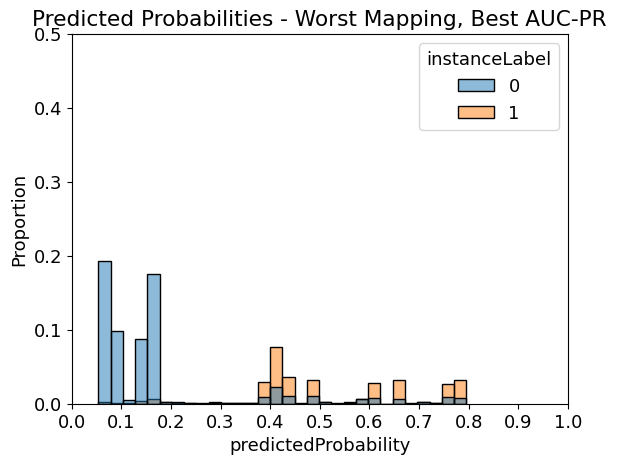

In [219]:
imdbToCoraDF = filterTransferLearningResultsDF(
    sourceDomain = "imdb",
    targetDomain = "cora"
)
worstMappingBestAUCPR_exp = imdbToCoraDF[imdbToCoraDF.mappingShortID == "M031"].sort_values("aucPR_mean", ascending = False).iloc[0]
worstMappingBestAUCPR_expID = worstMappingBestAUCPR_exp.id
plotPredictedPredictions(worstMappingBestAUCPR_expID, title = "Predicted Probabilities - Worst Mapping, Best AUC-PR")

Mapping Short ID: M004

Relation Mappings:
	('female', 'actor', 'director', 'movie') -> empty
	genre -> haswordvenue
	workedunder -> samevenue

Term Type Mappings:
	person -> venue
	genre -> word


Mapping Short ID: M015

Relation Mappings:
	('workedunder', 'female', 'actor', 'director') -> empty
	genre -> samevenue
	movie -> venue

Term Type Mappings:
	movie -> class
	('person', 'genre') -> venue


Mapping Short ID: M030

Relation Mappings:
	('workedunder', 'female', 'actor', 'director', 'genre') -> empty
	movie -> samevenue

Term Type Mappings:
	('movie', 'person') -> venue


Mapping Short ID: M031

Relation Mappings:
	('workedunder', 'female', 'actor', 'director', 'movie') -> empty
	genre -> samevenue

Term Type Mappings:
	('person', 'genre') -> venue


Mapping Short ID: M032

Relation Mappings:
	('workedunder', 'female', 'actor', 'director') -> empty
	genre -> haswordvenue
	movie -> samevenue

Term Type Mappings:
	('movie', 'person') -> venue
	genre -> word


Learning from scratch 

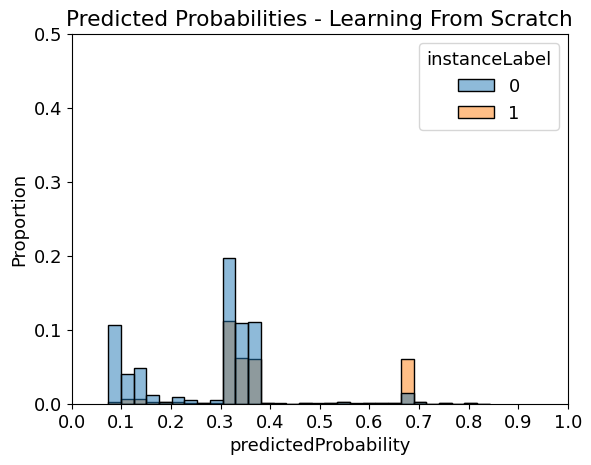

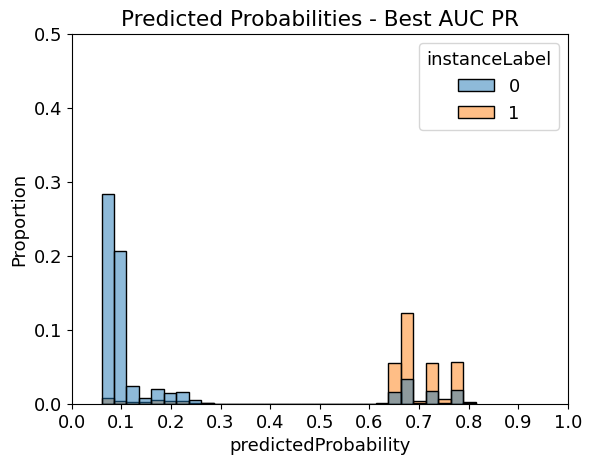

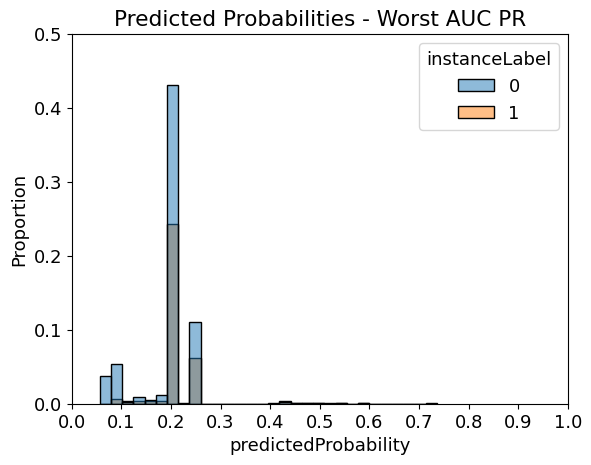

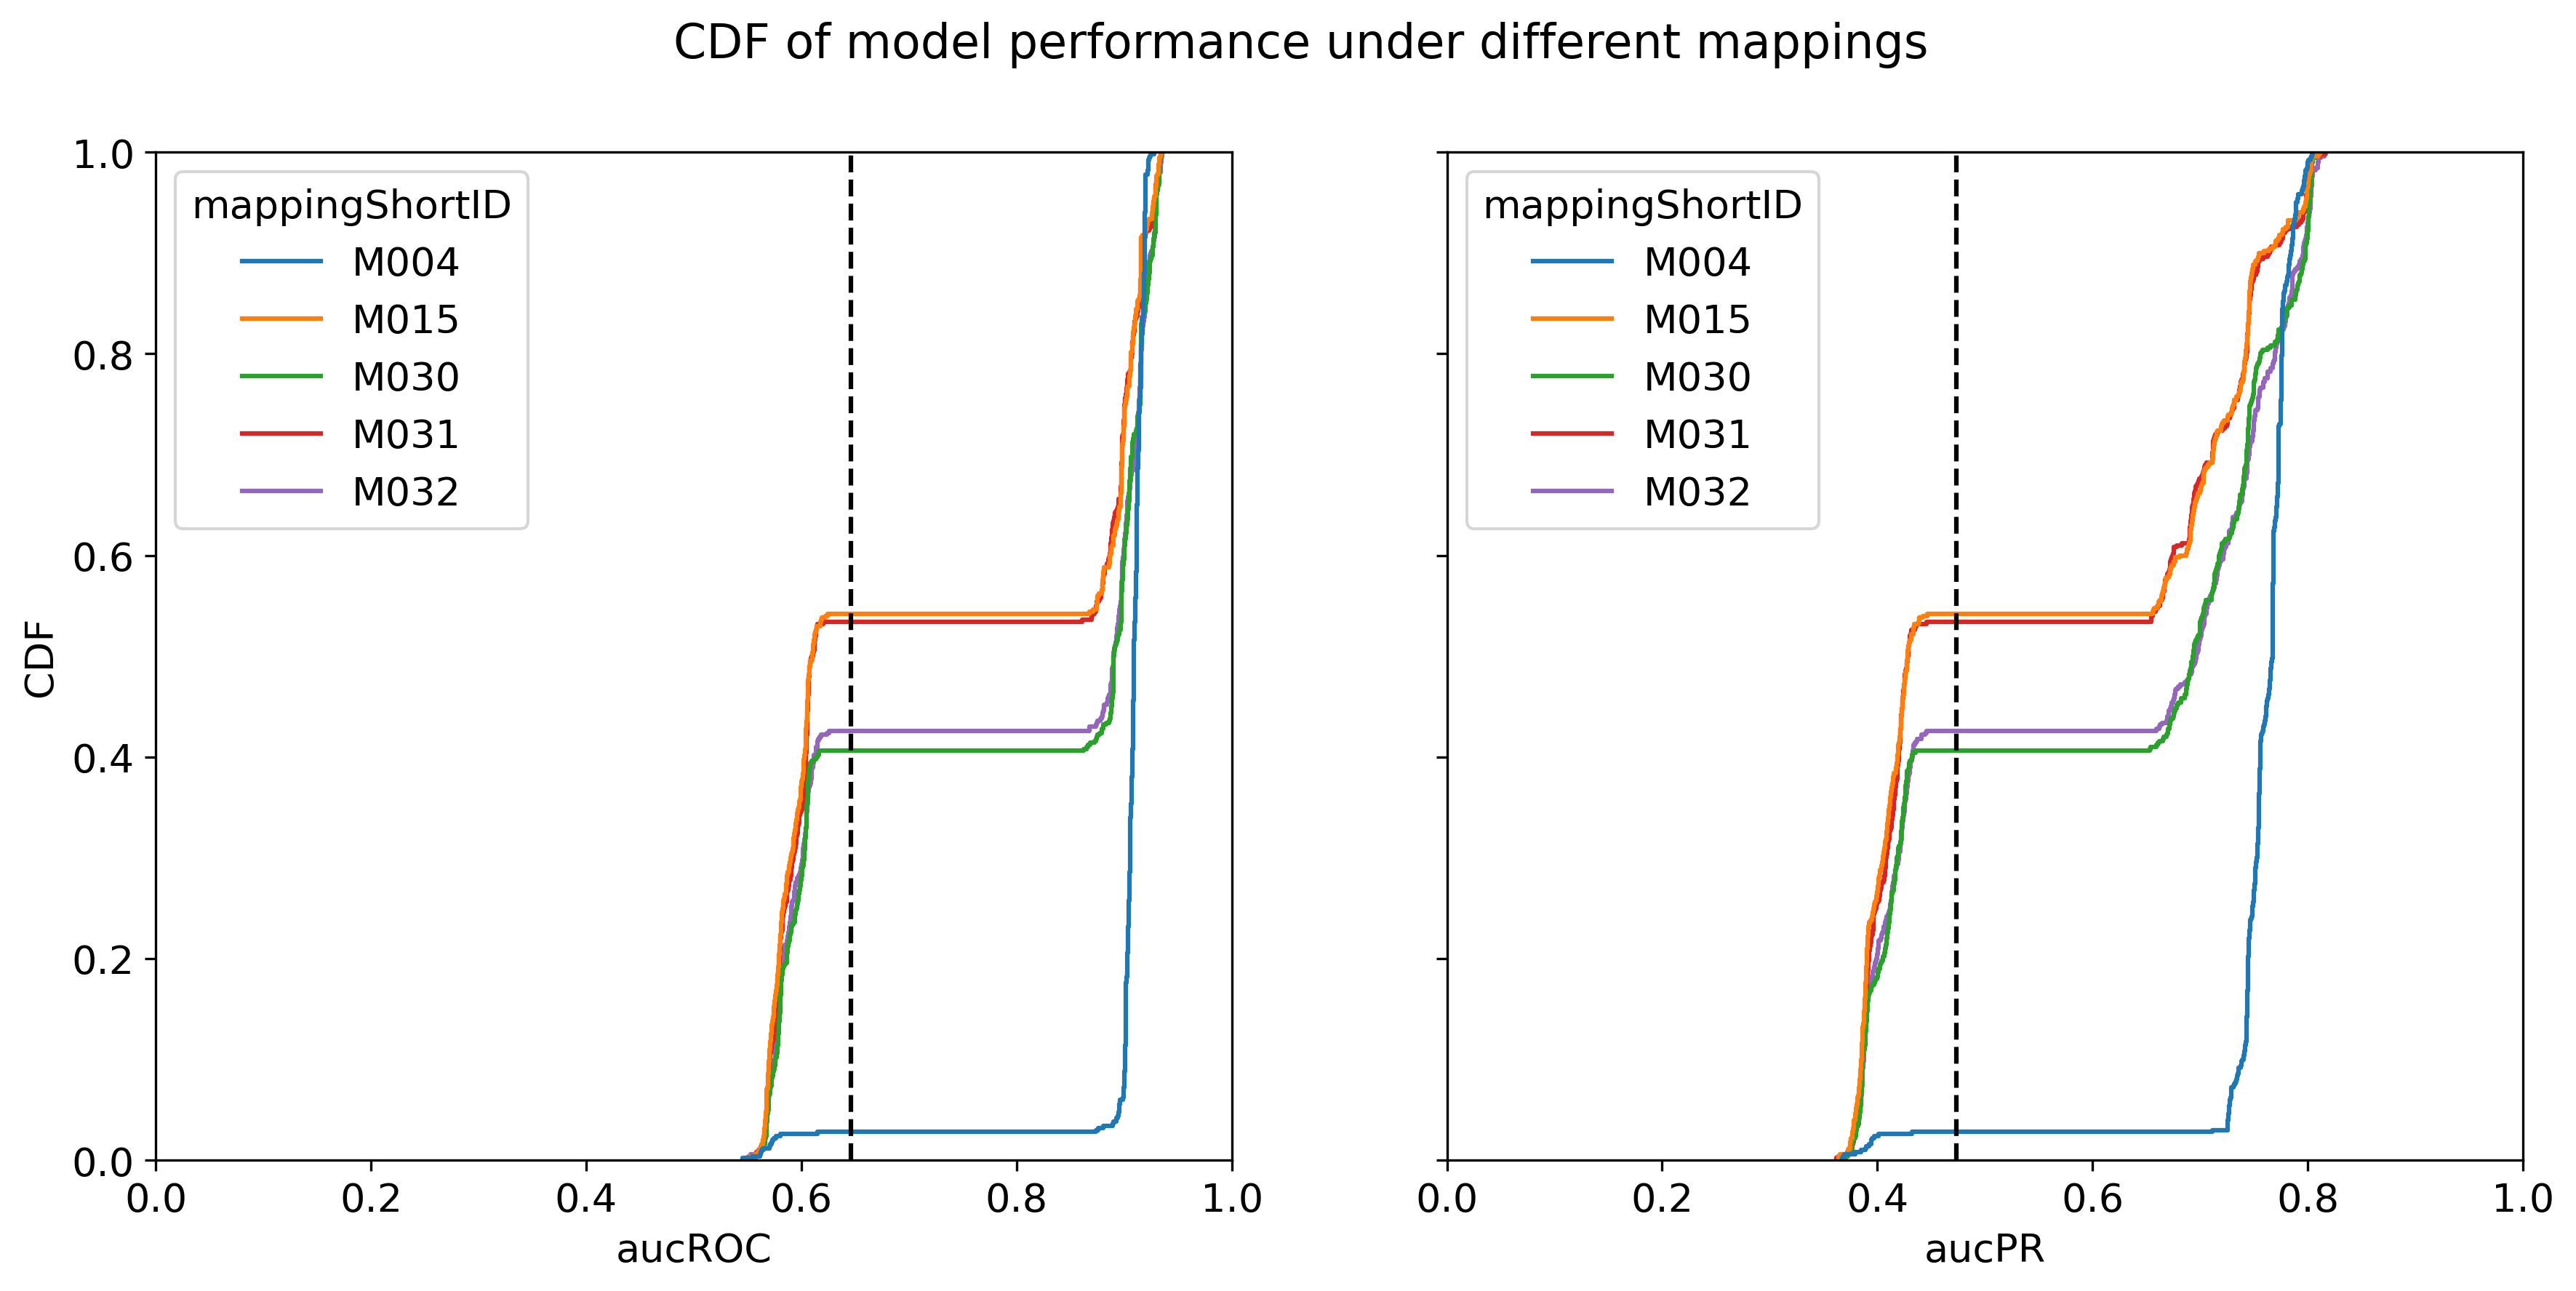

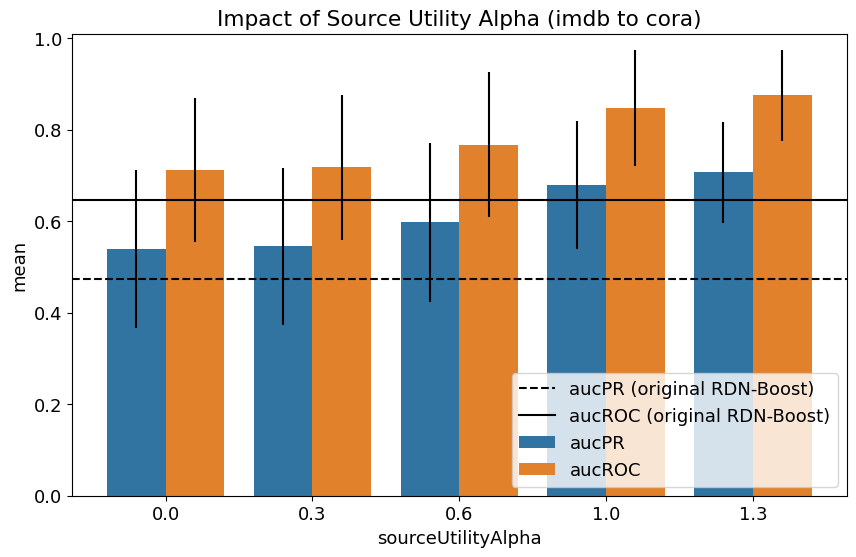

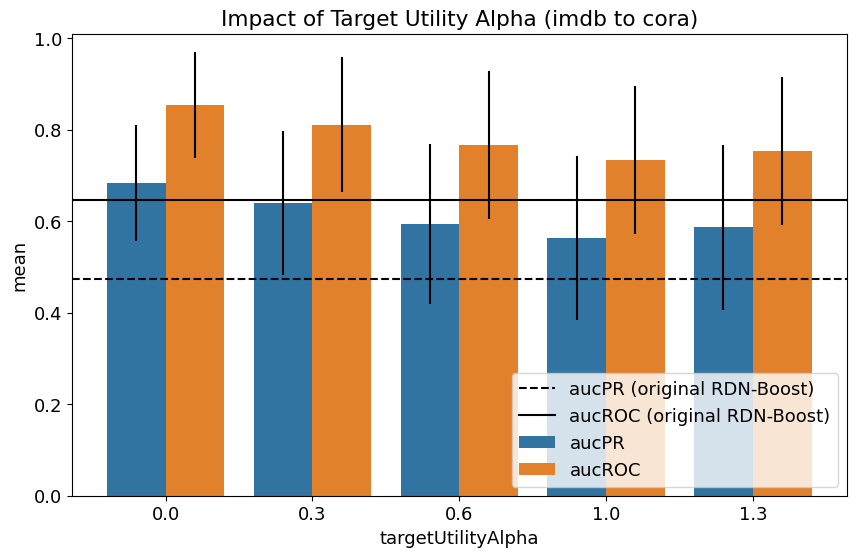

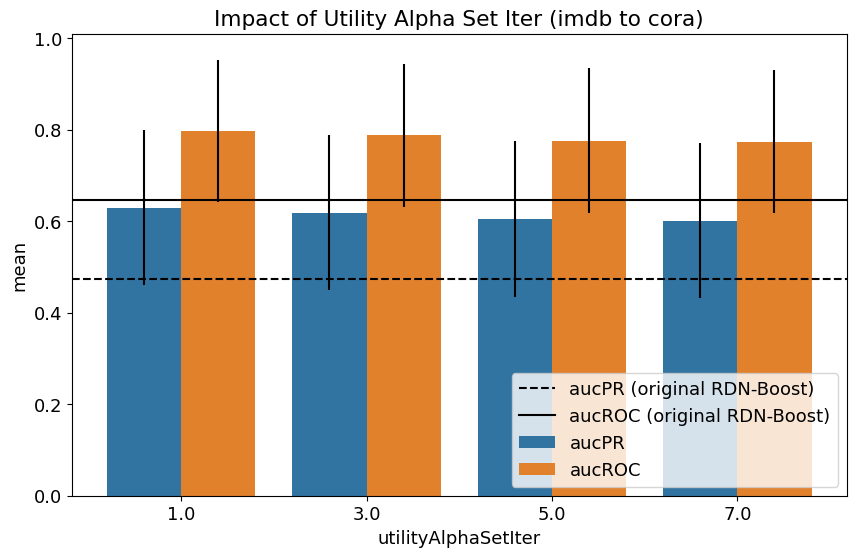

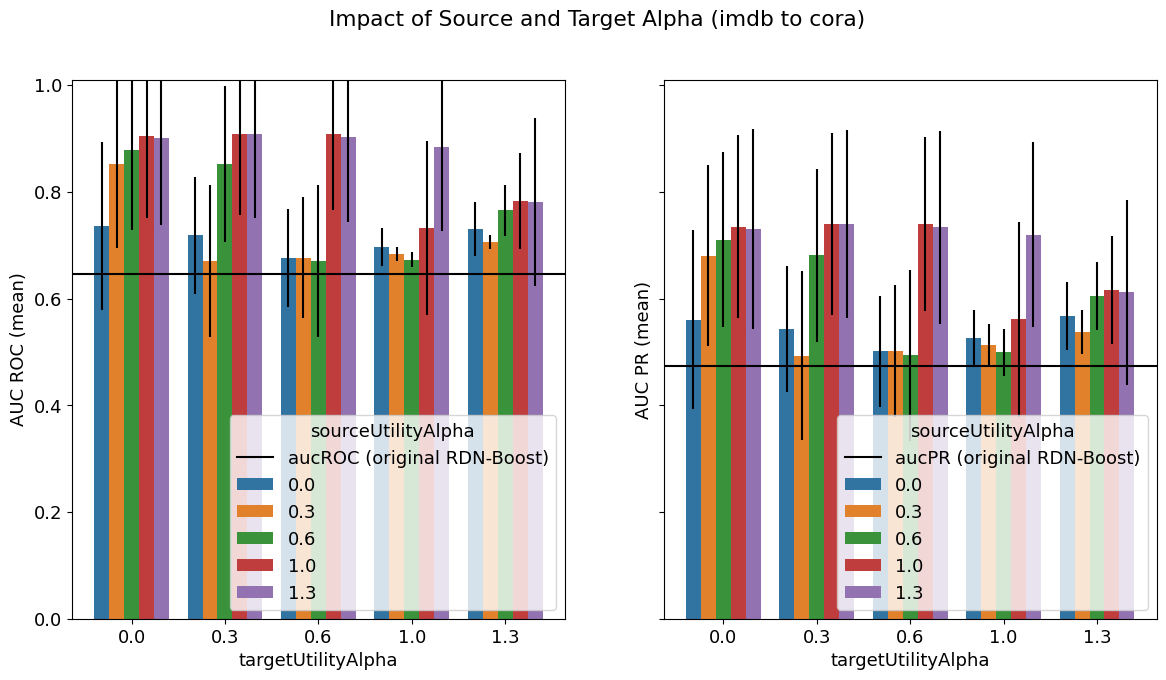

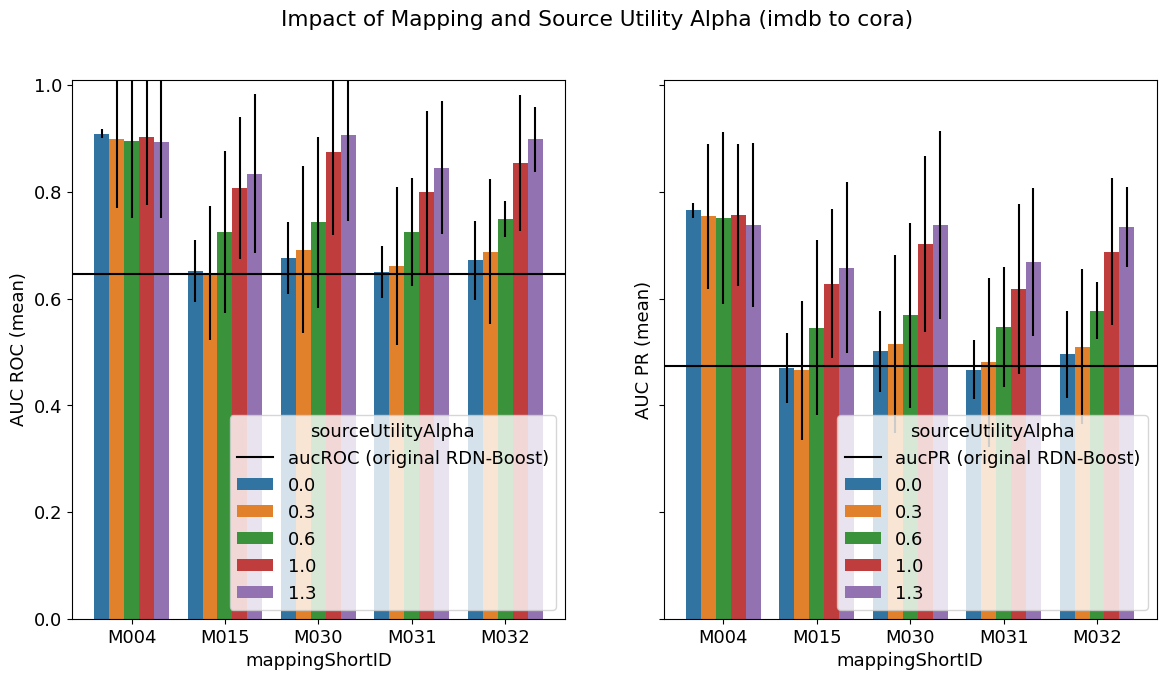

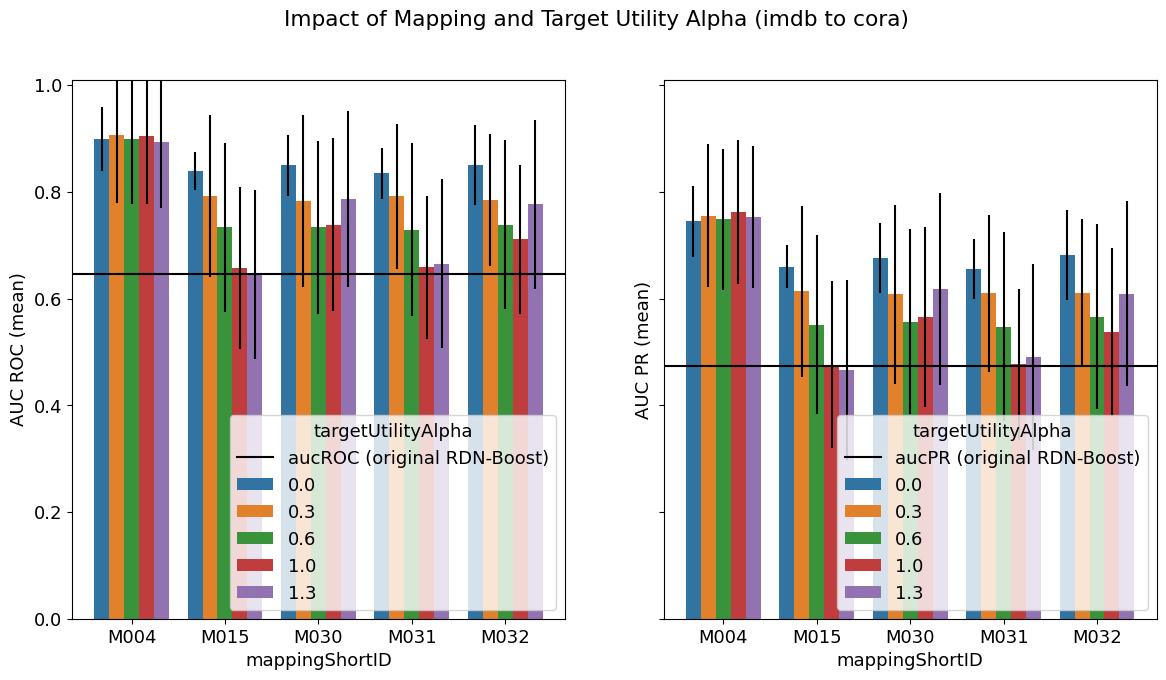

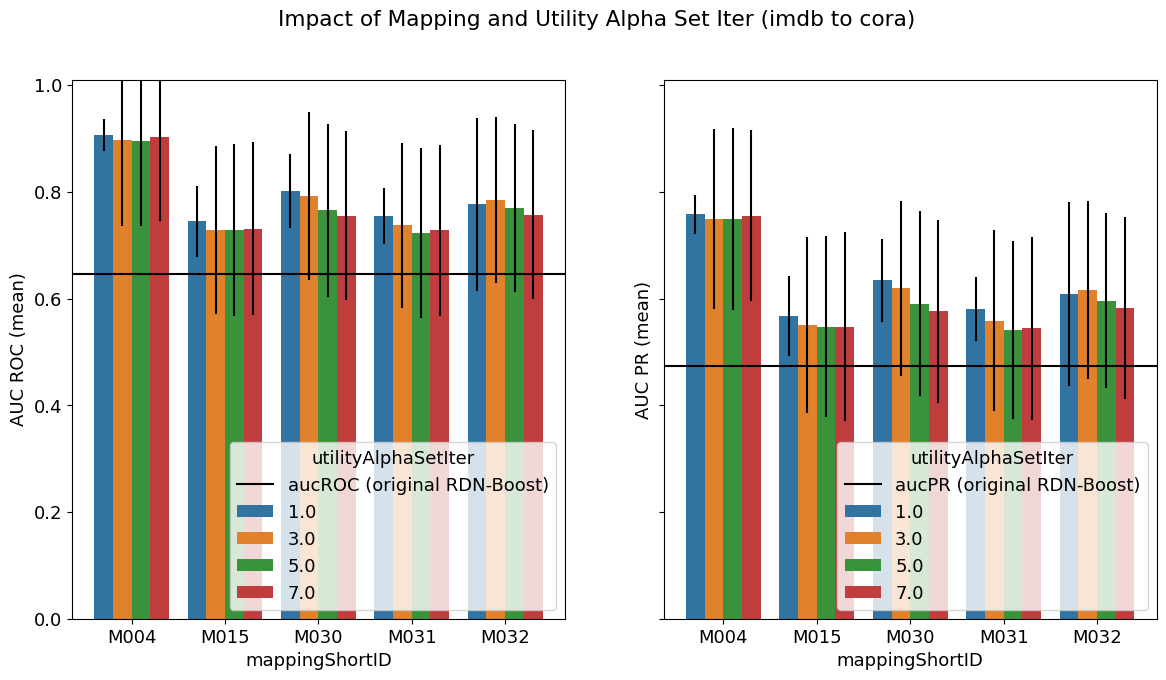

In [220]:
analysisVariables = runAnalysis("imdb", "cora")

# **Cora to IMDB**

Mapping Short ID: M024

Relation Mappings:
	('sameauthor', 'samebib', 'sametitle', 'samevenue', 'title', 'haswordauthor', 'haswordvenue') -> empty
	author -> genre
	haswordtitle -> movie
	venue -> workedunder

Term Type Mappings:
	author -> genre
	title -> movie
	('class', 'venue', 'word') -> person


Mapping Short ID: M025

Relation Mappings:
	('sameauthor', 'samebib', 'sametitle', 'samevenue', 'author', 'haswordtitle', 'haswordvenue') -> empty
	title -> genre
	haswordauthor -> movie
	venue -> workedunder

Term Type Mappings:
	title -> genre
	author -> movie
	('class', 'venue', 'word') -> person


Mapping Short ID: M029

Relation Mappings:
	('sameauthor', 'samebib', 'sametitle', 'samevenue', 'author', 'haswordauthor', 'haswordtitle', 'haswordvenue') -> empty
	title -> genre
	venue -> workedunder

Term Type Mappings:
	title -> genre
	('class', 'venue') -> person


Mapping Short ID: M033

Relation Mappings:
	('sameauthor', 'samebib', 'sametitle', 'samevenue', 'title', 'haswordauthor', '

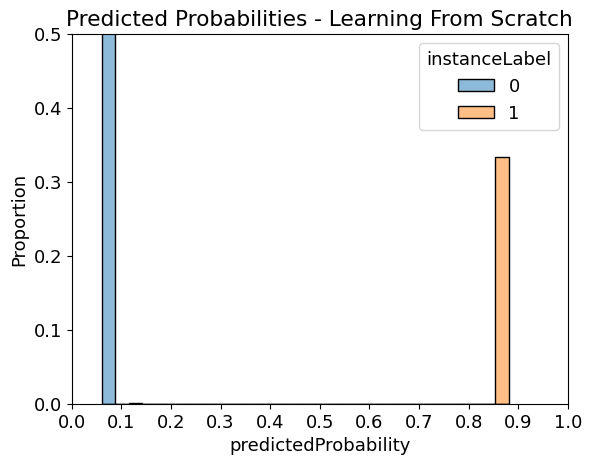

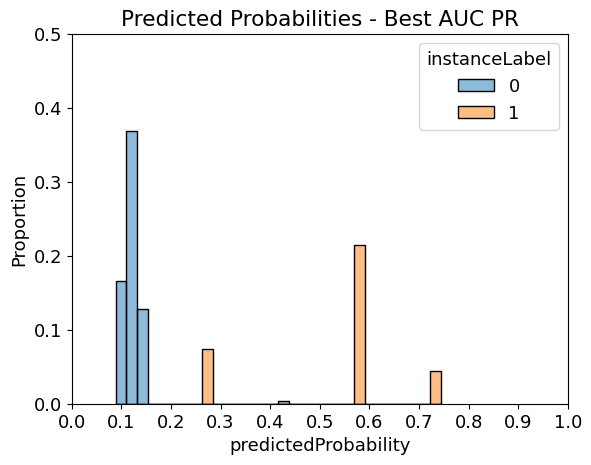

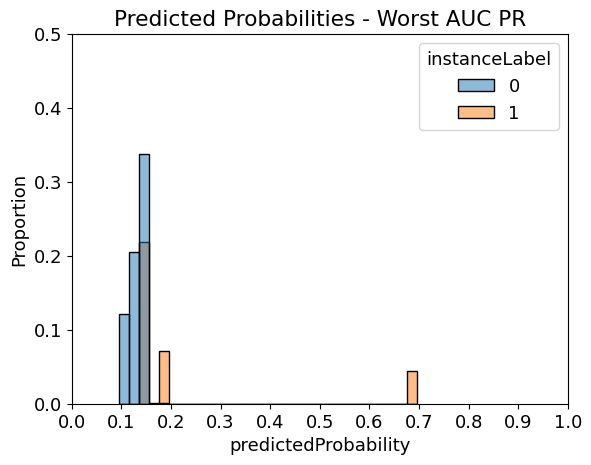

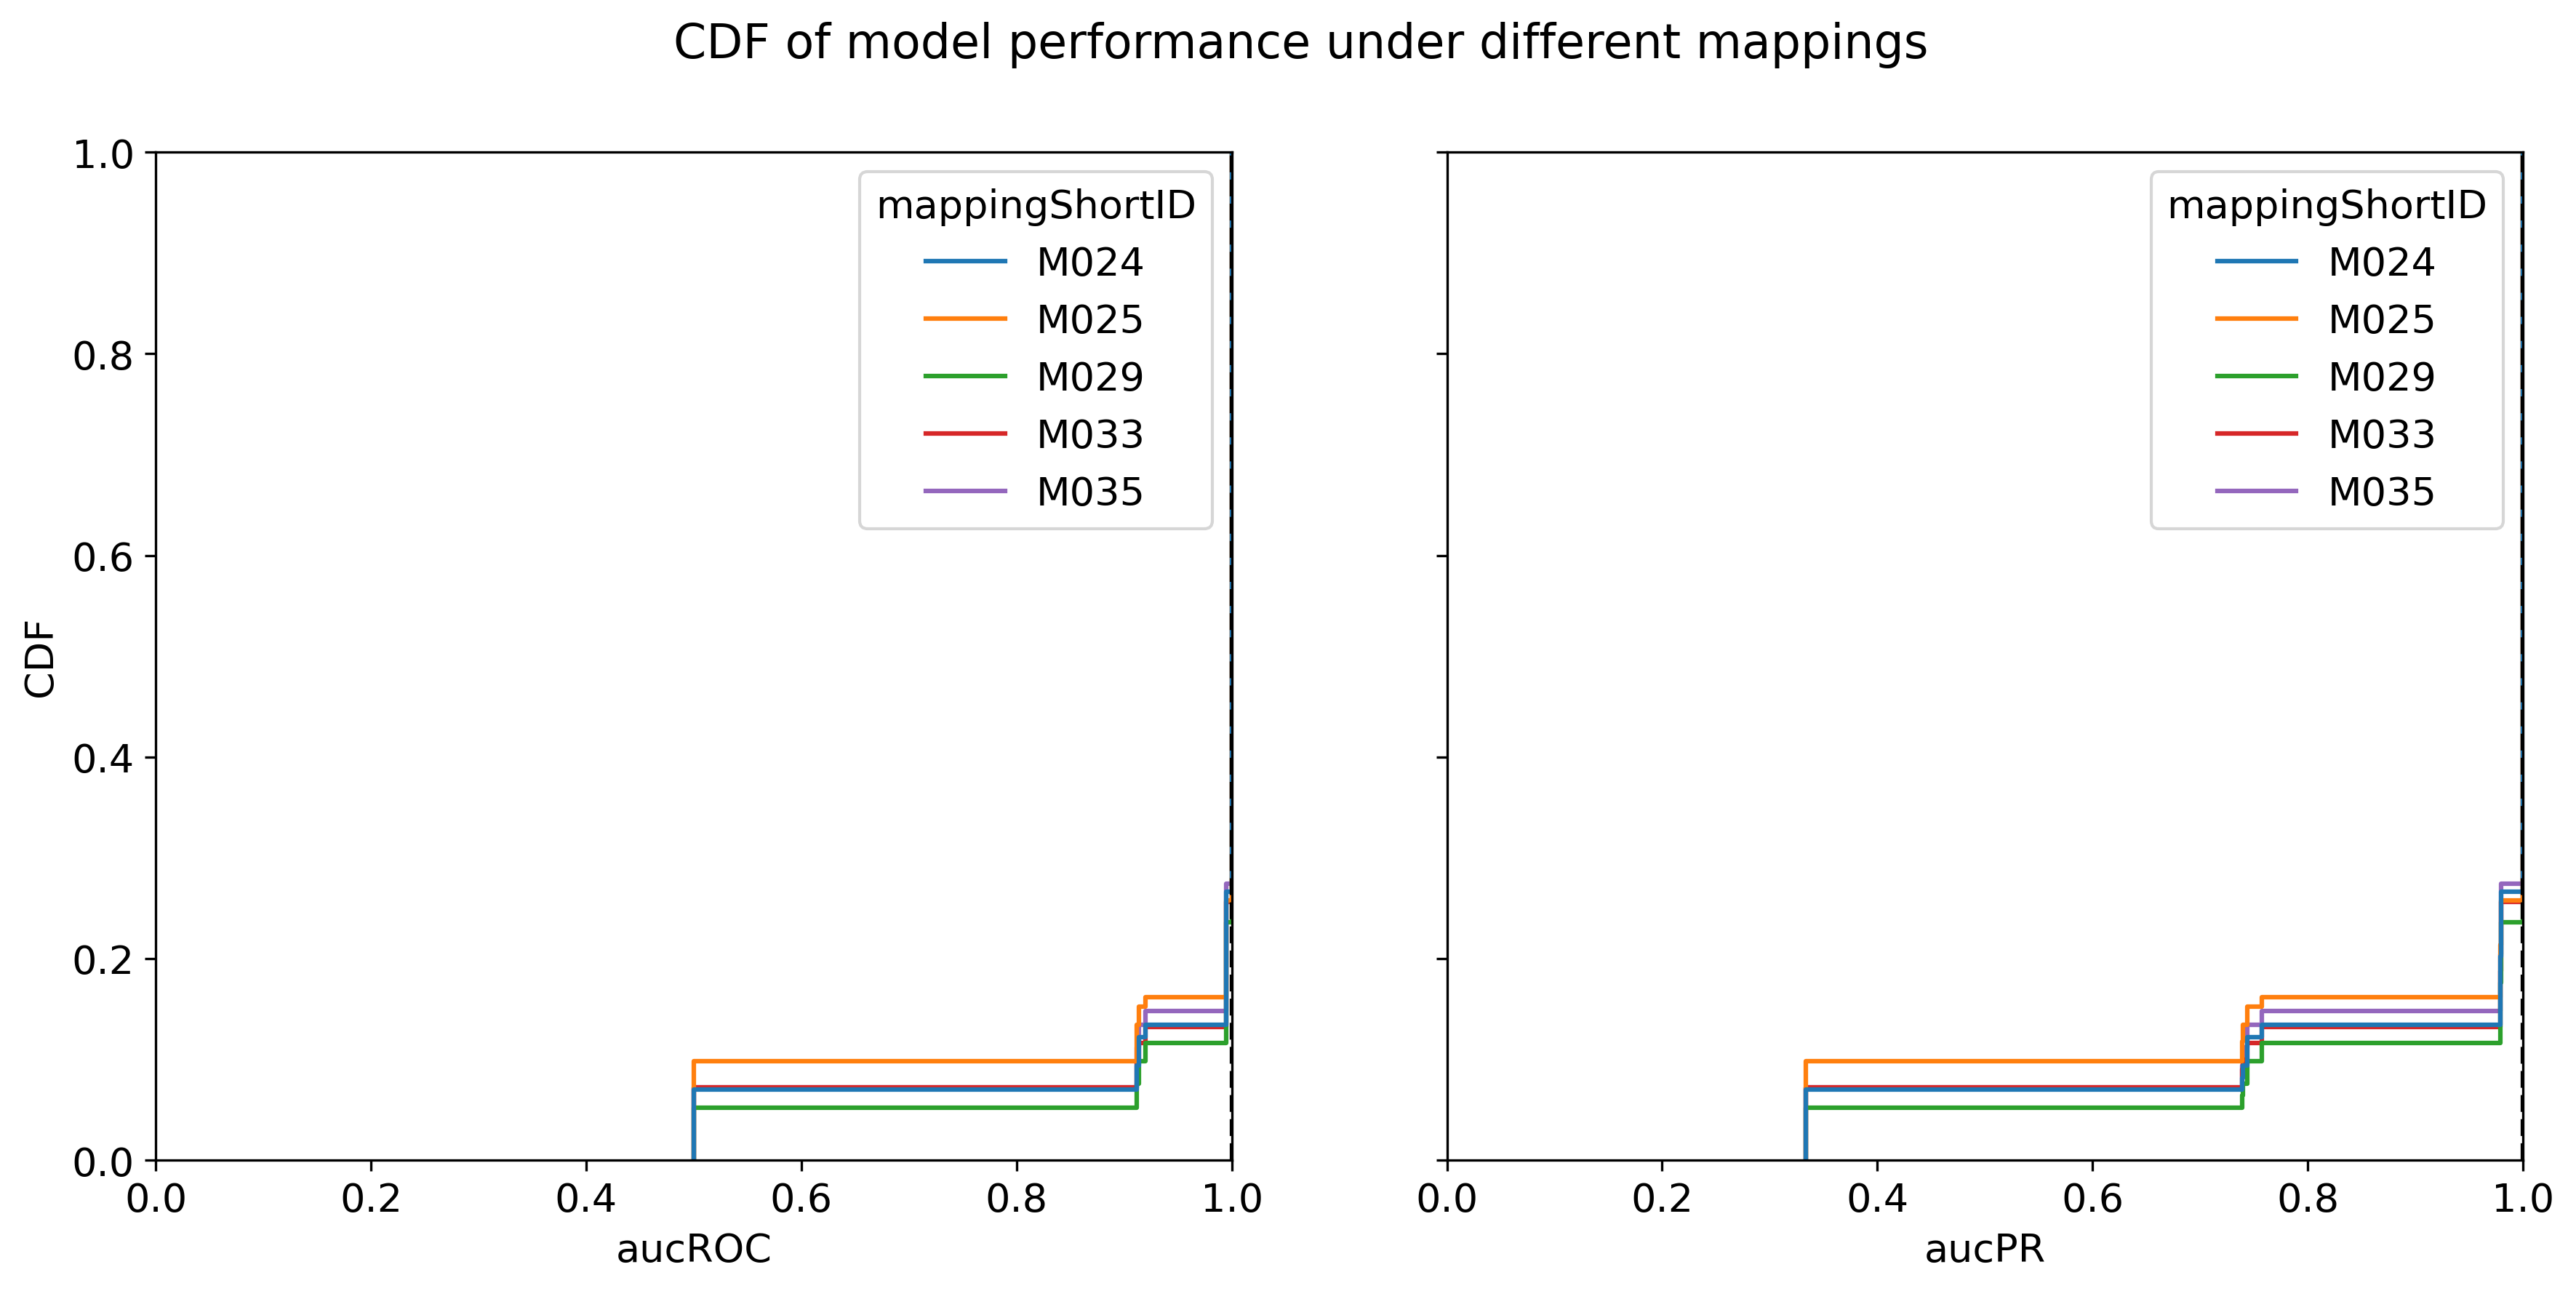

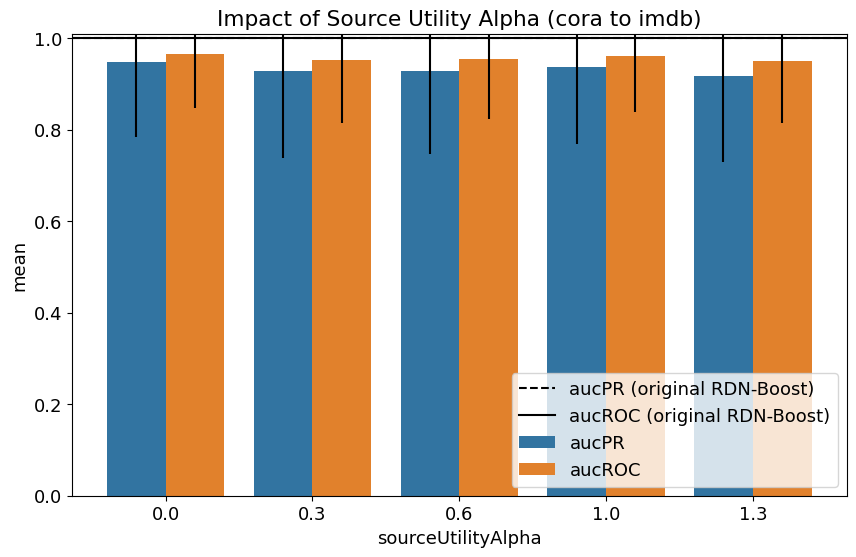

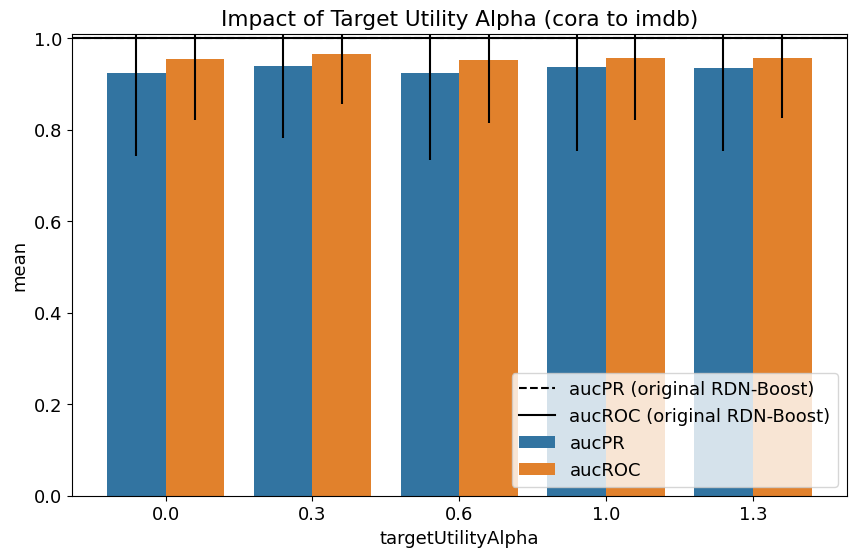

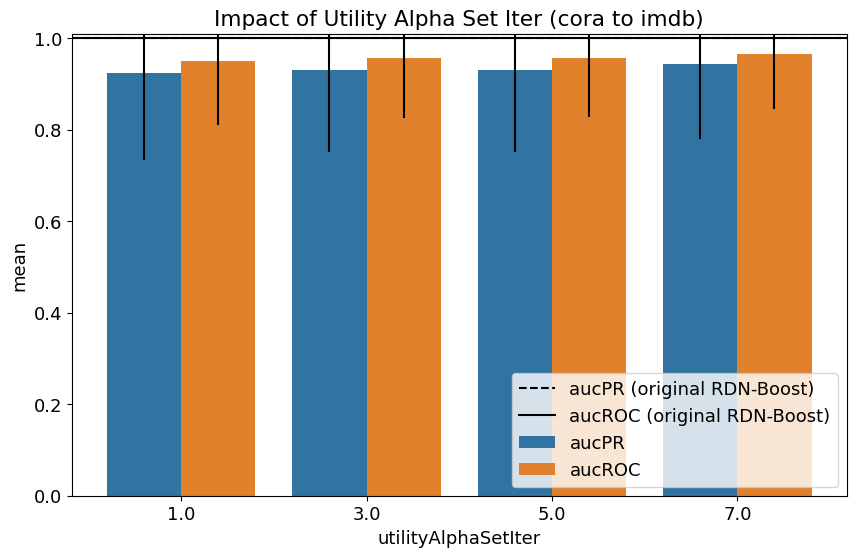

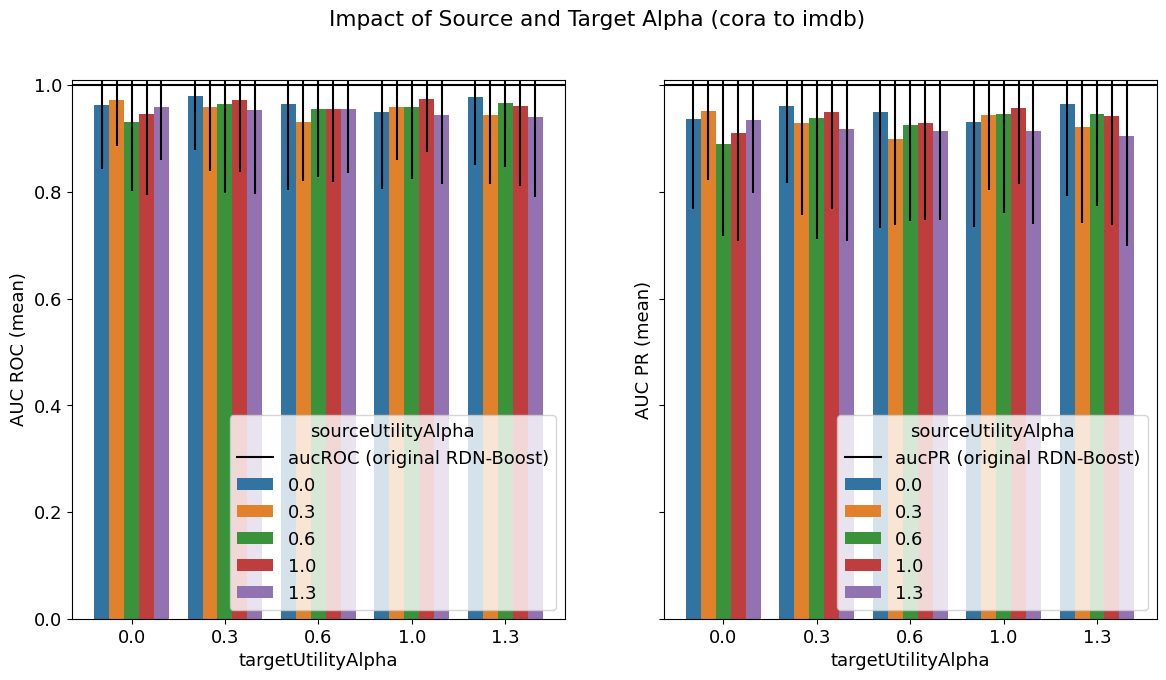

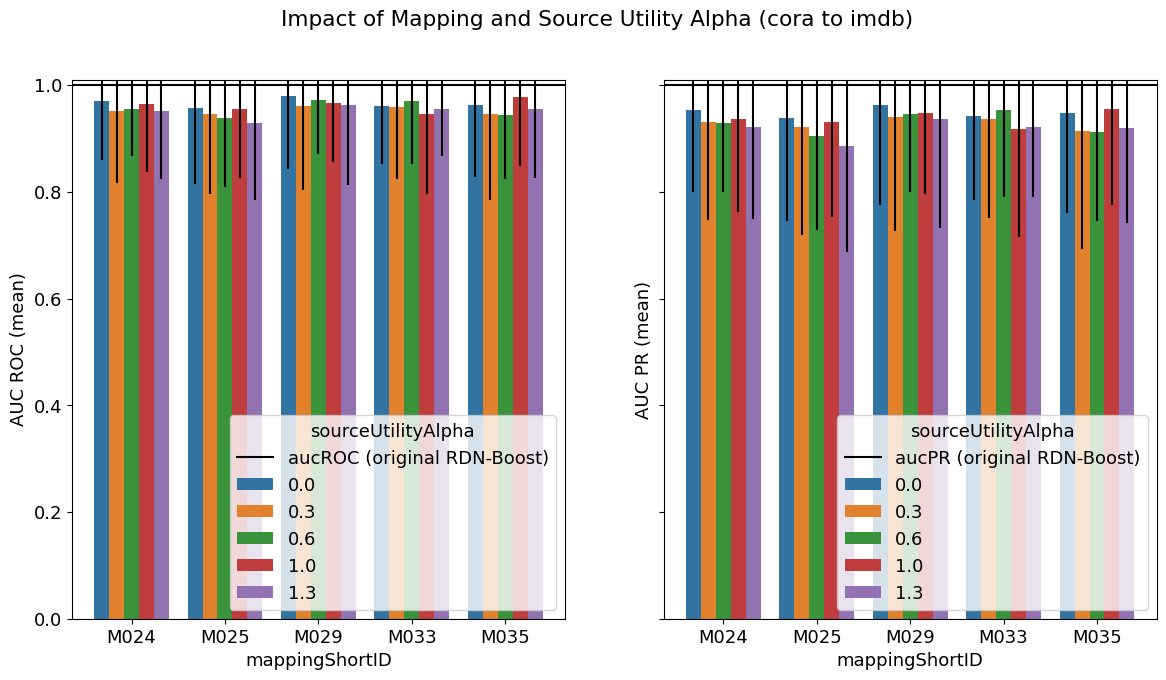

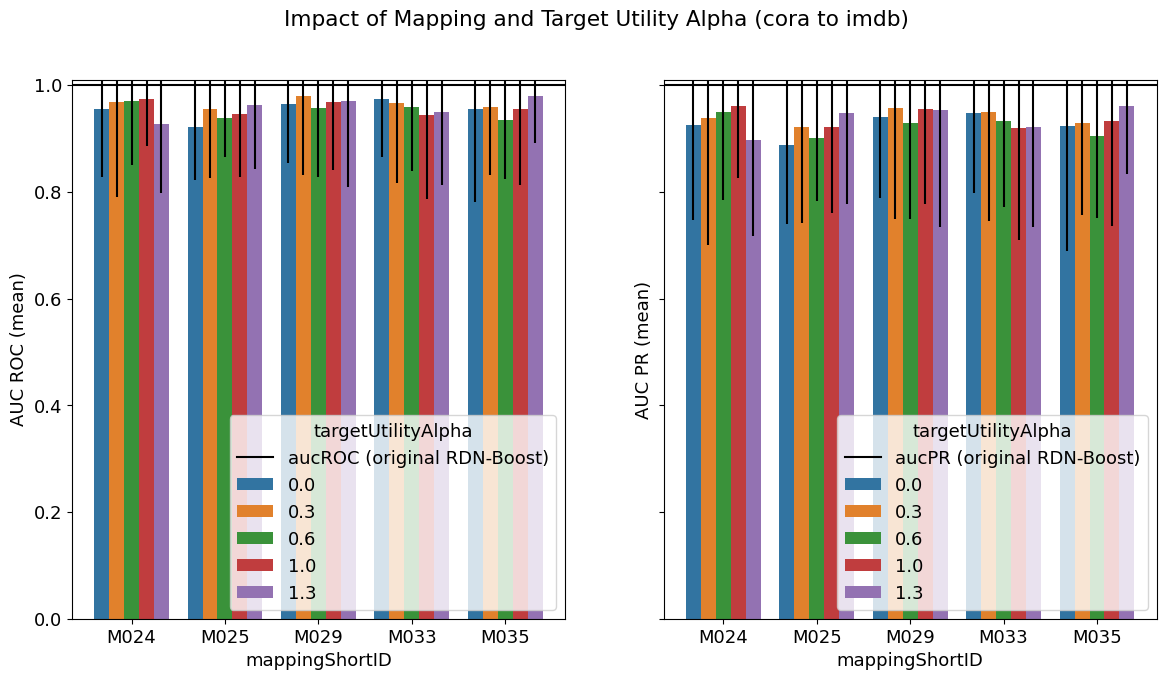

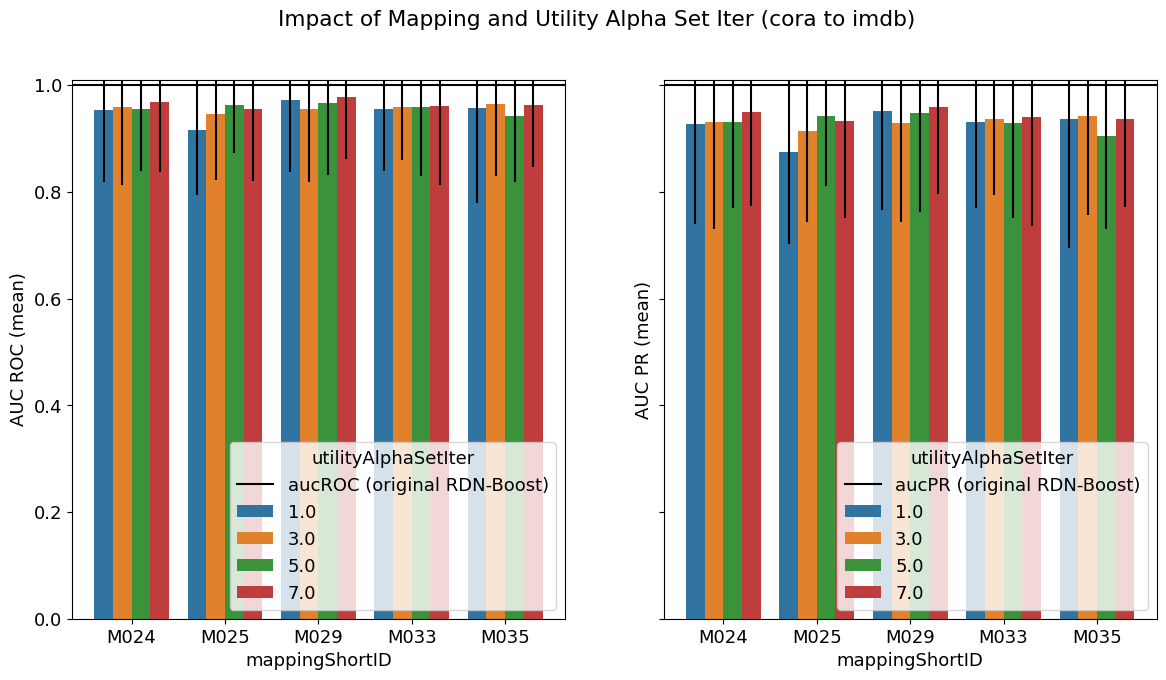

In [221]:
analysisVariables = runAnalysis("cora", "imdb")

# **IMDB To UW-CSE**

Mapping Short ID: M003

Relation Mappings:
	workedunder -> advisedby
	('female', 'actor', 'director') -> empty
	genre -> hasposition
	movie -> tempadvisedby

Term Type Mappings:
	genre -> faculty
	('person', 'movie') -> person


Mapping Short ID: M014

Relation Mappings:
	movie -> advisedby
	female -> empty
	actor -> professor
	director -> student
	workedunder -> tempadvisedby
	genre -> yearsinprogram

Term Type Mappings:
	('movie', 'person') -> person
	genre -> year


Mapping Short ID: M017

Relation Mappings:
	workedunder -> advisedby
	('female', 'director', 'movie', 'genre') -> empty
	actor -> student

Term Type Mappings:
	person -> person


Mapping Short ID: M028

Relation Mappings:
	movie -> advisedby
	('workedunder', 'director') -> empty
	genre -> inphase
	female -> professor
	actor -> student

Term Type Mappings:
	('movie', 'person') -> person
	genre -> prequals


Mapping Short ID: M034

Relation Mappings:
	movie -> advisedby
	('workedunder', 'actor') -> empty
	director -> profe

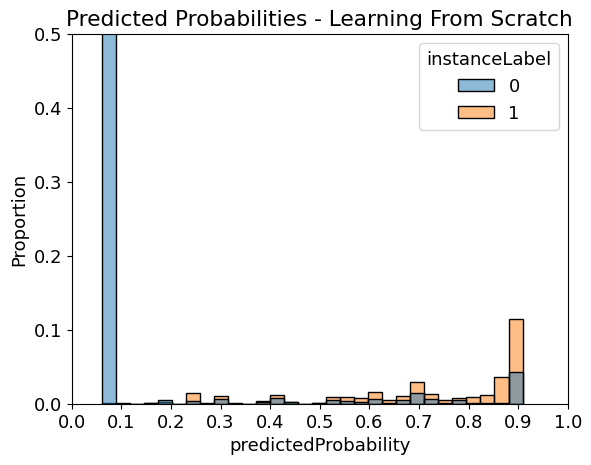

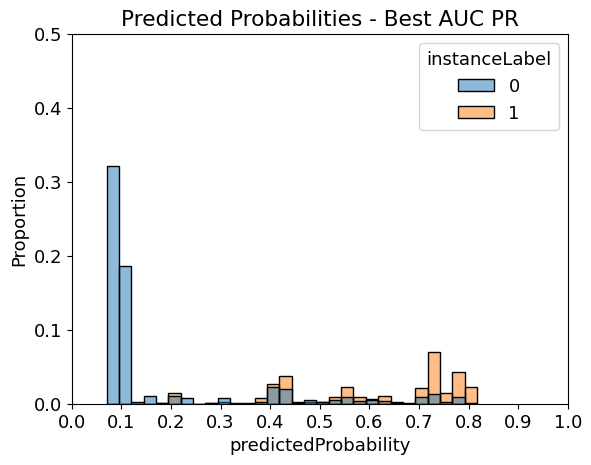

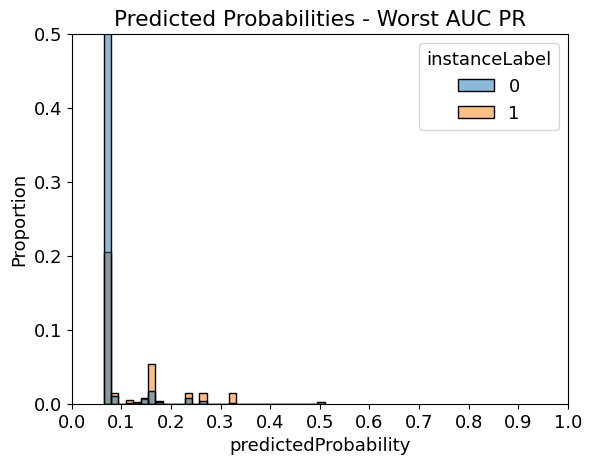

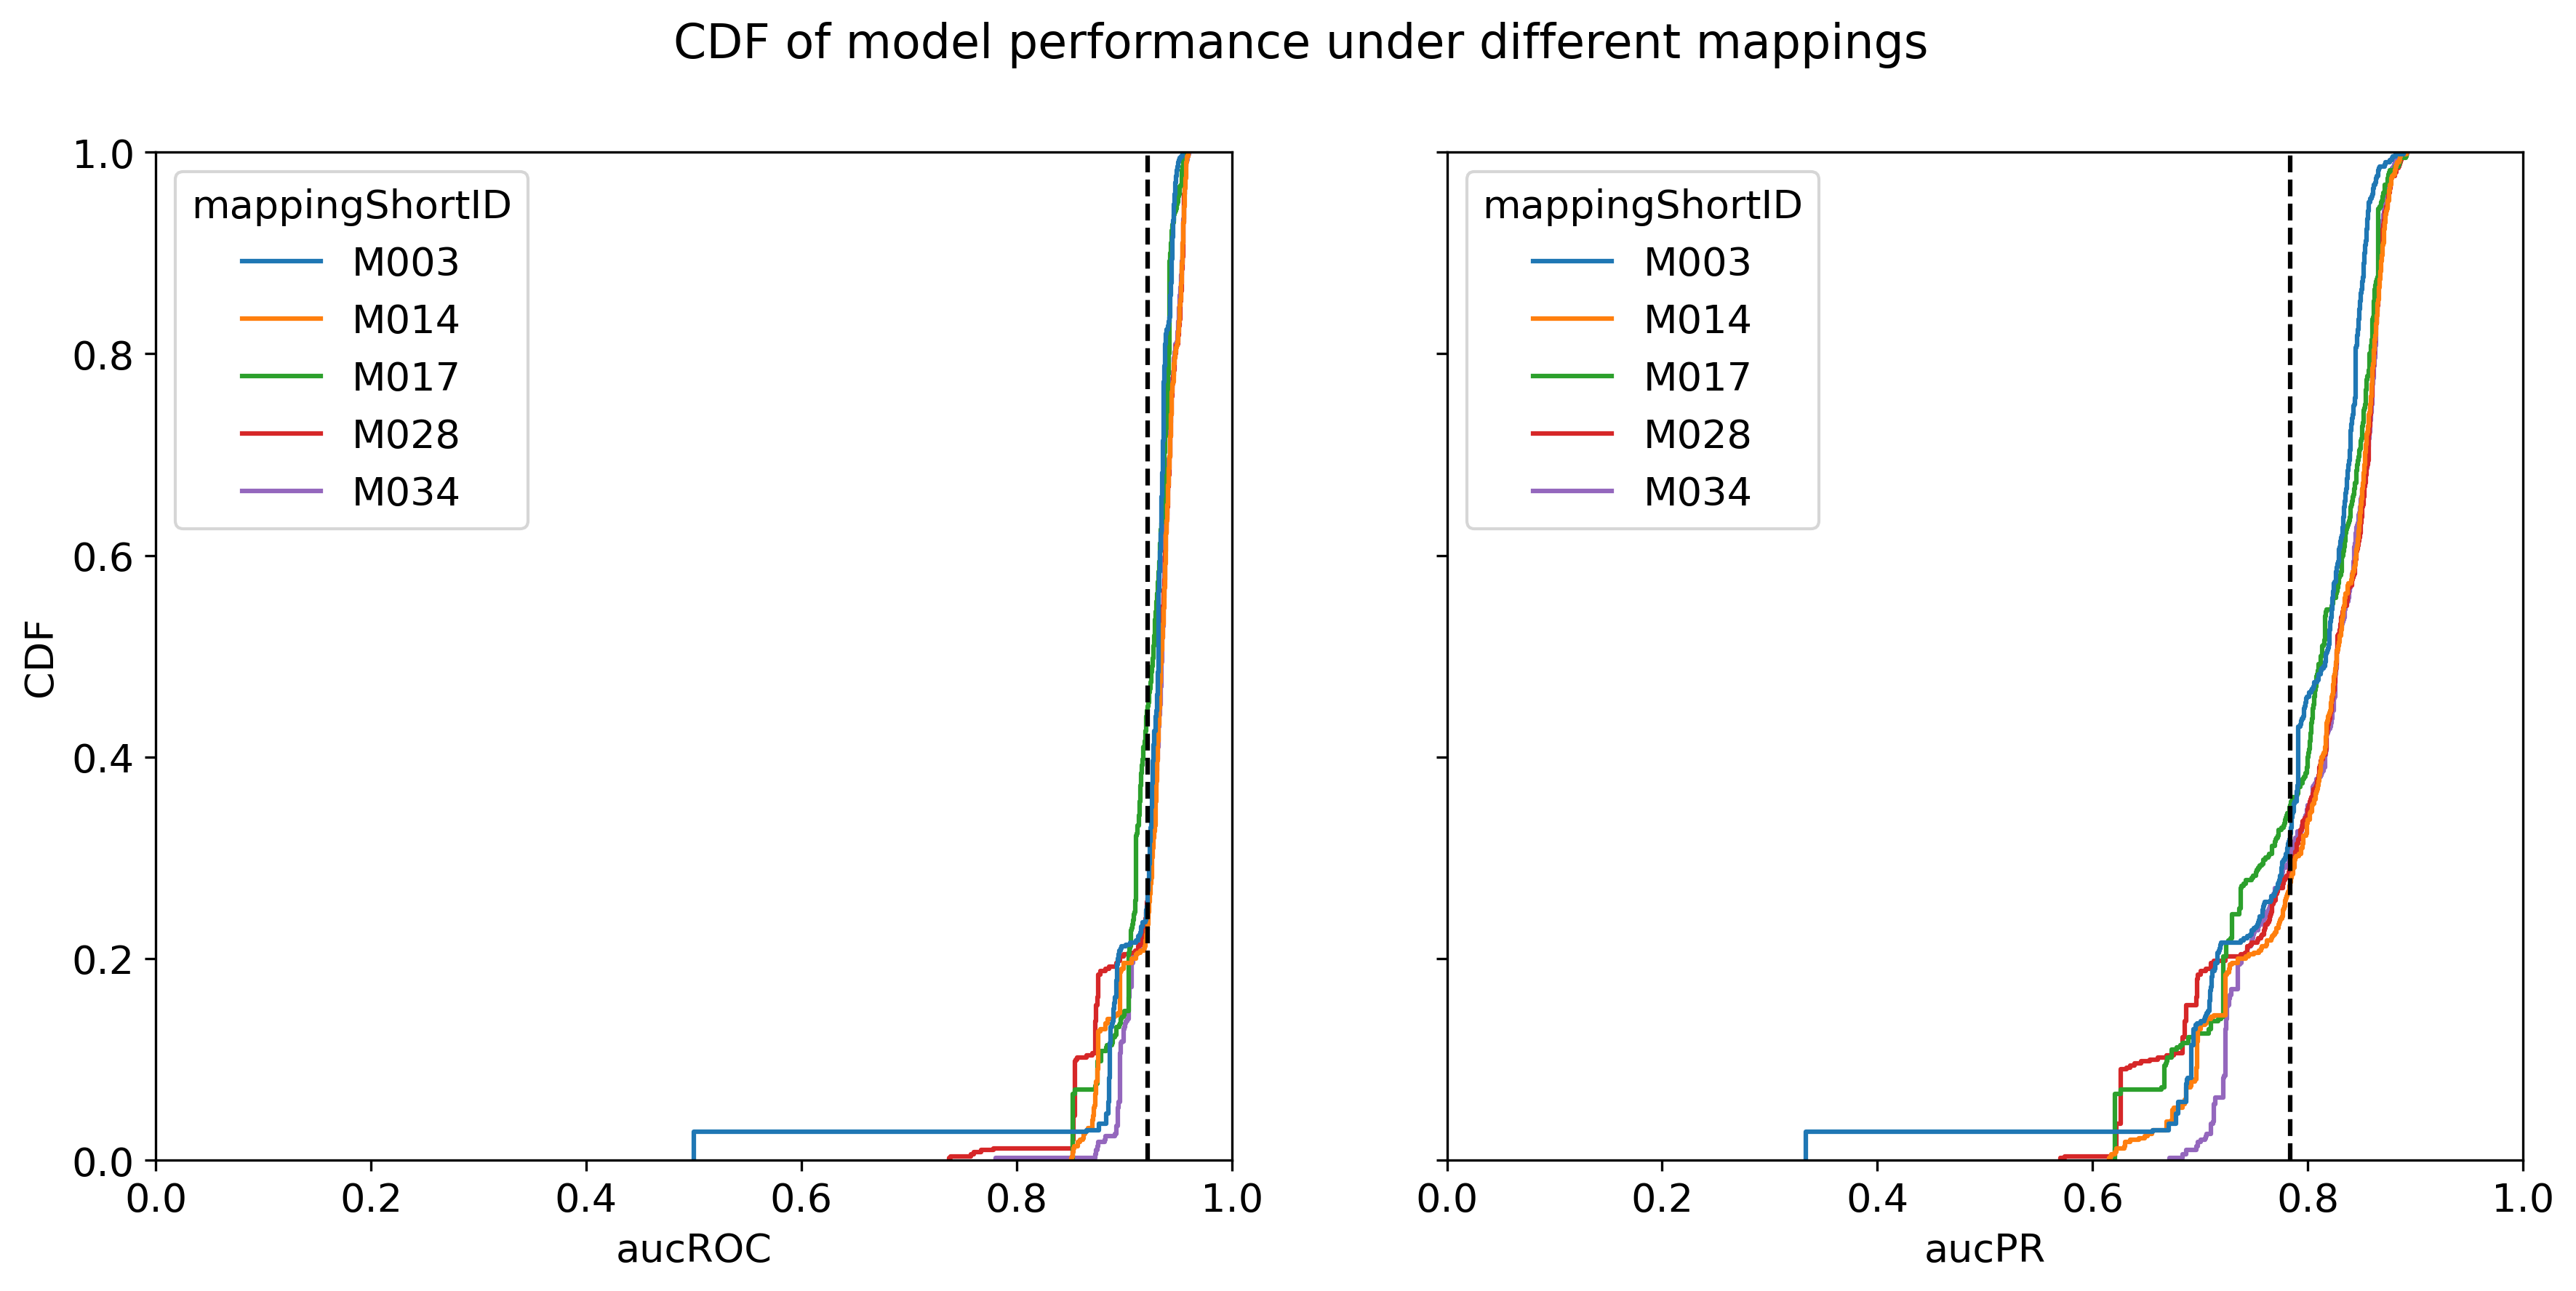

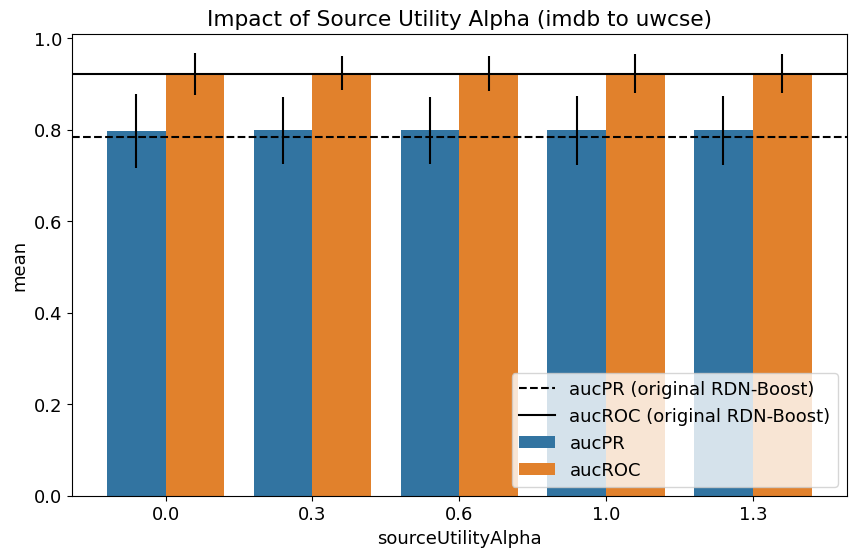

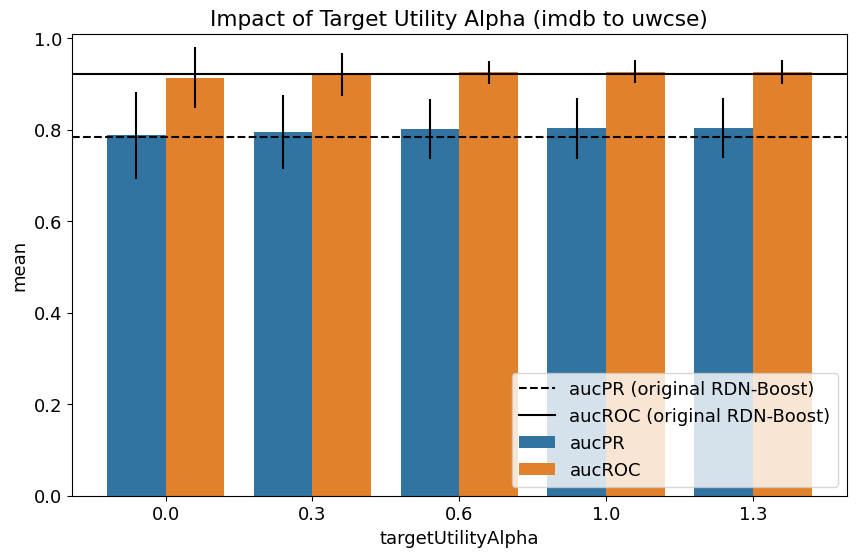

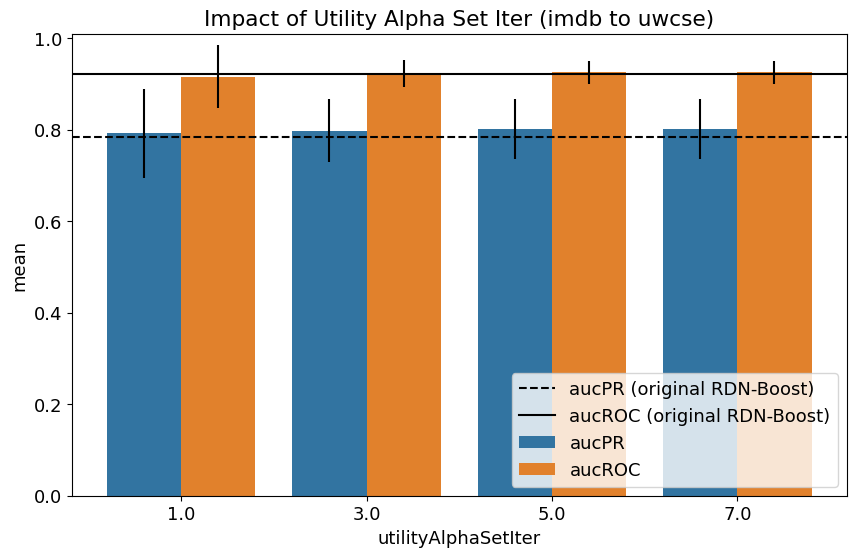

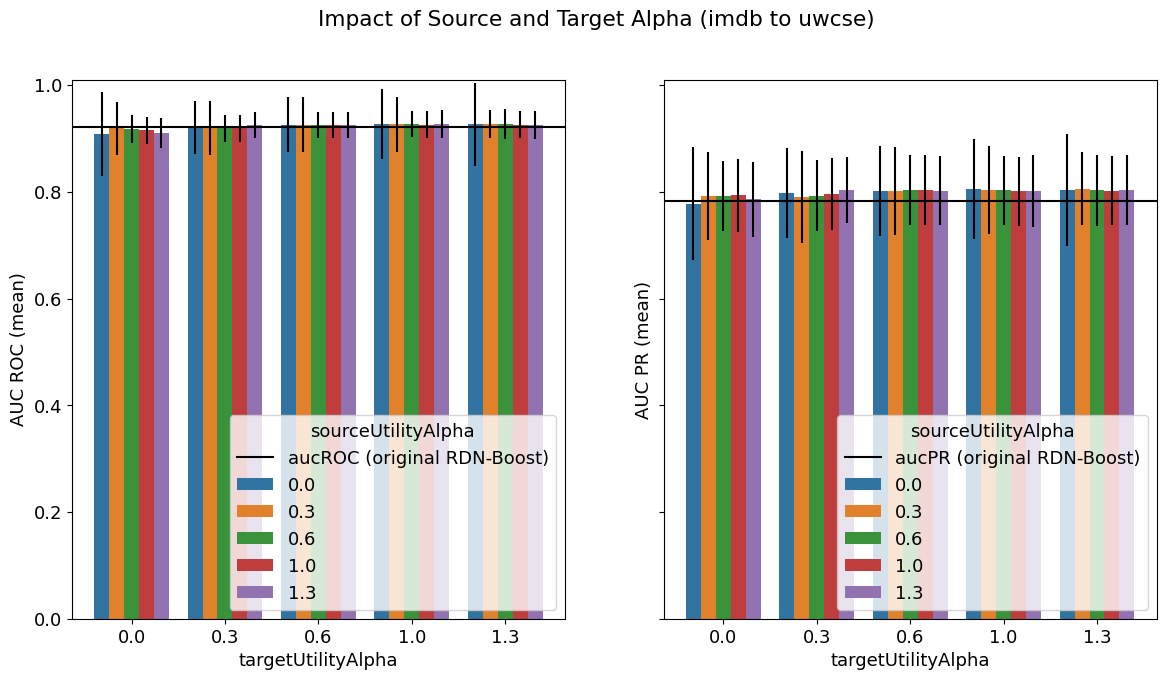

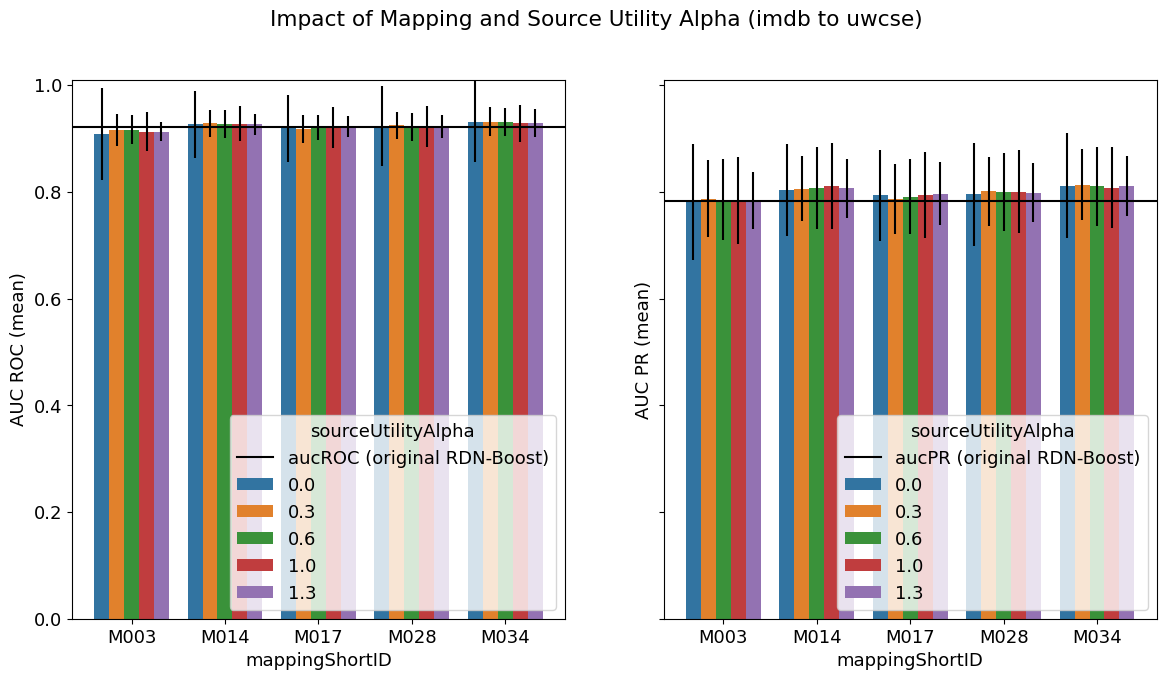

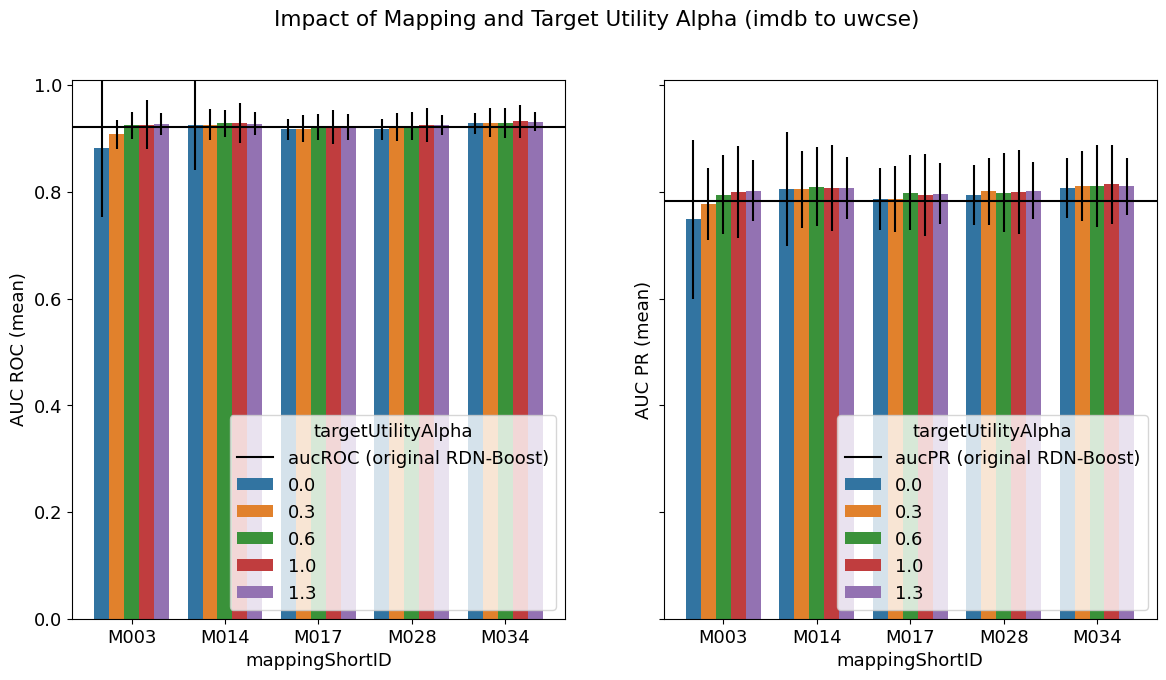

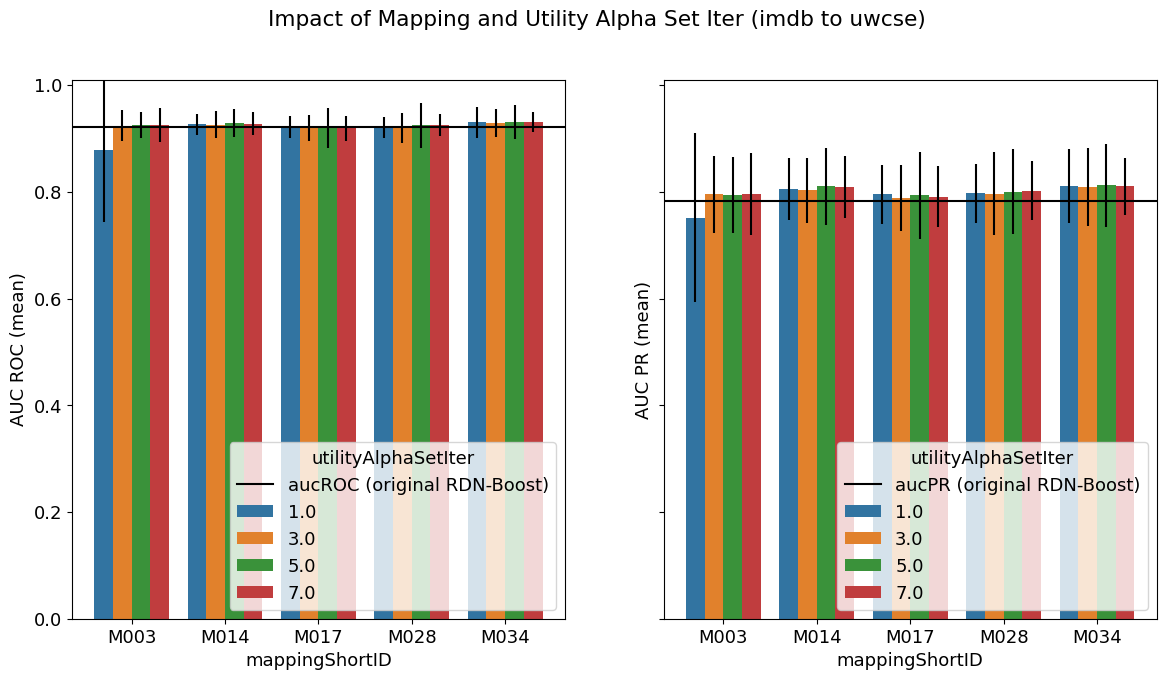

In [222]:
analysisVariables = runAnalysis("imdb", "uwcse")

# **Twitter To Yeast**

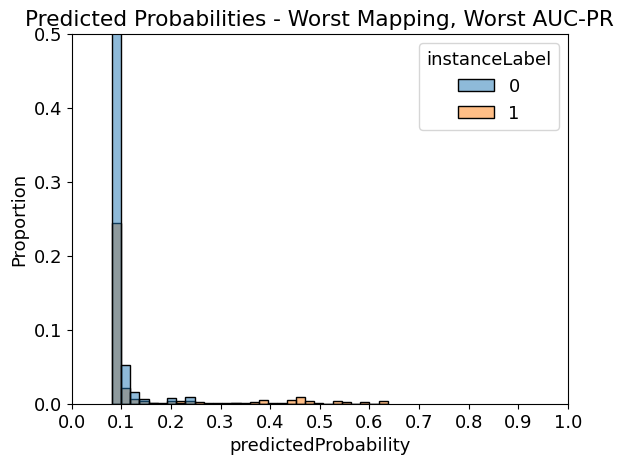

id                             c6699ae4357dc90971510013daadf156bc9f2fd49822c0...
sourceDomain                                                             twitter
targetDomain                                                               yeast
target_targetPredicate                                                      None
sourceUtilityAlpha                                                           0.0
targetUtilityAlpha                                                           1.0
utilityAlphaSetIter                                                          1.0
mappingID                      dd9bc4af03a04eb75642579c83a8f2d7f491272b9e777a...
weightID                       d42b44f4c3a4e5502499c32e1bc8e995921ae19dad0d01...
useRecursion                                                                True
path                                               ./experiments/crossValidation
negPosRatio                                                                    2
randomSeed                  

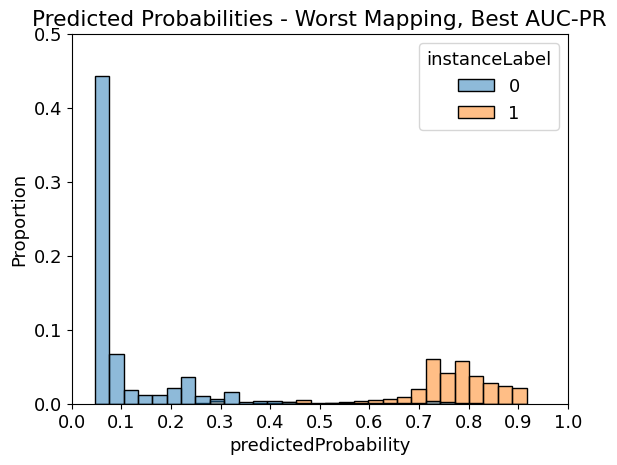

In [223]:
# Our method's hyperparameters can be tuned to improve performance even under bad mappings
twitterYeastDF = filterTransferLearningResultsDF(
    sourceDomain = "twitter",
    targetDomain = "yeast"
)
worstMappingTwitterYeastDF = twitterYeastDF[twitterYeastDF.mappingShortID == "M027"].sort_values("aucPR_mean", ascending = False)

worstMappingWorstAUCPR_exp = worstMappingTwitterYeastDF.iloc[-1]
worstMappingWorstAUCPR_expID = worstMappingWorstAUCPR_exp.id
plotPredictedPredictions(worstMappingWorstAUCPR_expID, title = "Predicted Probabilities - Worst Mapping, Worst AUC-PR")

worstMappingBestAUCPR_exp = worstMappingTwitterYeastDF.iloc[0]
print(worstMappingBestAUCPR_exp)
worstMappingBestAUCPR_expID = worstMappingBestAUCPR_exp.id
plotPredictedPredictions(worstMappingBestAUCPR_expID, title = "Predicted Probabilities - Worst Mapping, Best AUC-PR")

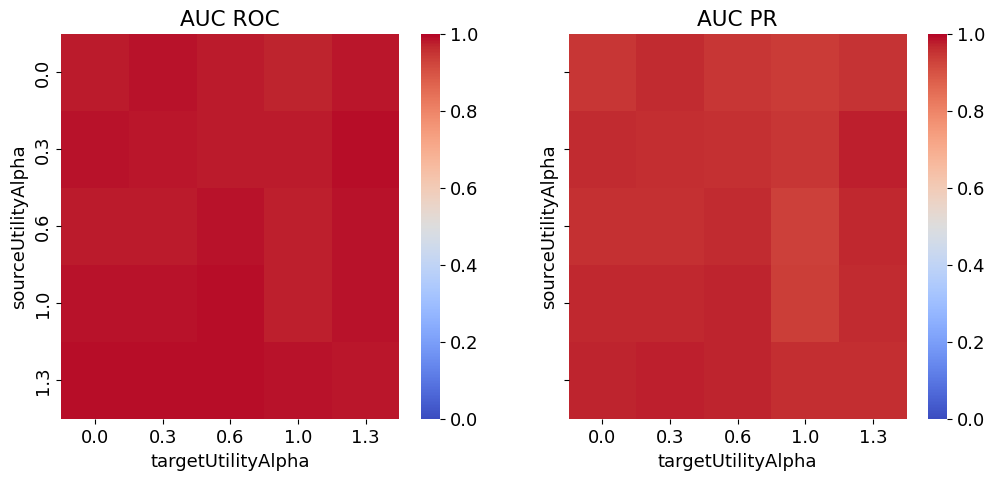

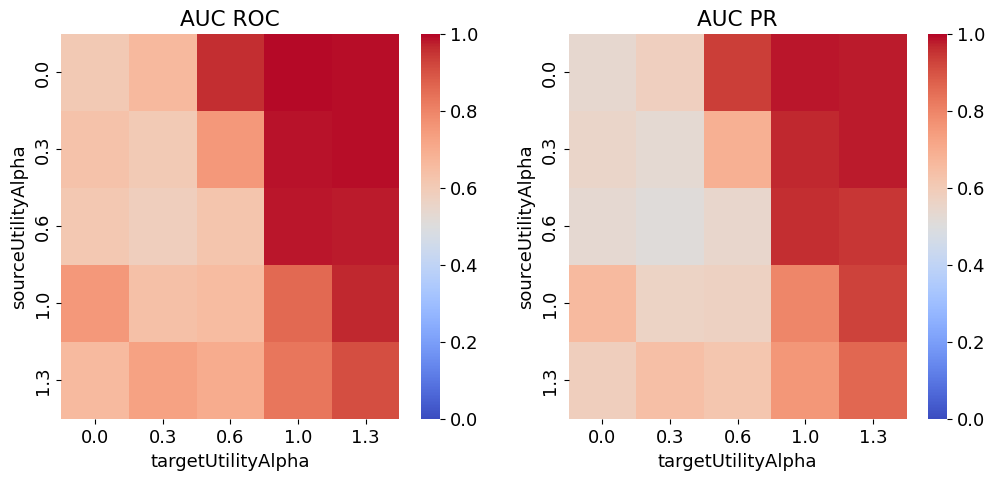

In [224]:
bestMappingTwitterYeastDF = twitterYeastDF[twitterYeastDF.mappingShortID == "M016"].sort_values("aucPR_mean", ascending = False)

bestMappingExperimentsDF = pd.merge(
    bestMappingTwitterYeastDF,
    transferLearningMetricsDF, 
    left_on = "id",
    right_on = "experimentID", 
    how = "left"
)[["sourceUtilityAlpha", "targetUtilityAlpha", "aucROC", "aucPR"]]

bestMappingExperimentsDF = bestMappingExperimentsDF.groupby(["sourceUtilityAlpha", "targetUtilityAlpha"]).mean().reset_index()
bestMappingPlotDataAUCROC = bestMappingExperimentsDF.pivot(index = "sourceUtilityAlpha", columns = "targetUtilityAlpha", values = "aucROC")
bestMappingPlotDataAUCPR = bestMappingExperimentsDF.pivot(index = "sourceUtilityAlpha", columns = "targetUtilityAlpha", values = "aucPR")


worstMappingTwitterYeastDF = twitterYeastDF[twitterYeastDF.mappingShortID == "M027"].sort_values("aucPR_mean", ascending = False)

worstMappingExperimentsDF = pd.merge(
    worstMappingTwitterYeastDF,
    transferLearningMetricsDF, 
    left_on = "id",
    right_on = "experimentID", 
    how = "left"
)[["sourceUtilityAlpha", "targetUtilityAlpha", "aucROC", "aucPR"]]

worstMappingExperimentsDF = worstMappingExperimentsDF.groupby(["sourceUtilityAlpha", "targetUtilityAlpha"]).mean().reset_index()
worstMappingPlotDataAUCROC = worstMappingExperimentsDF.pivot(index = "sourceUtilityAlpha", columns = "targetUtilityAlpha", values = "aucROC")
worstMappingPlotDataAUCPR = worstMappingExperimentsDF.pivot(index = "sourceUtilityAlpha", columns = "targetUtilityAlpha", values = "aucPR")

cmap = sns.color_palette("coolwarm", as_cmap=True)
vmin, vmax = 0, 1

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5), sharey = True)
sns.heatmap(bestMappingPlotDataAUCROC, cmap = cmap, vmin = vmin, vmax = vmax, ax = axes[0])
sns.heatmap(bestMappingPlotDataAUCPR, cmap = cmap, vmin = vmin, vmax = vmax, ax = axes[1])
axes[0].set_title("AUC ROC")
axes[1].set_title("AUC PR")
plt.show()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
sns.heatmap(worstMappingPlotDataAUCROC, cmap = cmap, vmin = vmin, vmax = vmax, ax = axes[0])
sns.heatmap(worstMappingPlotDataAUCPR, cmap = cmap, vmin = vmin, vmax = vmax, ax = axes[1])
axes[0].set_title("AUC ROC")
axes[1].set_title("AUC PR")
plt.show()

Mapping Short ID: M005

Relation Mappings:
	tweets -> function
	follows -> interaction
	accounttype -> proteinclass
	recursion_accounttype -> recursion_proteinclass

Term Type Mappings:
	type -> class
	word -> fun
	account -> protein


Mapping Short ID: M012

Relation Mappings:
	follows -> interaction
	tweets -> phenotype
	accounttype -> proteinclass
	recursion_accounttype -> recursion_proteinclass

Term Type Mappings:
	type -> class
	word -> phe
	account -> protein


Mapping Short ID: M016

Relation Mappings:
	follows -> empty
	accounttype -> interaction
	tweets -> proteinclass
	recursion_tweets -> recursion_proteinclass

Term Type Mappings:
	word -> class
	('account', 'type') -> protein


Mapping Short ID: M019

Relation Mappings:
	accounttype -> enzyme
	follows -> interaction
	tweets -> proteinclass
	recursion_tweets -> recursion_proteinclass

Term Type Mappings:
	word -> class
	type -> enz
	account -> protein


Mapping Short ID: M027

Relation Mappings:
	tweets -> enzyme
	follows -

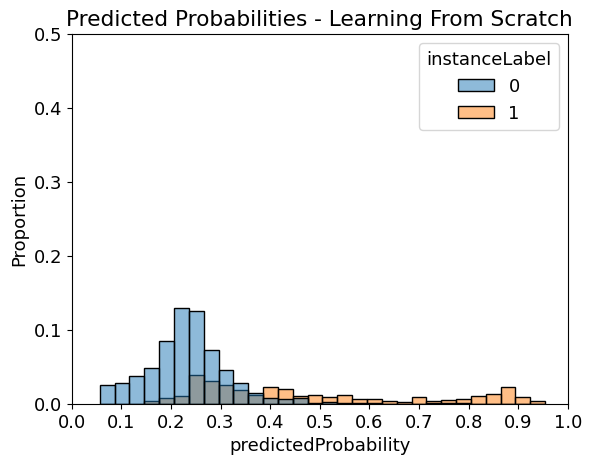

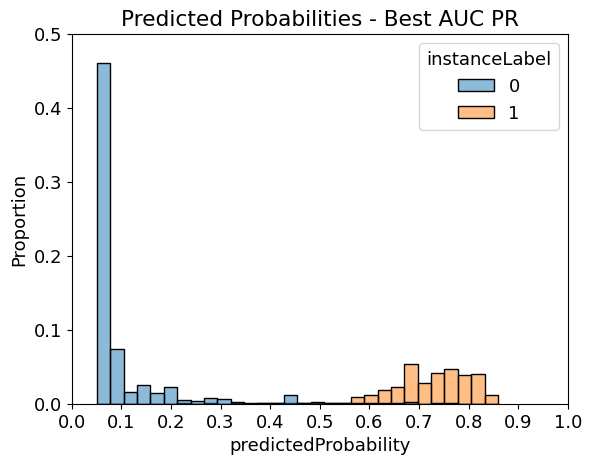

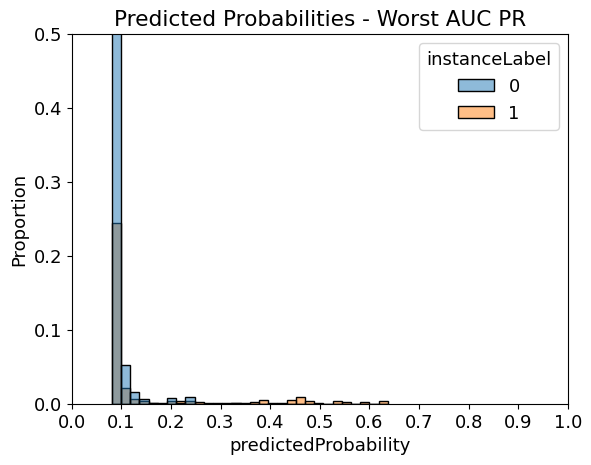

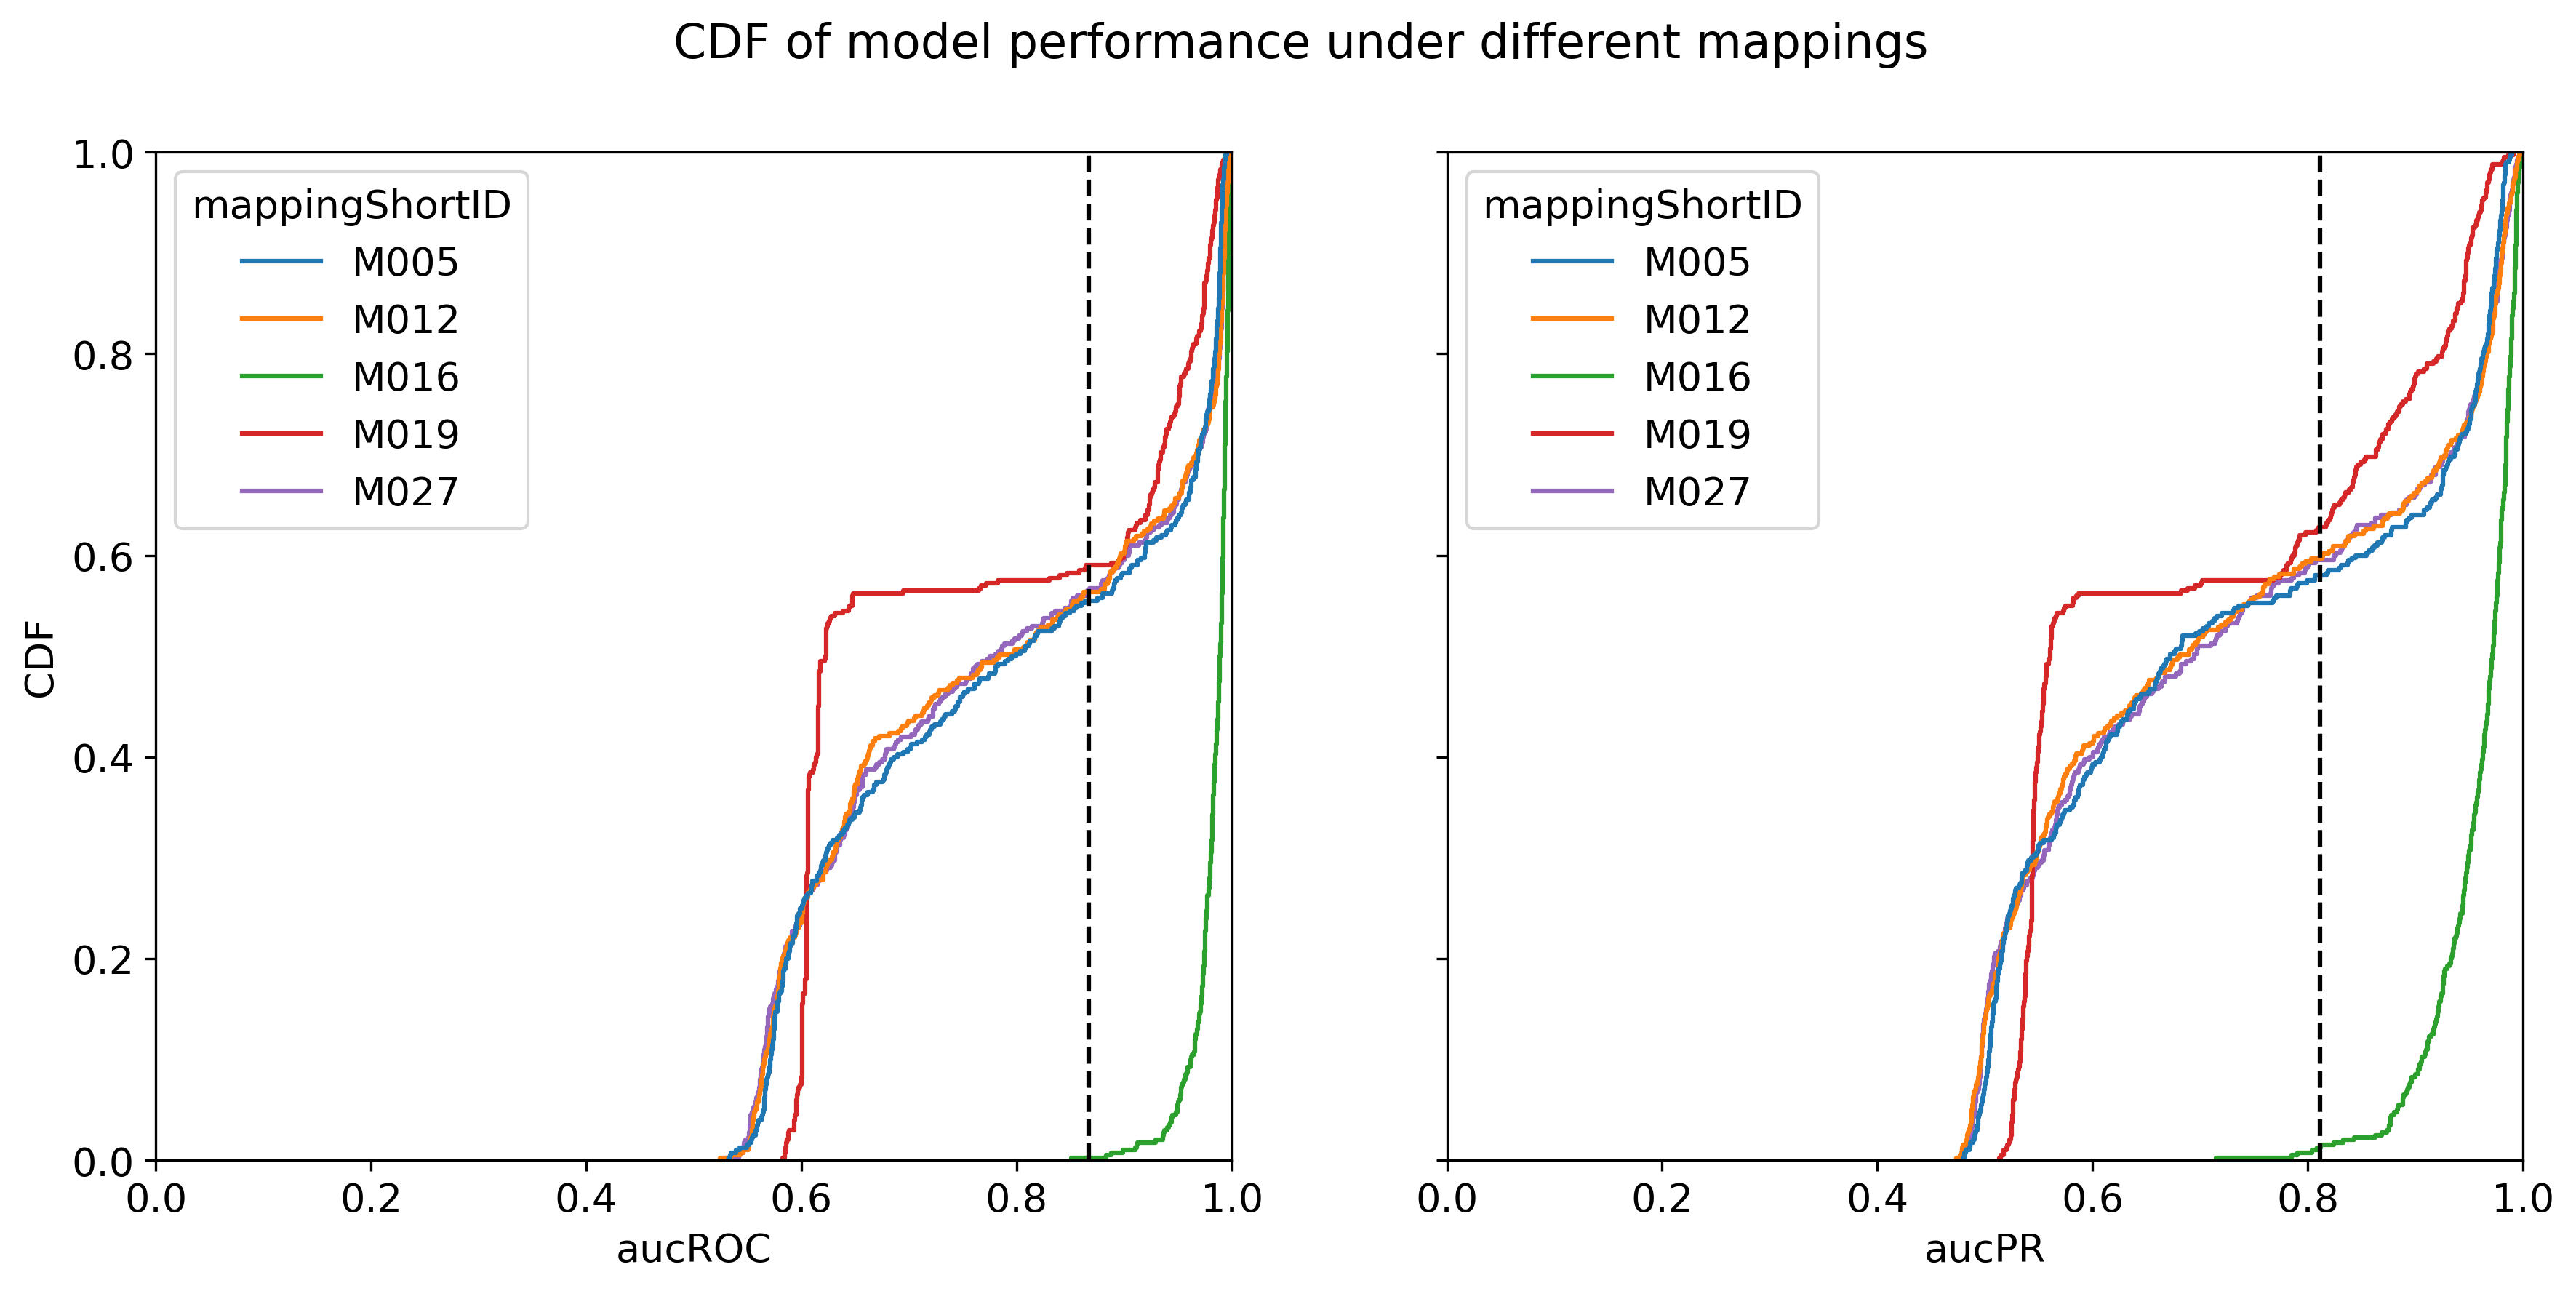

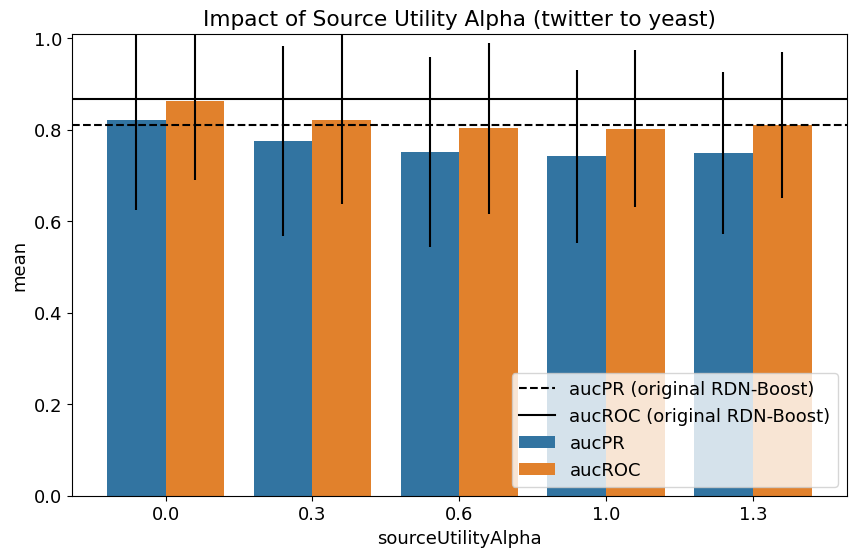

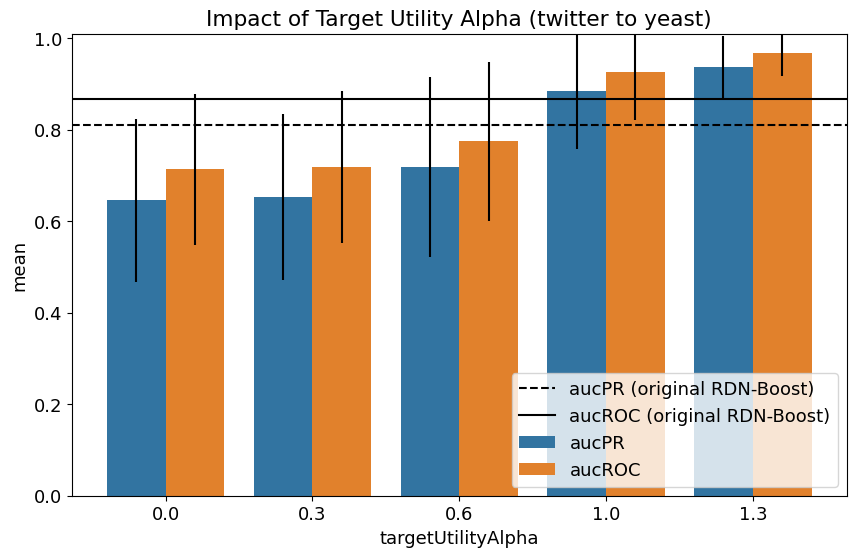

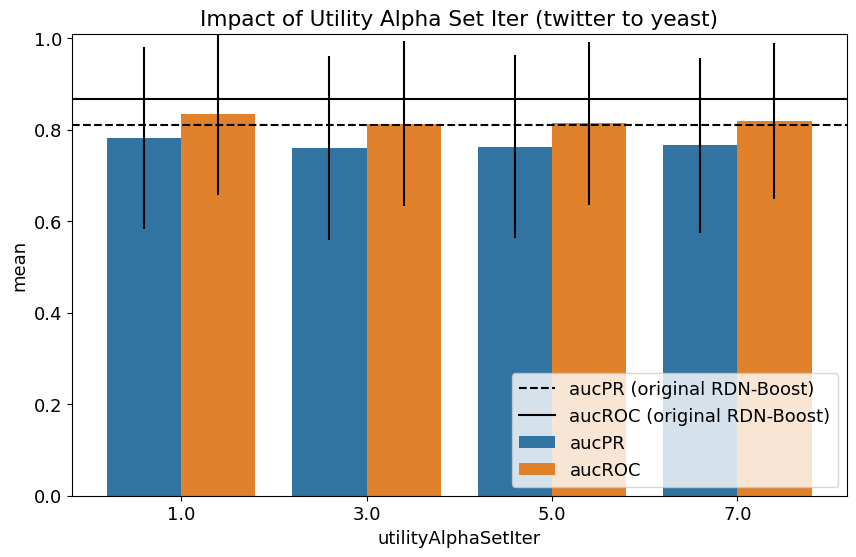

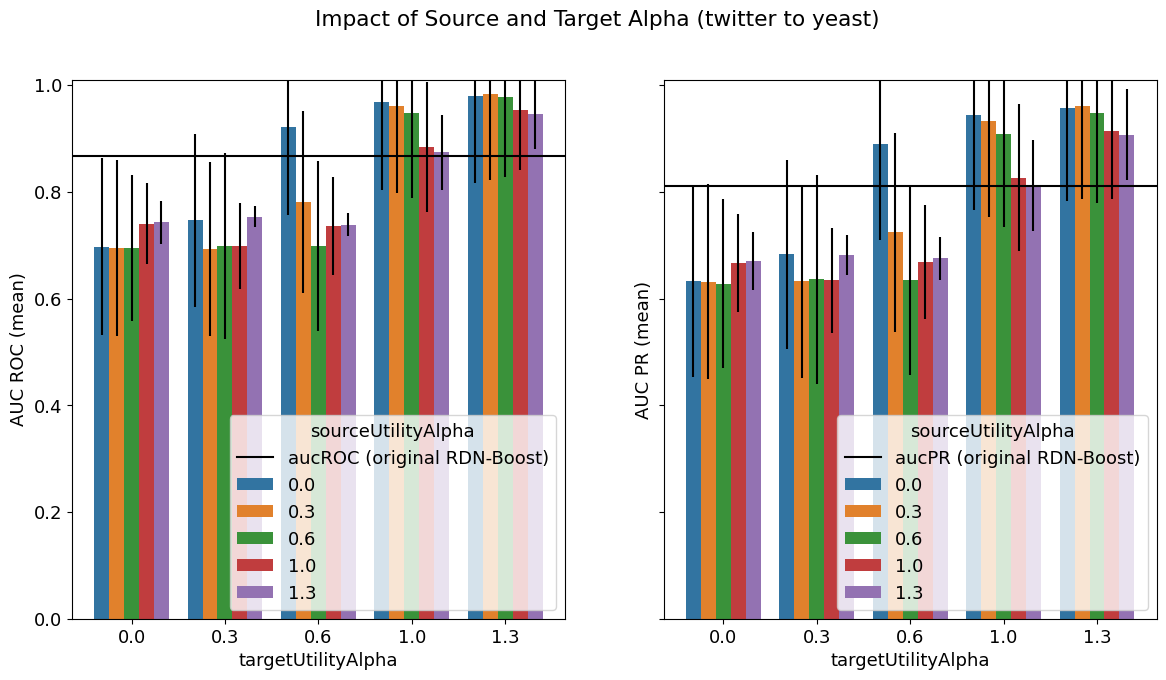

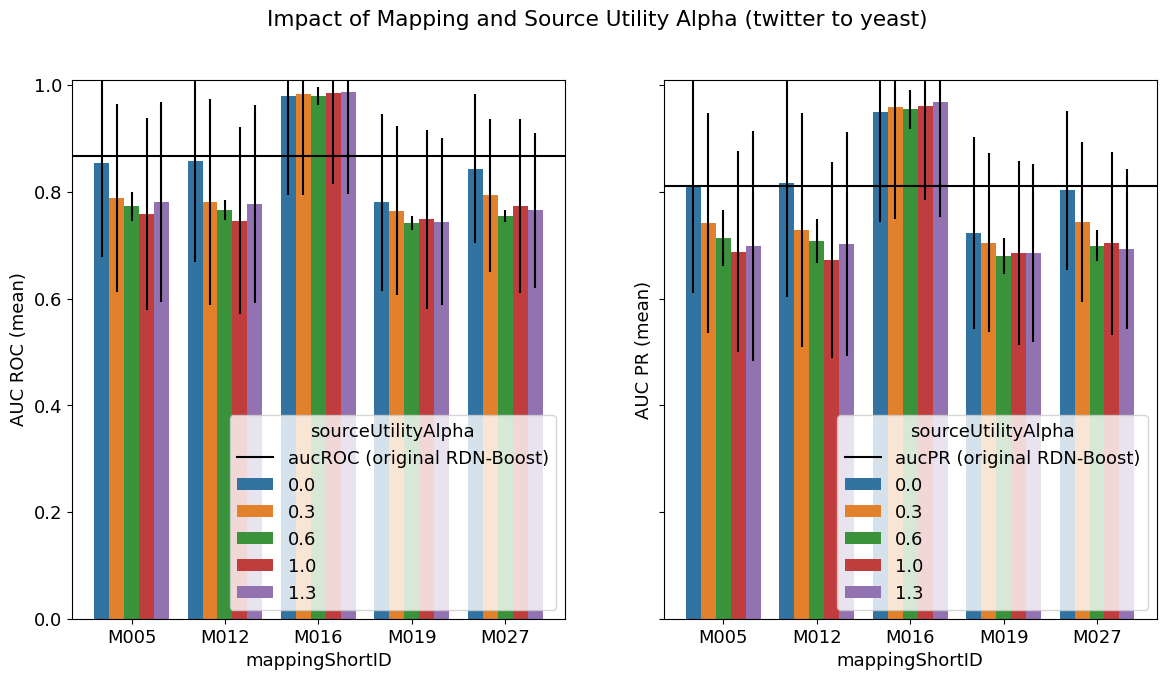

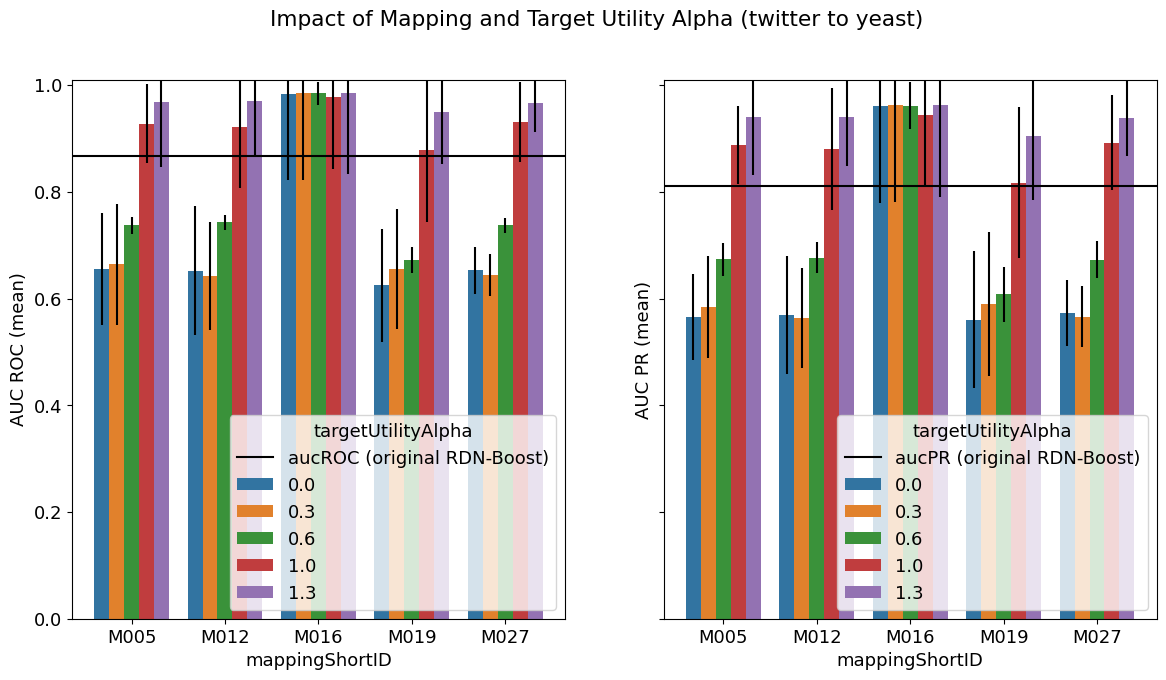

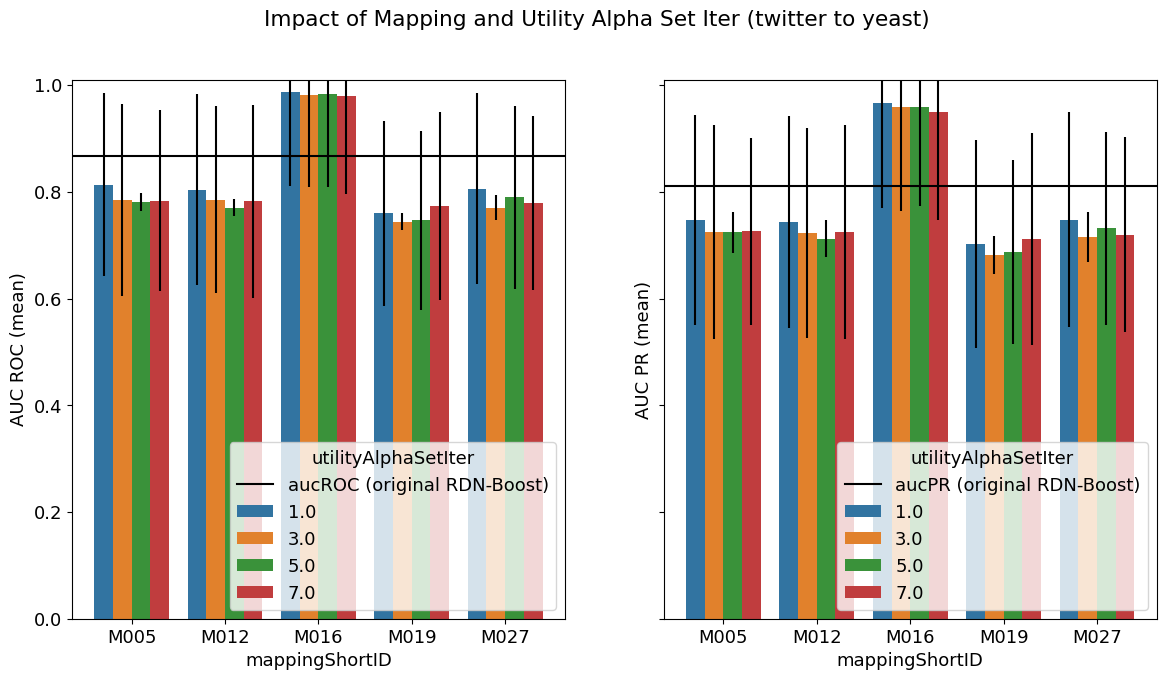

In [225]:
analysisVariables = runAnalysis("twitter", "yeast")

# **Yeast To Twitter**

Mapping Short ID: M002

Relation Mappings:
	enzyme -> accounttype
	('location', 'proteinclass', 'complex', 'phenotype') -> empty
	interaction -> follows
	recursion_enzyme -> recursion_accounttype
	function -> tweets

Term Type Mappings:
	protein -> account
	enz -> type
	fun -> word


Mapping Short ID: M013

Relation Mappings:
	function -> accounttype
	('interaction', 'proteinclass', 'complex', 'phenotype') -> empty
	enzyme -> follows
	recursion_function -> recursion_accounttype
	location -> tweets

Term Type Mappings:
	('protein', 'enz') -> account
	fun -> type
	loc -> word


Mapping Short ID: M018

Relation Mappings:
	location -> accounttype
	('interaction', 'enzyme', 'complex', 'phenotype') -> empty
	proteinclass -> follows
	recursion_location -> recursion_accounttype
	function -> tweets

Term Type Mappings:
	('protein', 'class') -> account
	loc -> type
	fun -> word


Mapping Short ID: M020

Relation Mappings:
	complex -> accounttype
	('location', 'interaction', 'proteinclass', 'func

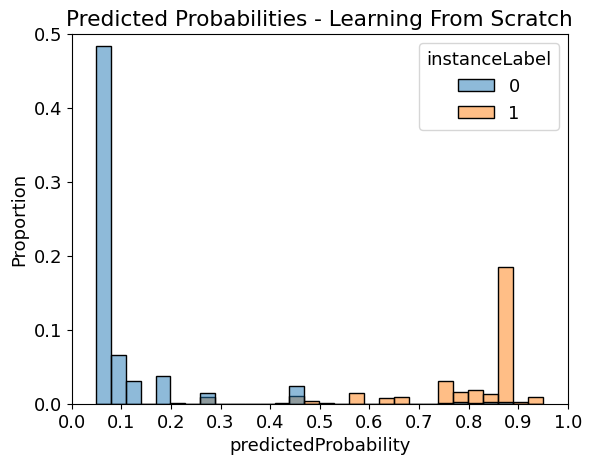

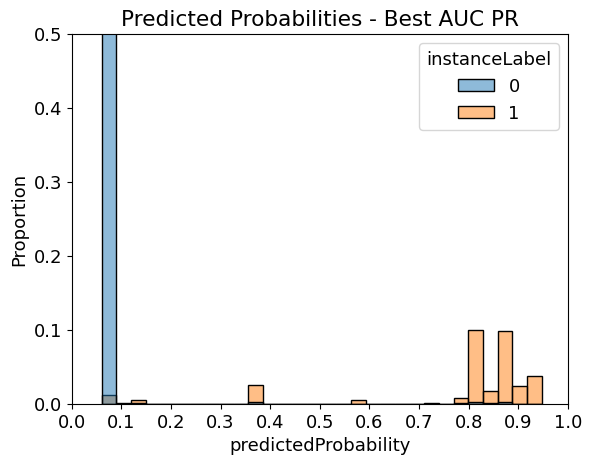

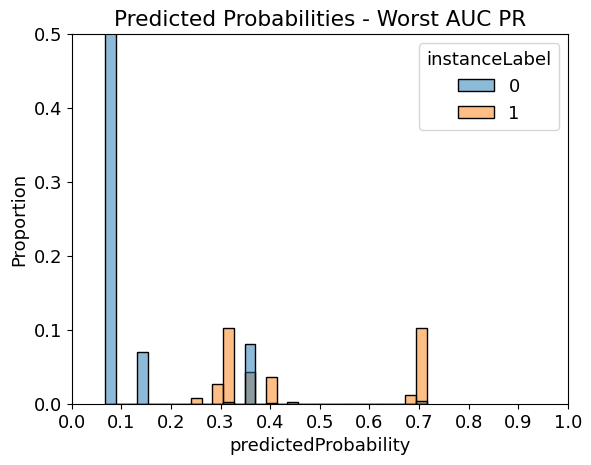

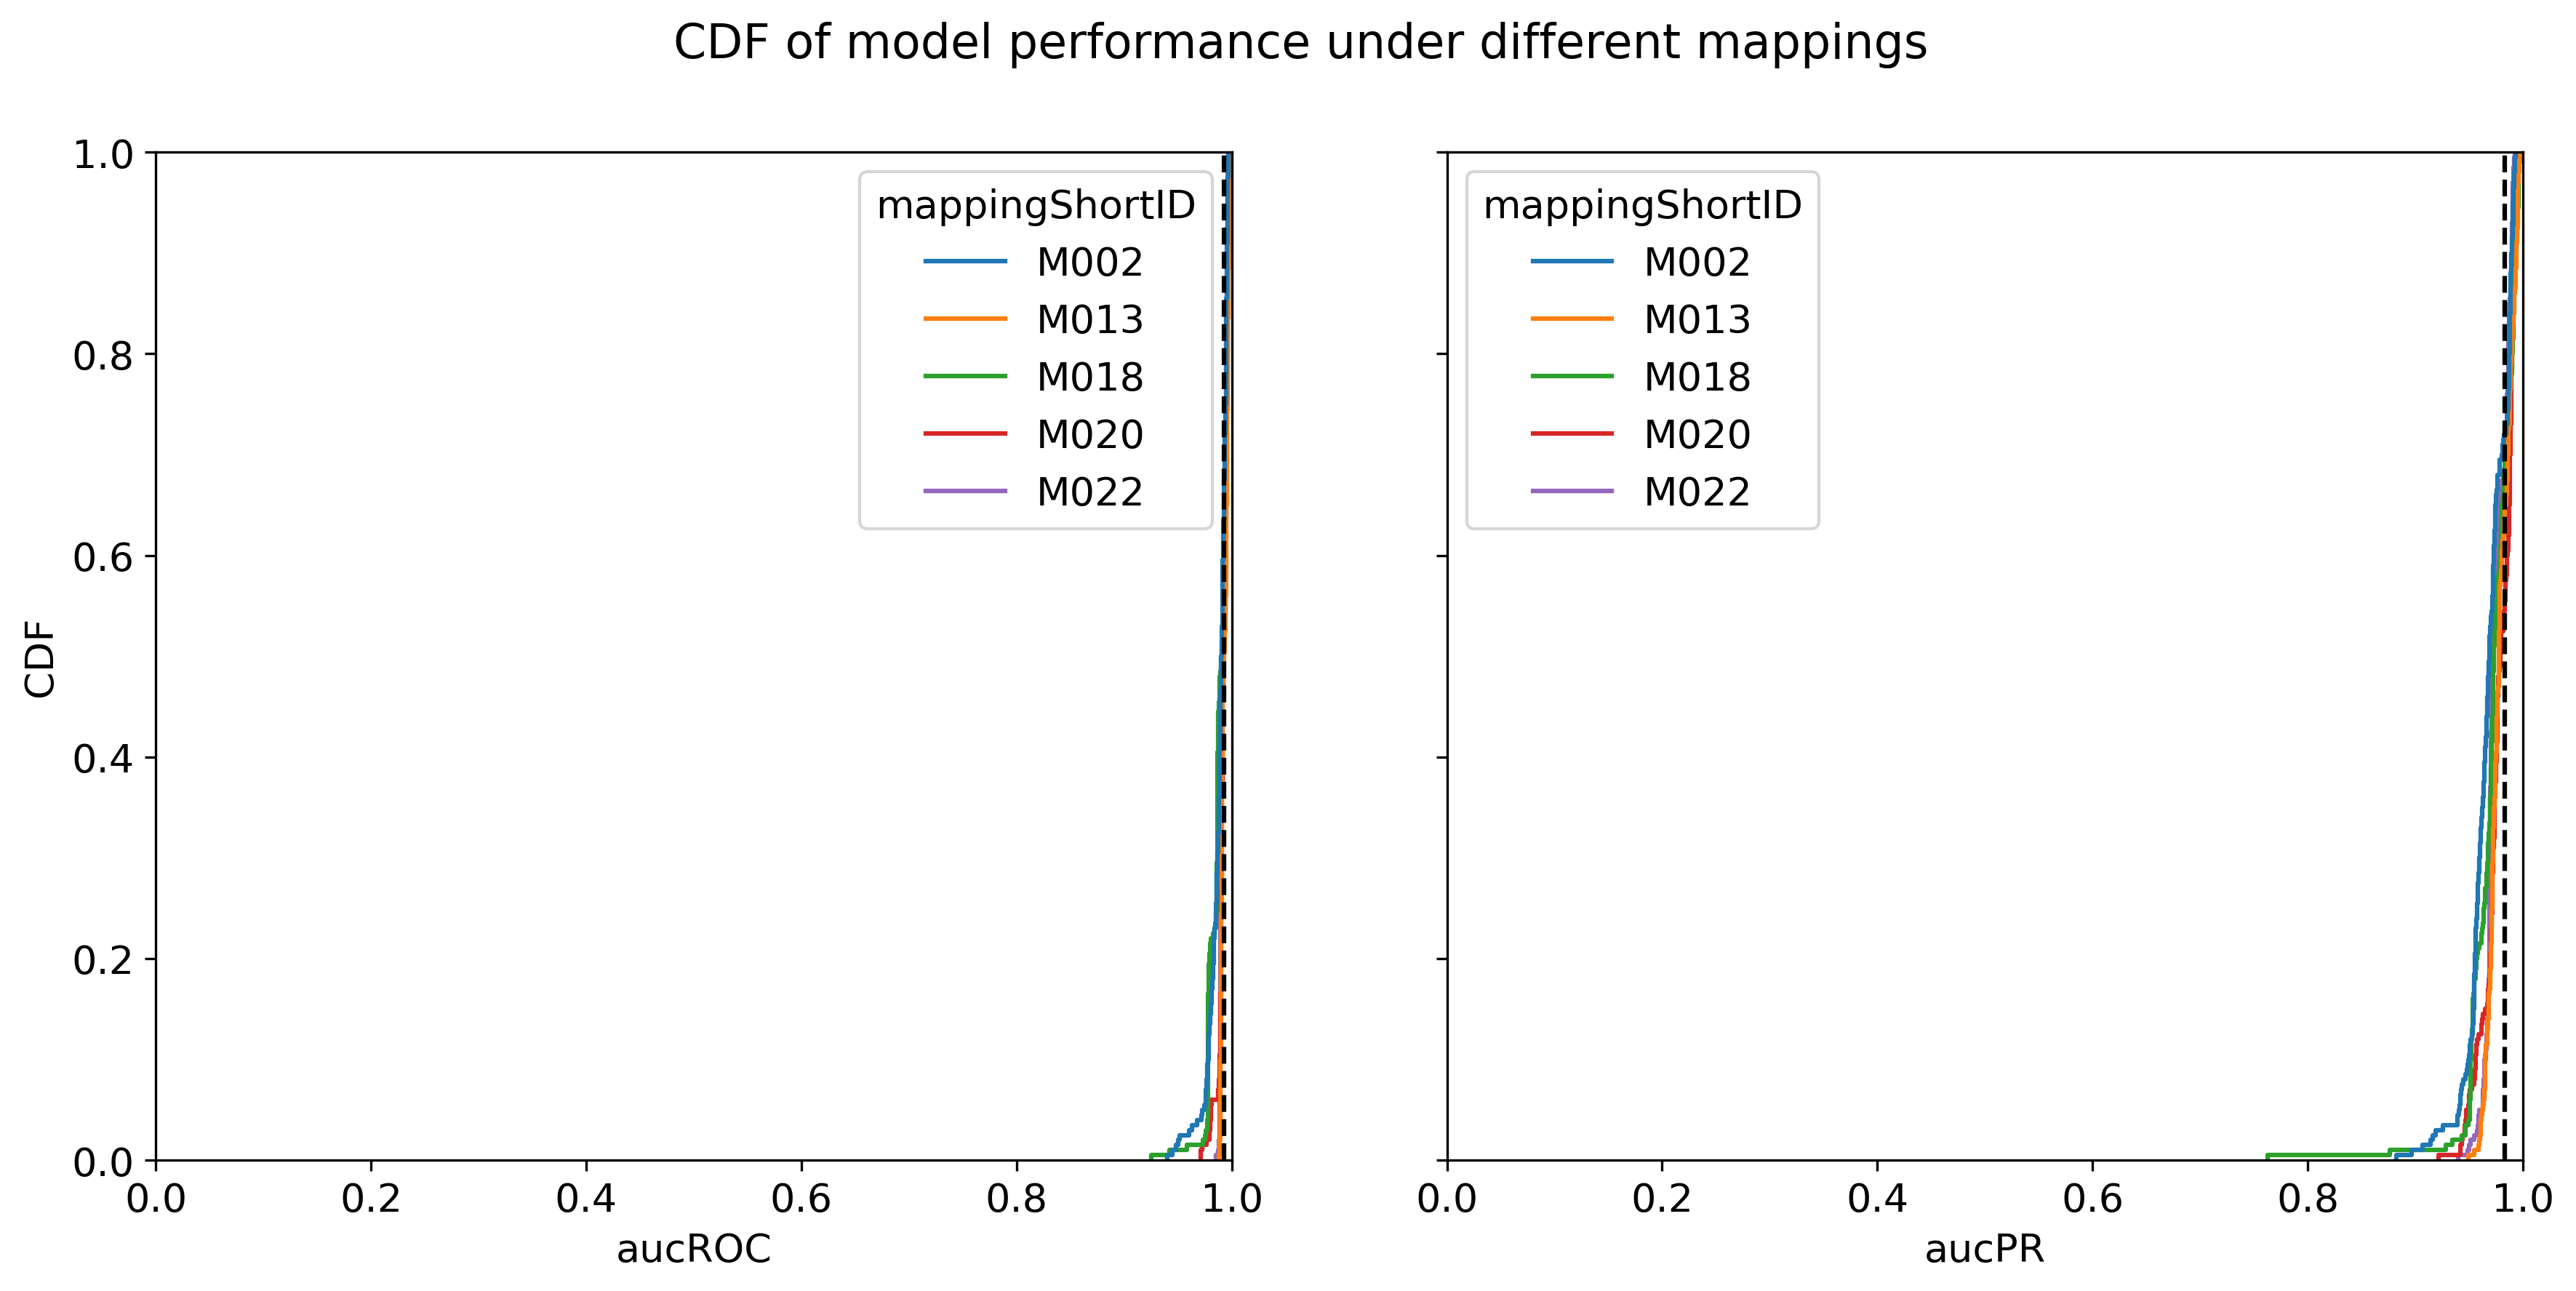

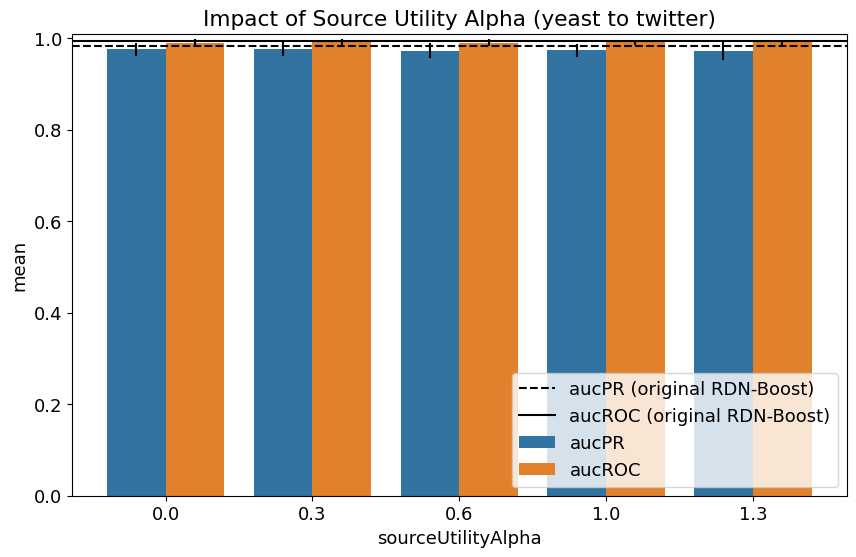

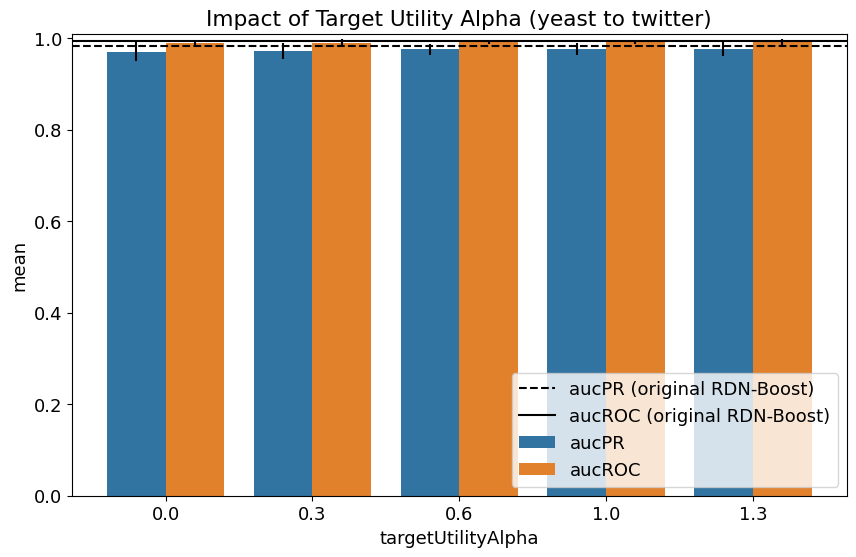

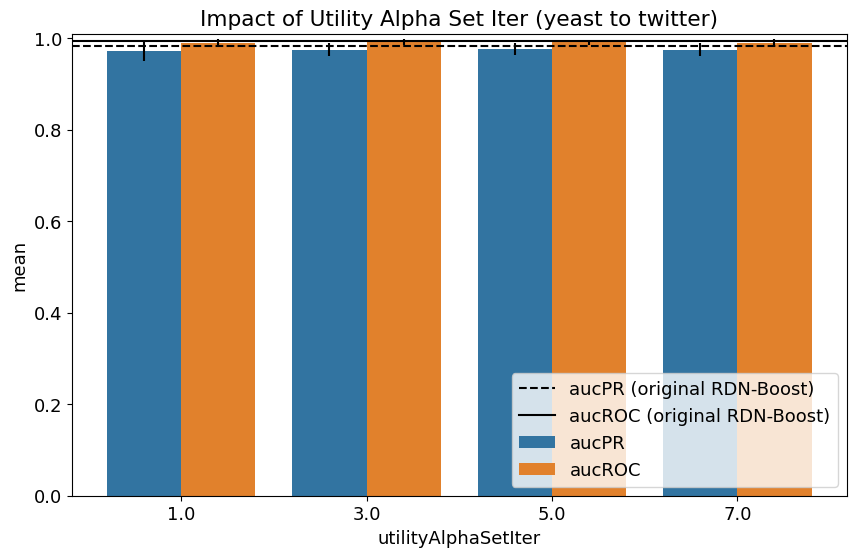

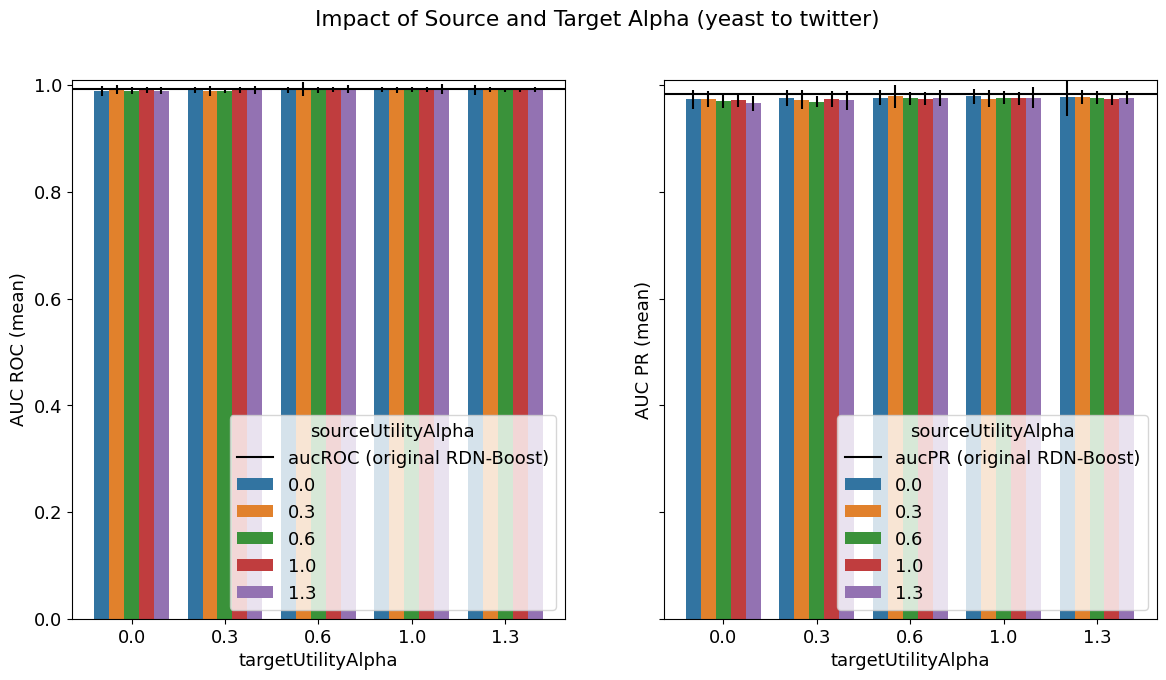

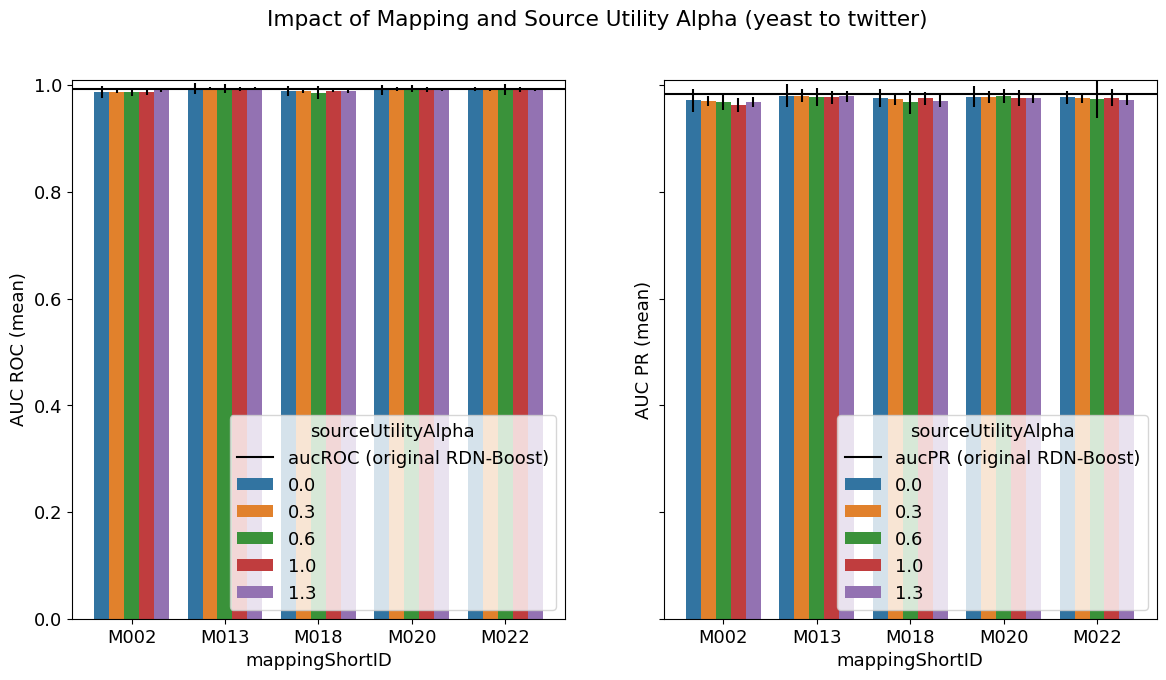

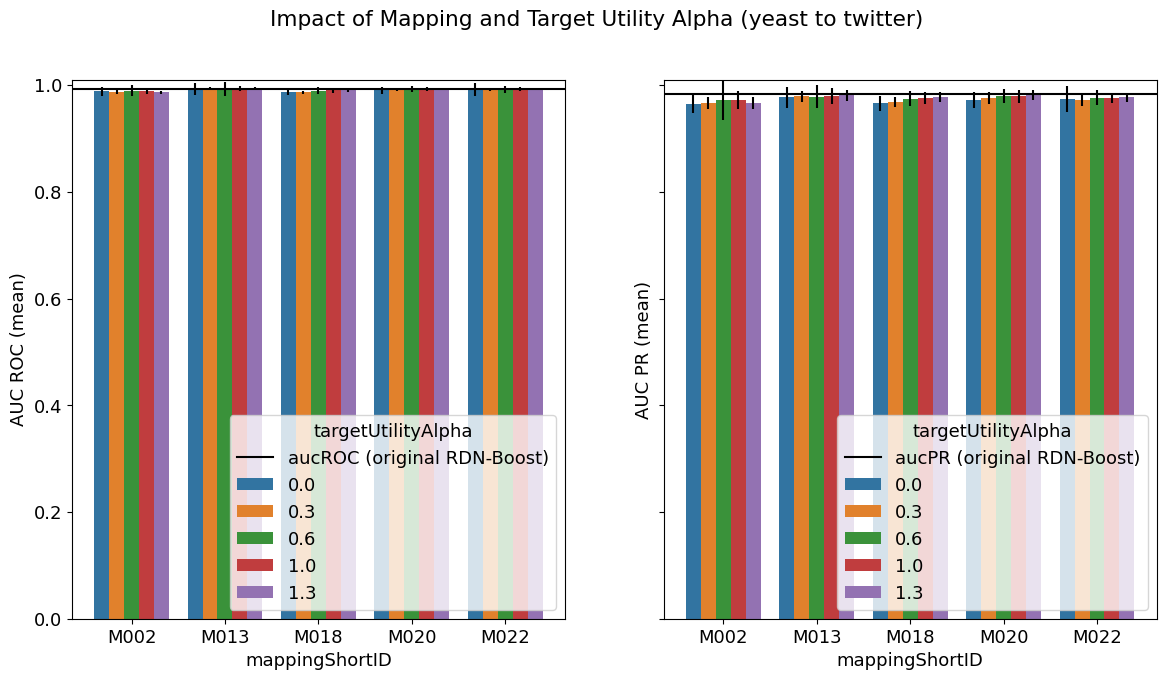

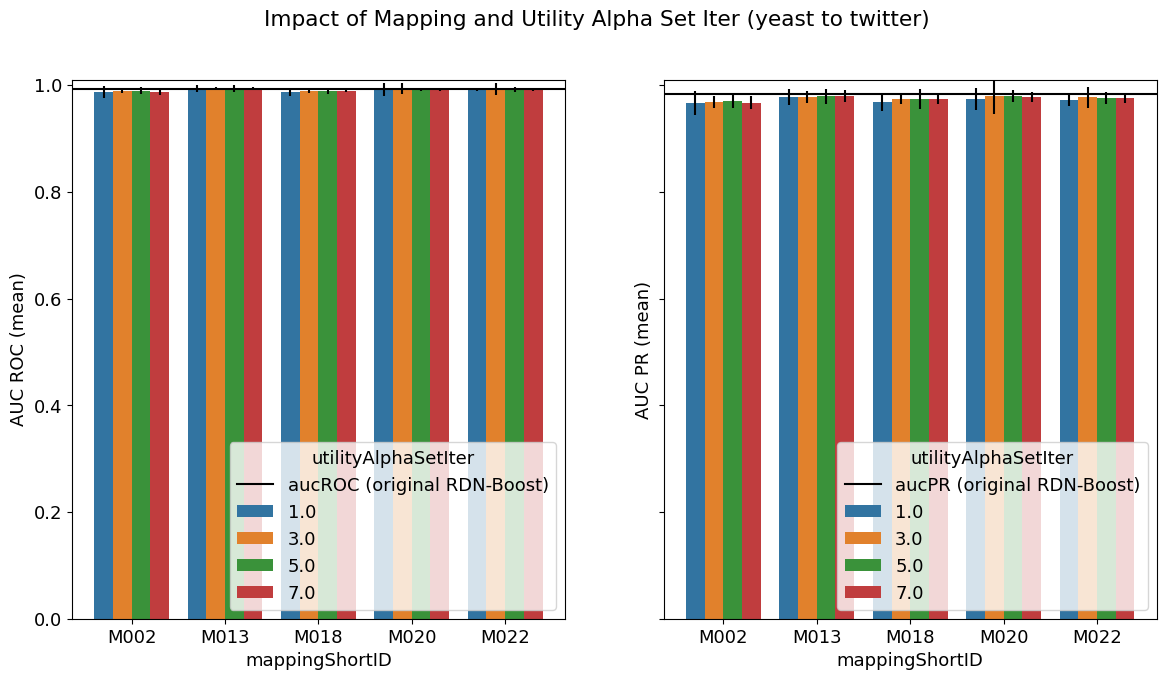

In [226]:
analysisVariables = runAnalysis("yeast", "twitter")

In [374]:
analysisVariables["sourceUtilityAlphaPerformanceDF"]

aucPR                                                    \
                    count      mean       std       min       25%       50%   
sourceUtilityAlpha                                                            
0.0                 200.0  0.976372  0.014404  0.906523  0.969871  0.977758   
0.3                 200.0  0.975674  0.015350  0.896298  0.968475  0.976229   
0.6                 200.0  0.973304  0.015532  0.876030  0.966367  0.973310   
1.0                 200.0  0.973621  0.014845  0.882139  0.966066  0.973448   
1.3                 200.0  0.973233  0.019761  0.762483  0.967367  0.972602   

                                       aucROC            ...            \
                         75%       max  count      mean  ...       75%   
sourceUtilityAlpha                                       ...             
0.0                 0.987760  0.998186  200.0  0.990630  ...  0.995343   
0.3                 0.988382  0.996548  200.0  0.991019  ...  0.995418   
0.6                 0.986552  0.996969  200.0  0.990298  ...  0.994929   
1.0                 0.986503  0.995885  200.0  0.991007  ...  0.995024   
1.3                 0.986319  0.995726  200.0  0.991120  ...  0.995000   

                                cll                                          \
                         max  count      mean       std       min       25%   
sourceUtilityAlpha                                                            
0.0                 0.999118  200.0 -0.210647  0.077117 -0.529302 -0.237904   
0.3                 0.998425  200.0 -0.198120  0.062488 -0.488707 -0.228169   
0.6                 0.998630  200.0 -0.195220  0.056296 -0.413090 -0.223544   
1.0                 0.998142  200.0 -0.183288  0.047037 -0.354046 -0.208856   
1.3                 0.998079  200.0 -0.182157  0.050749 -0.452674 -0.203868   

                                                  
                         50%       75%       max  
sourceUtilityAlpha                                
0.0                -0.195487 -0.155373 -0.110133  
0.3                -0.189324 -0.155729 -0.105142  
0.6                -0.181914 -0.155345 -0.108671  
1.0                -0.178250 -0.148265 -0.099014  
1.3                -0.175437 -0.146554 -0.108167  

[5 rows x 24 columns]

# **NELL Sports To NELL Finances**

Mapping Short ID: M006

Relation Mappings:
	athleteledsportsteam -> acquired
	teamplaysagainstteam -> bankboughtbank
	teamplaysinleague -> bankchiefexecutiveceo
	teamalsoknownas -> companyalsoknownas
	athleteplayssport -> companyeconomicsector
	('athleteplaysforteam', 'athleteplaysinleague', 'teamplayssport') -> empty
	recursion_athleteplayssport -> recursion_companyeconomicsector

Term Type Mappings:
	('athlete', 'sportsteam') -> company
	sportsleague -> person
	sport -> sector


Mapping Short ID: M008

Relation Mappings:
	athleteplaysforteam -> acquired
	teamalsoknownas -> bankboughtbank
	teamplaysagainstteam -> companyalsoknownas
	athleteplayssport -> companyceo
	teamplaysinleague -> companyeconomicsector
	('athleteledsportsteam', 'athleteplaysinleague', 'teamplayssport') -> empty
	recursion_teamplaysinleague -> recursion_companyeconomicsector

Term Type Mappings:
	('sportsteam', 'athlete') -> company
	sport -> person
	sportsleague -> sector


Mapping Short ID: M009

Relation Mappin

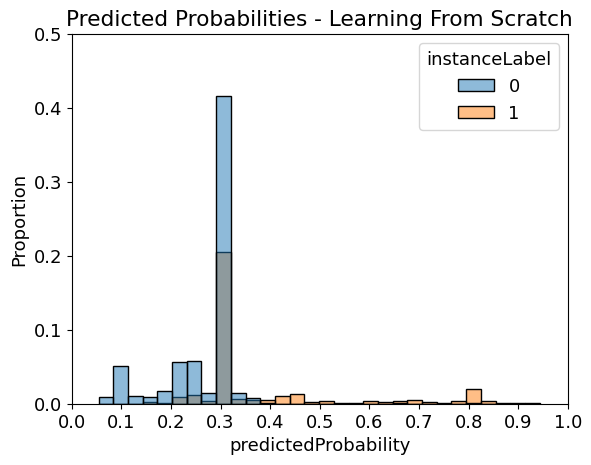

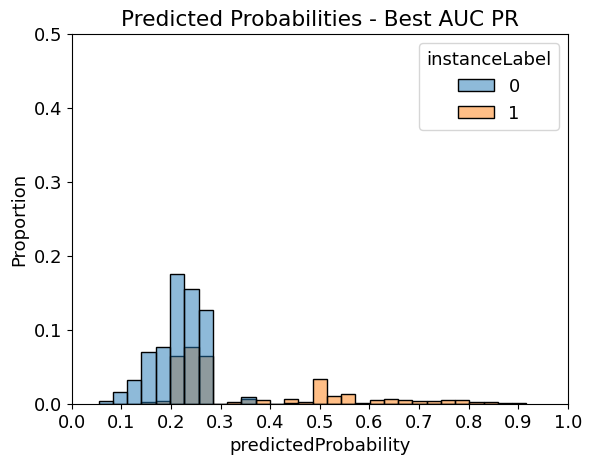

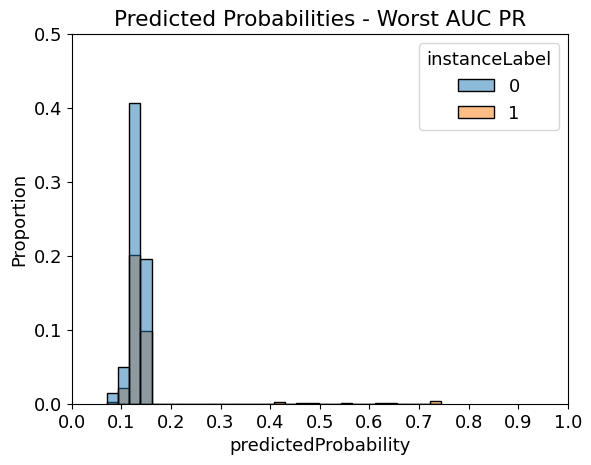

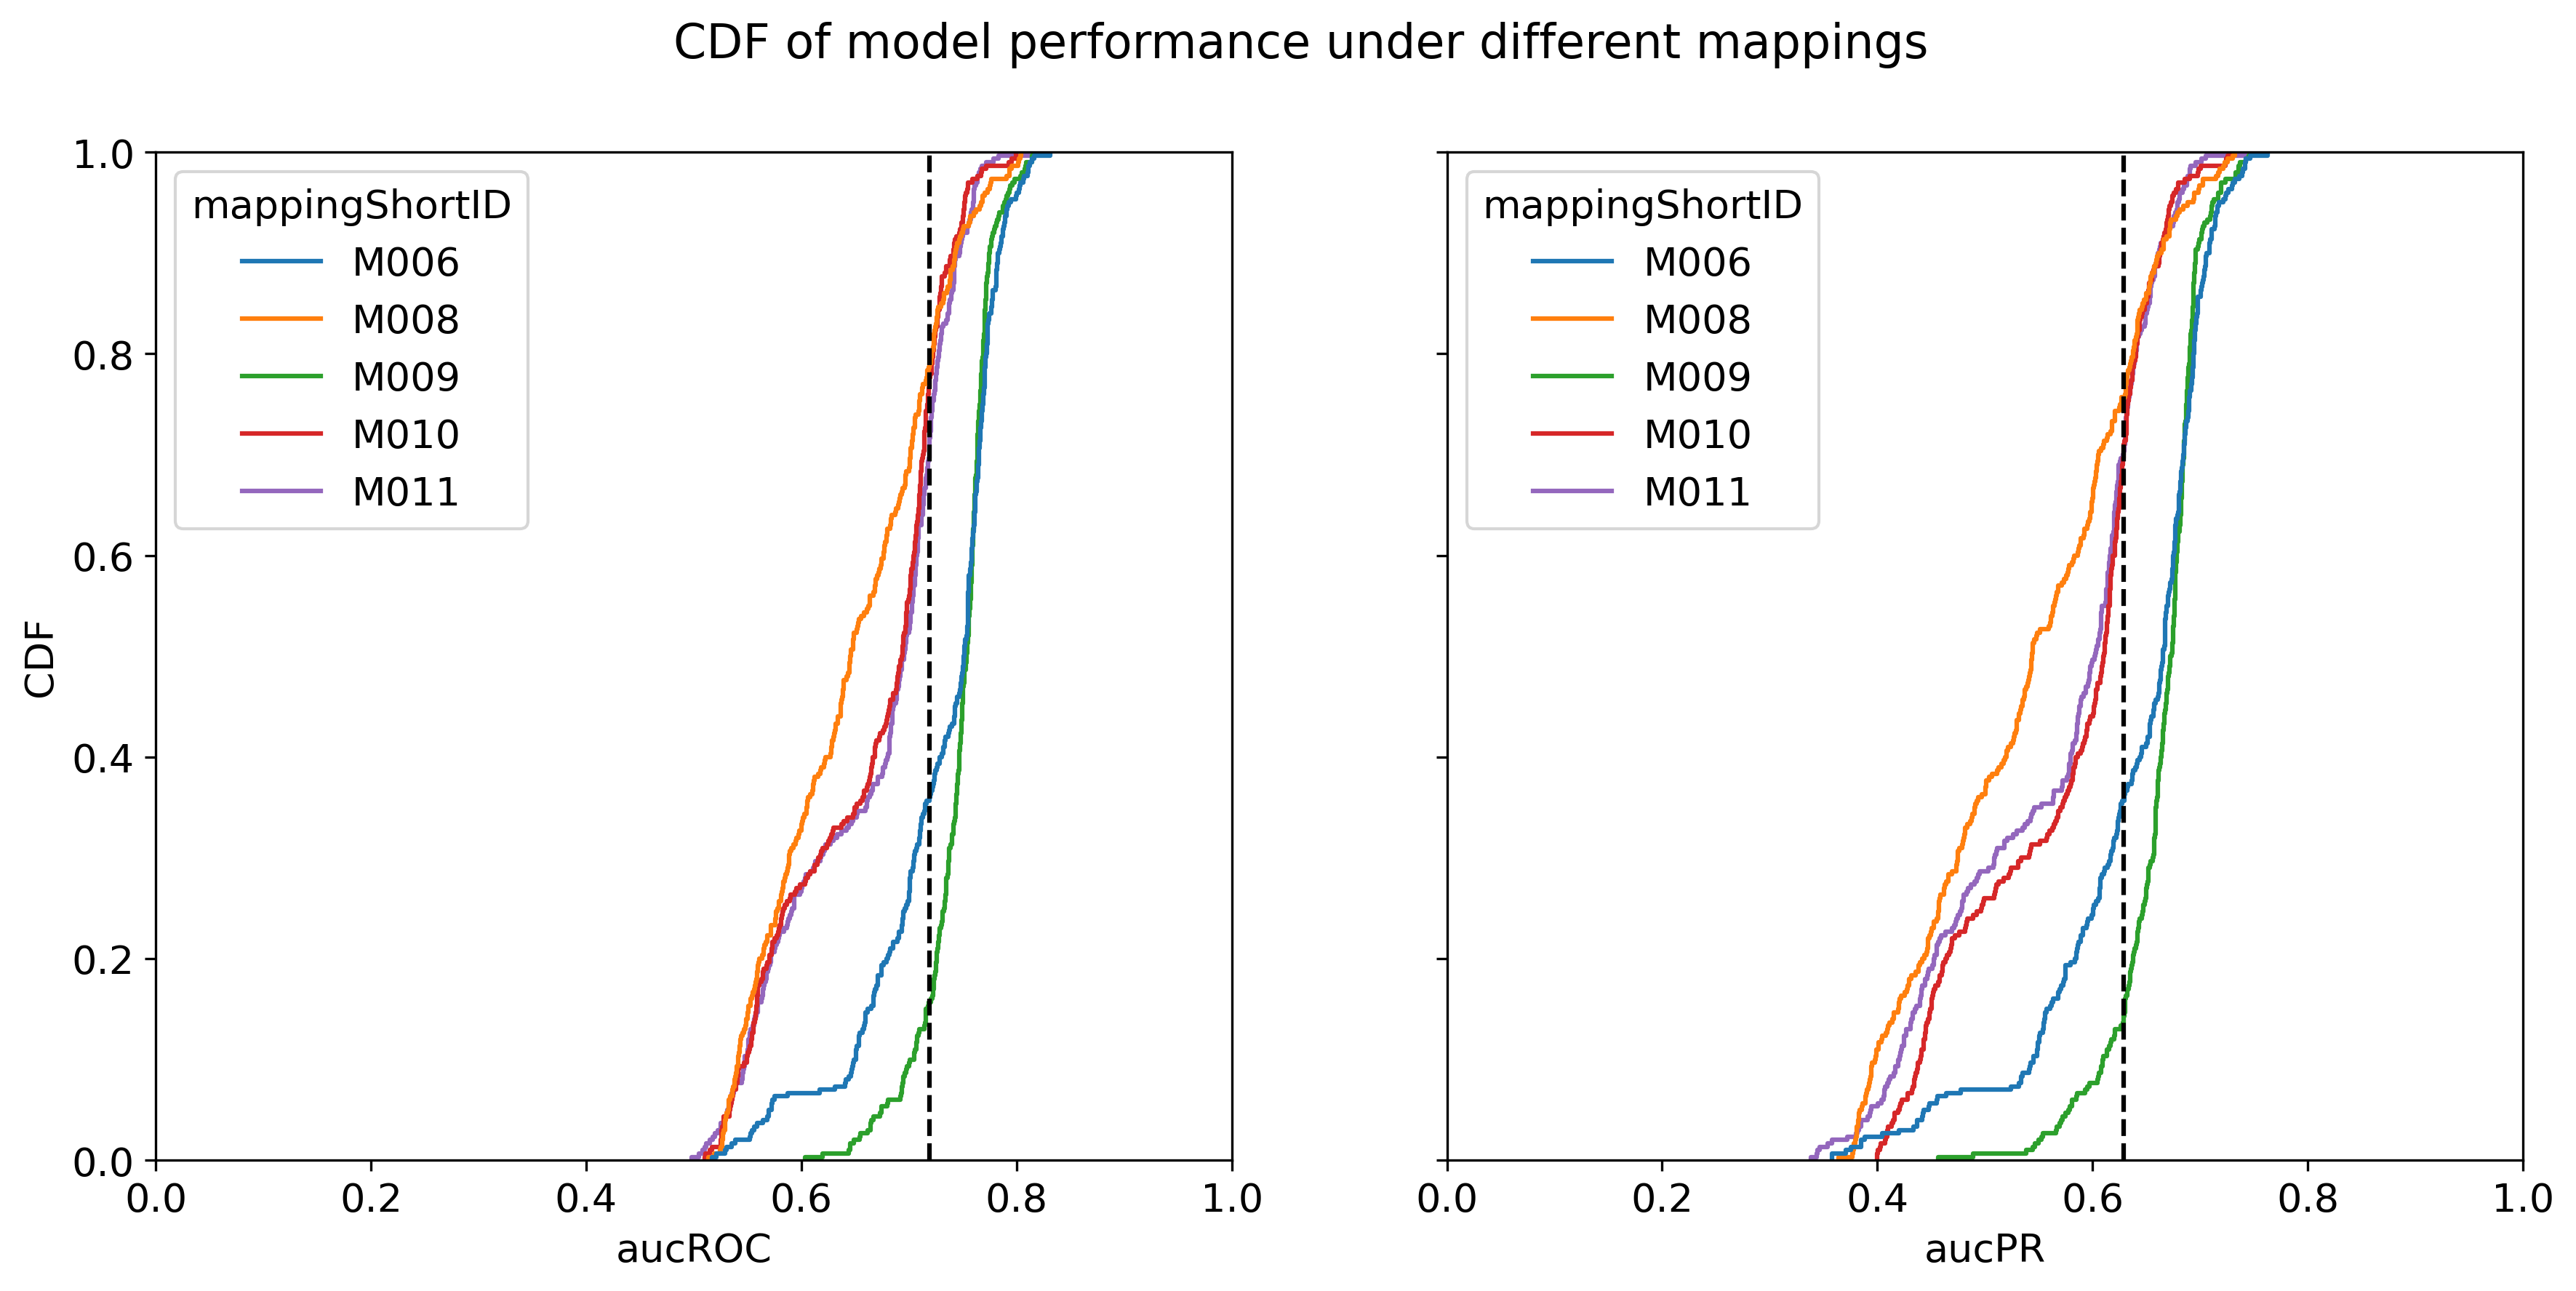

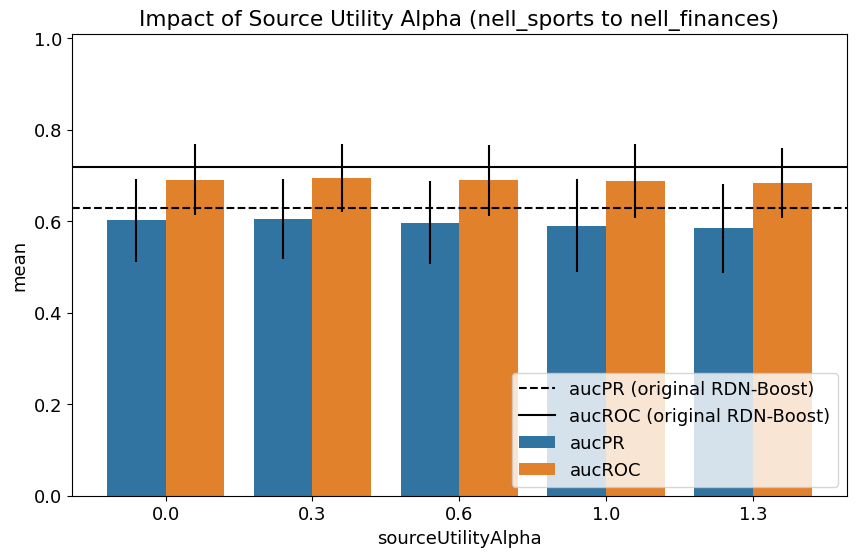

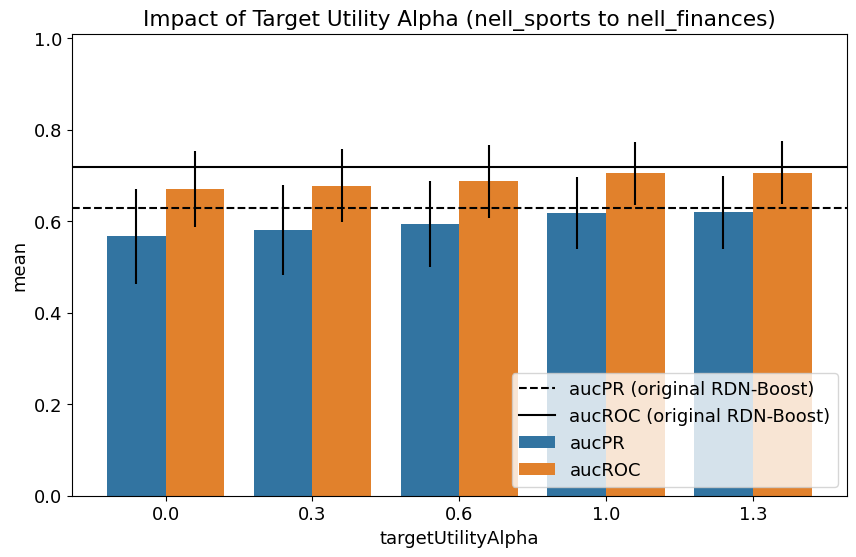

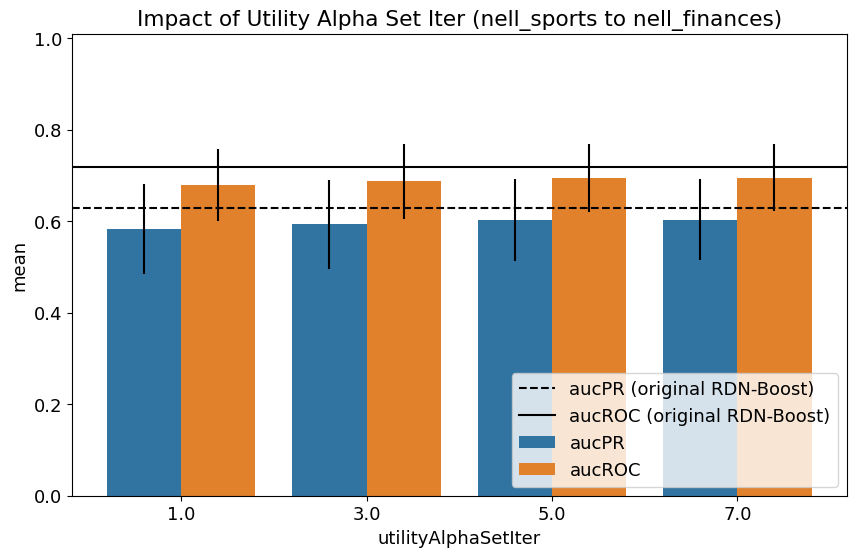

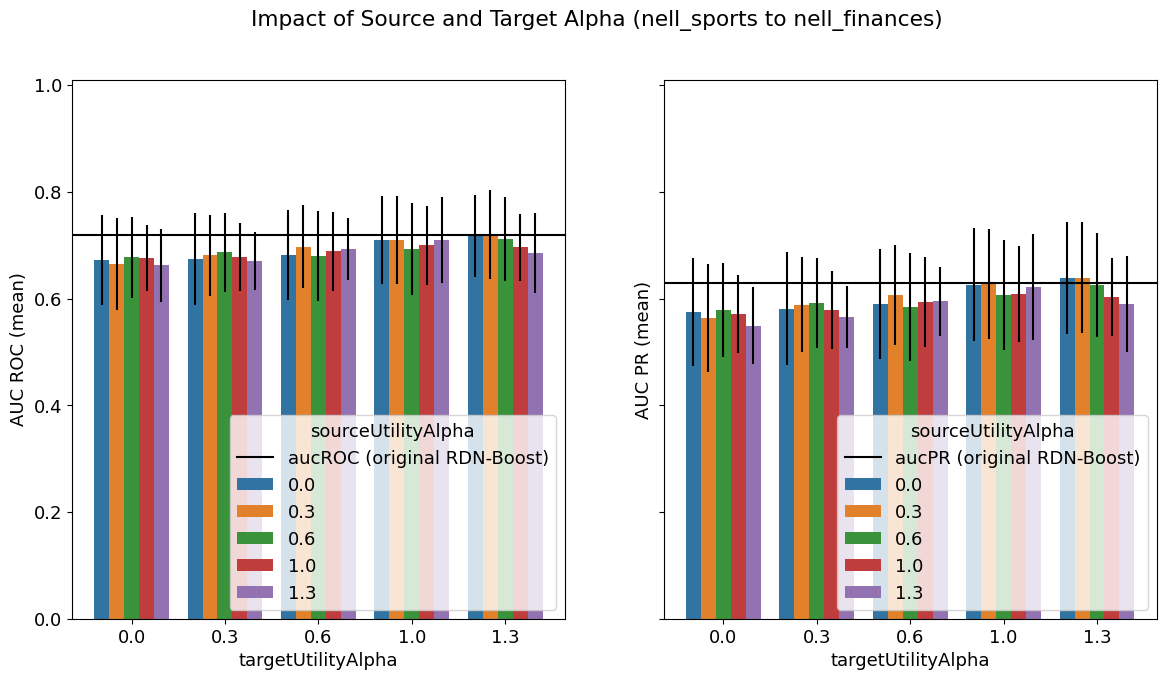

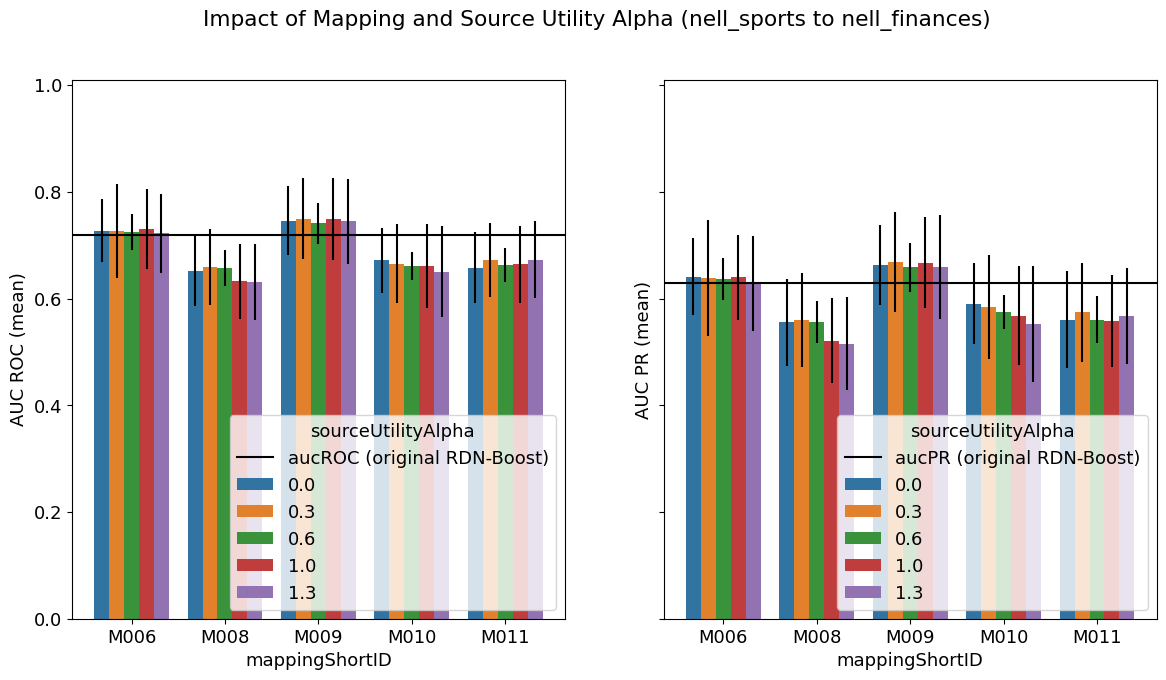

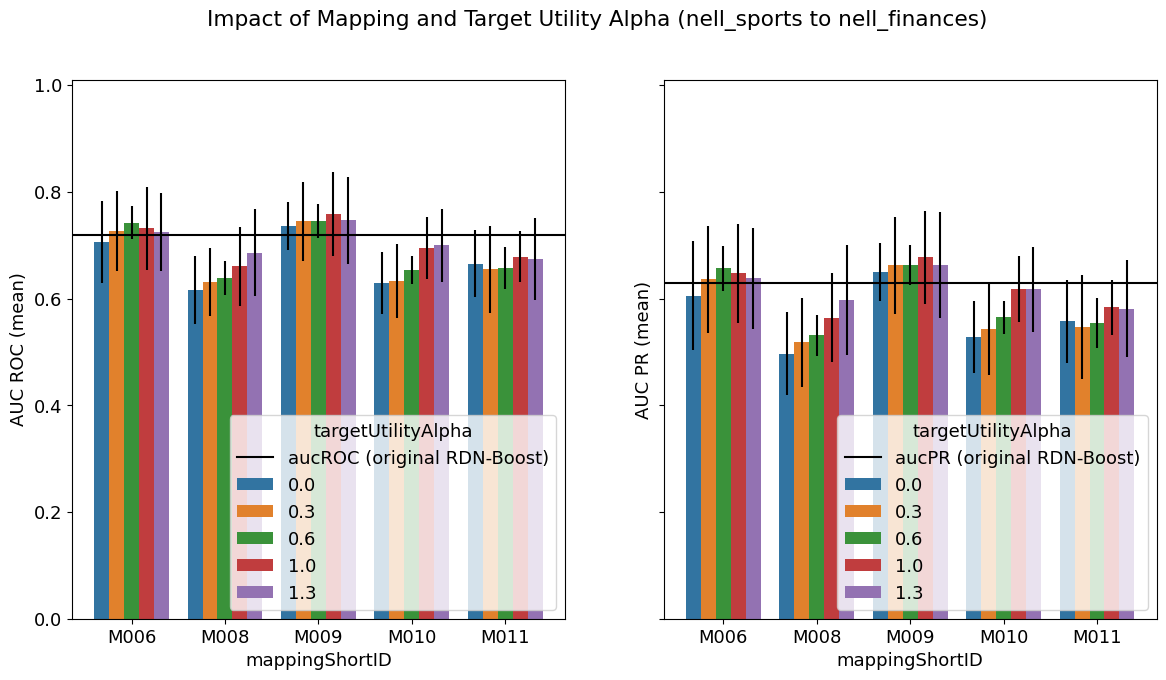

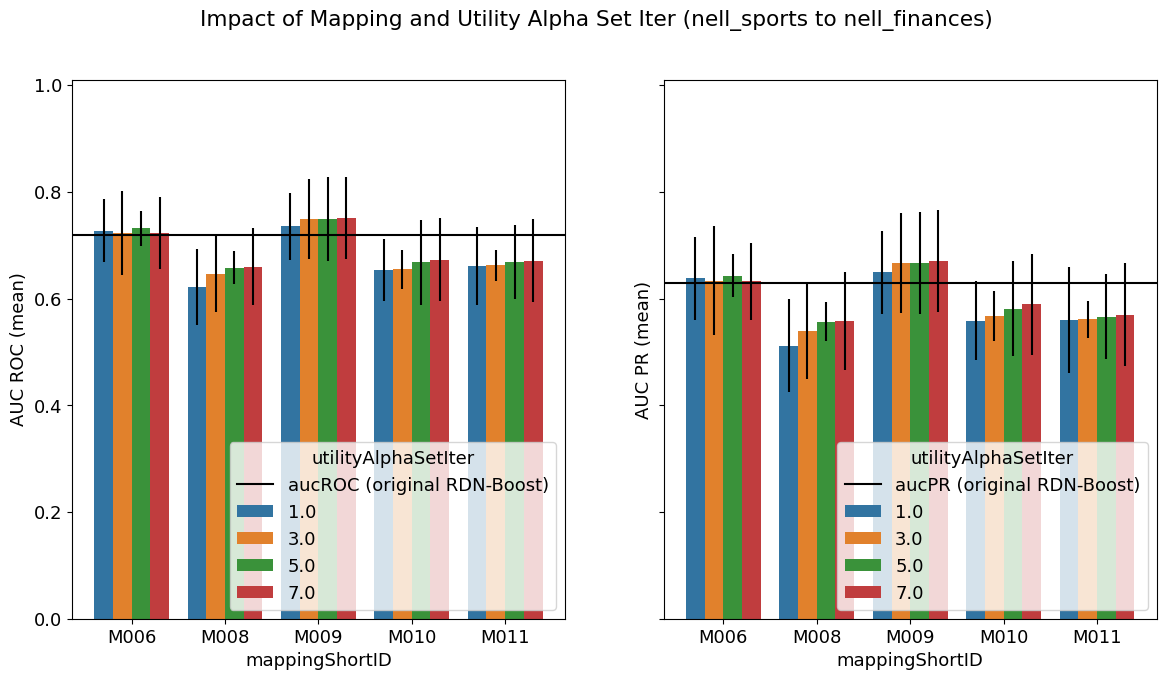

In [227]:
analysisVariables = runAnalysis("nell_sports", "nell_finances")

# **NELL Finances To NELL Sports**

In [165]:
transferLearningDF.iloc[0].id

'0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6fc661145e67a637b6b'

Mapping Short ID: M001

Relation Mappings:
	cityhascompanyoffice -> athleteledsportsteam
	economicsectorcompany -> athleteplaysforteam
	('countryhascompanyoffice', 'companyeconomicsector', 'acquired', 'bankboughtbank', 'bankchiefexecutiveceo') -> empty
	recursion_bankbankincountry -> recursion_teamplayssport
	companyceo -> teamalsoknownas
	companyalsoknownas -> teamplaysagainstteam
	bankbankincountry -> teamplayssport

Term Type Mappings:
	('sector', 'city') -> athlete
	country -> sport
	('person', 'company') -> sportsteam


Mapping Short ID: M007

Relation Mappings:
	cityhascompanyoffice -> athleteplaysforteam
	('economicsectorcompany', 'companyalsoknownas', 'acquired', 'bankbankincountry', 'bankboughtbank', 'bankchiefexecutiveceo') -> empty
	recursion_companyceo -> recursion_teamplayssport
	countryhascompanyoffice -> teamalsoknownas
	companyeconomicsector -> teamplaysagainstteam
	companyceo -> teamplayssport

Term Type Mappings:
	city -> athlete
	person -> sport
	('company', 'country

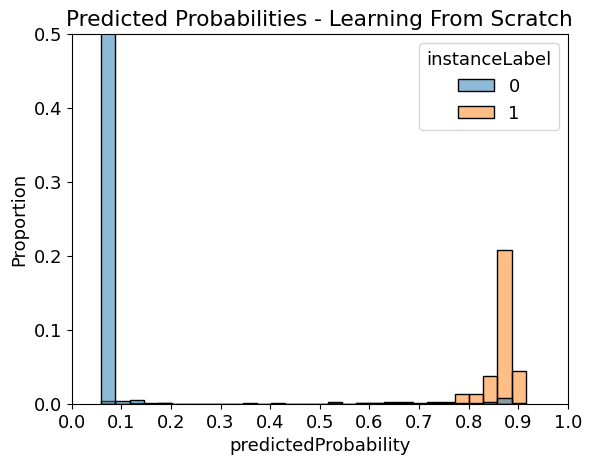

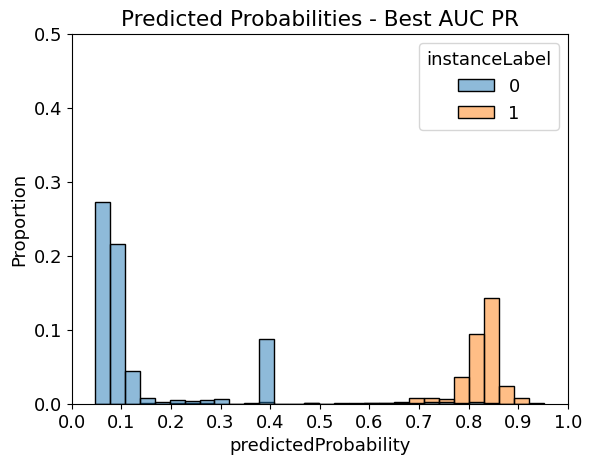

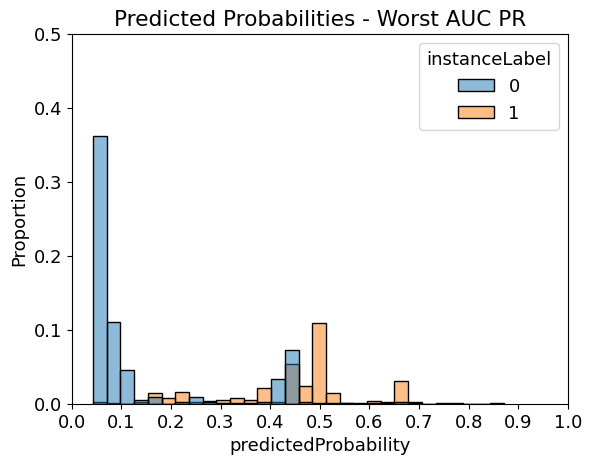

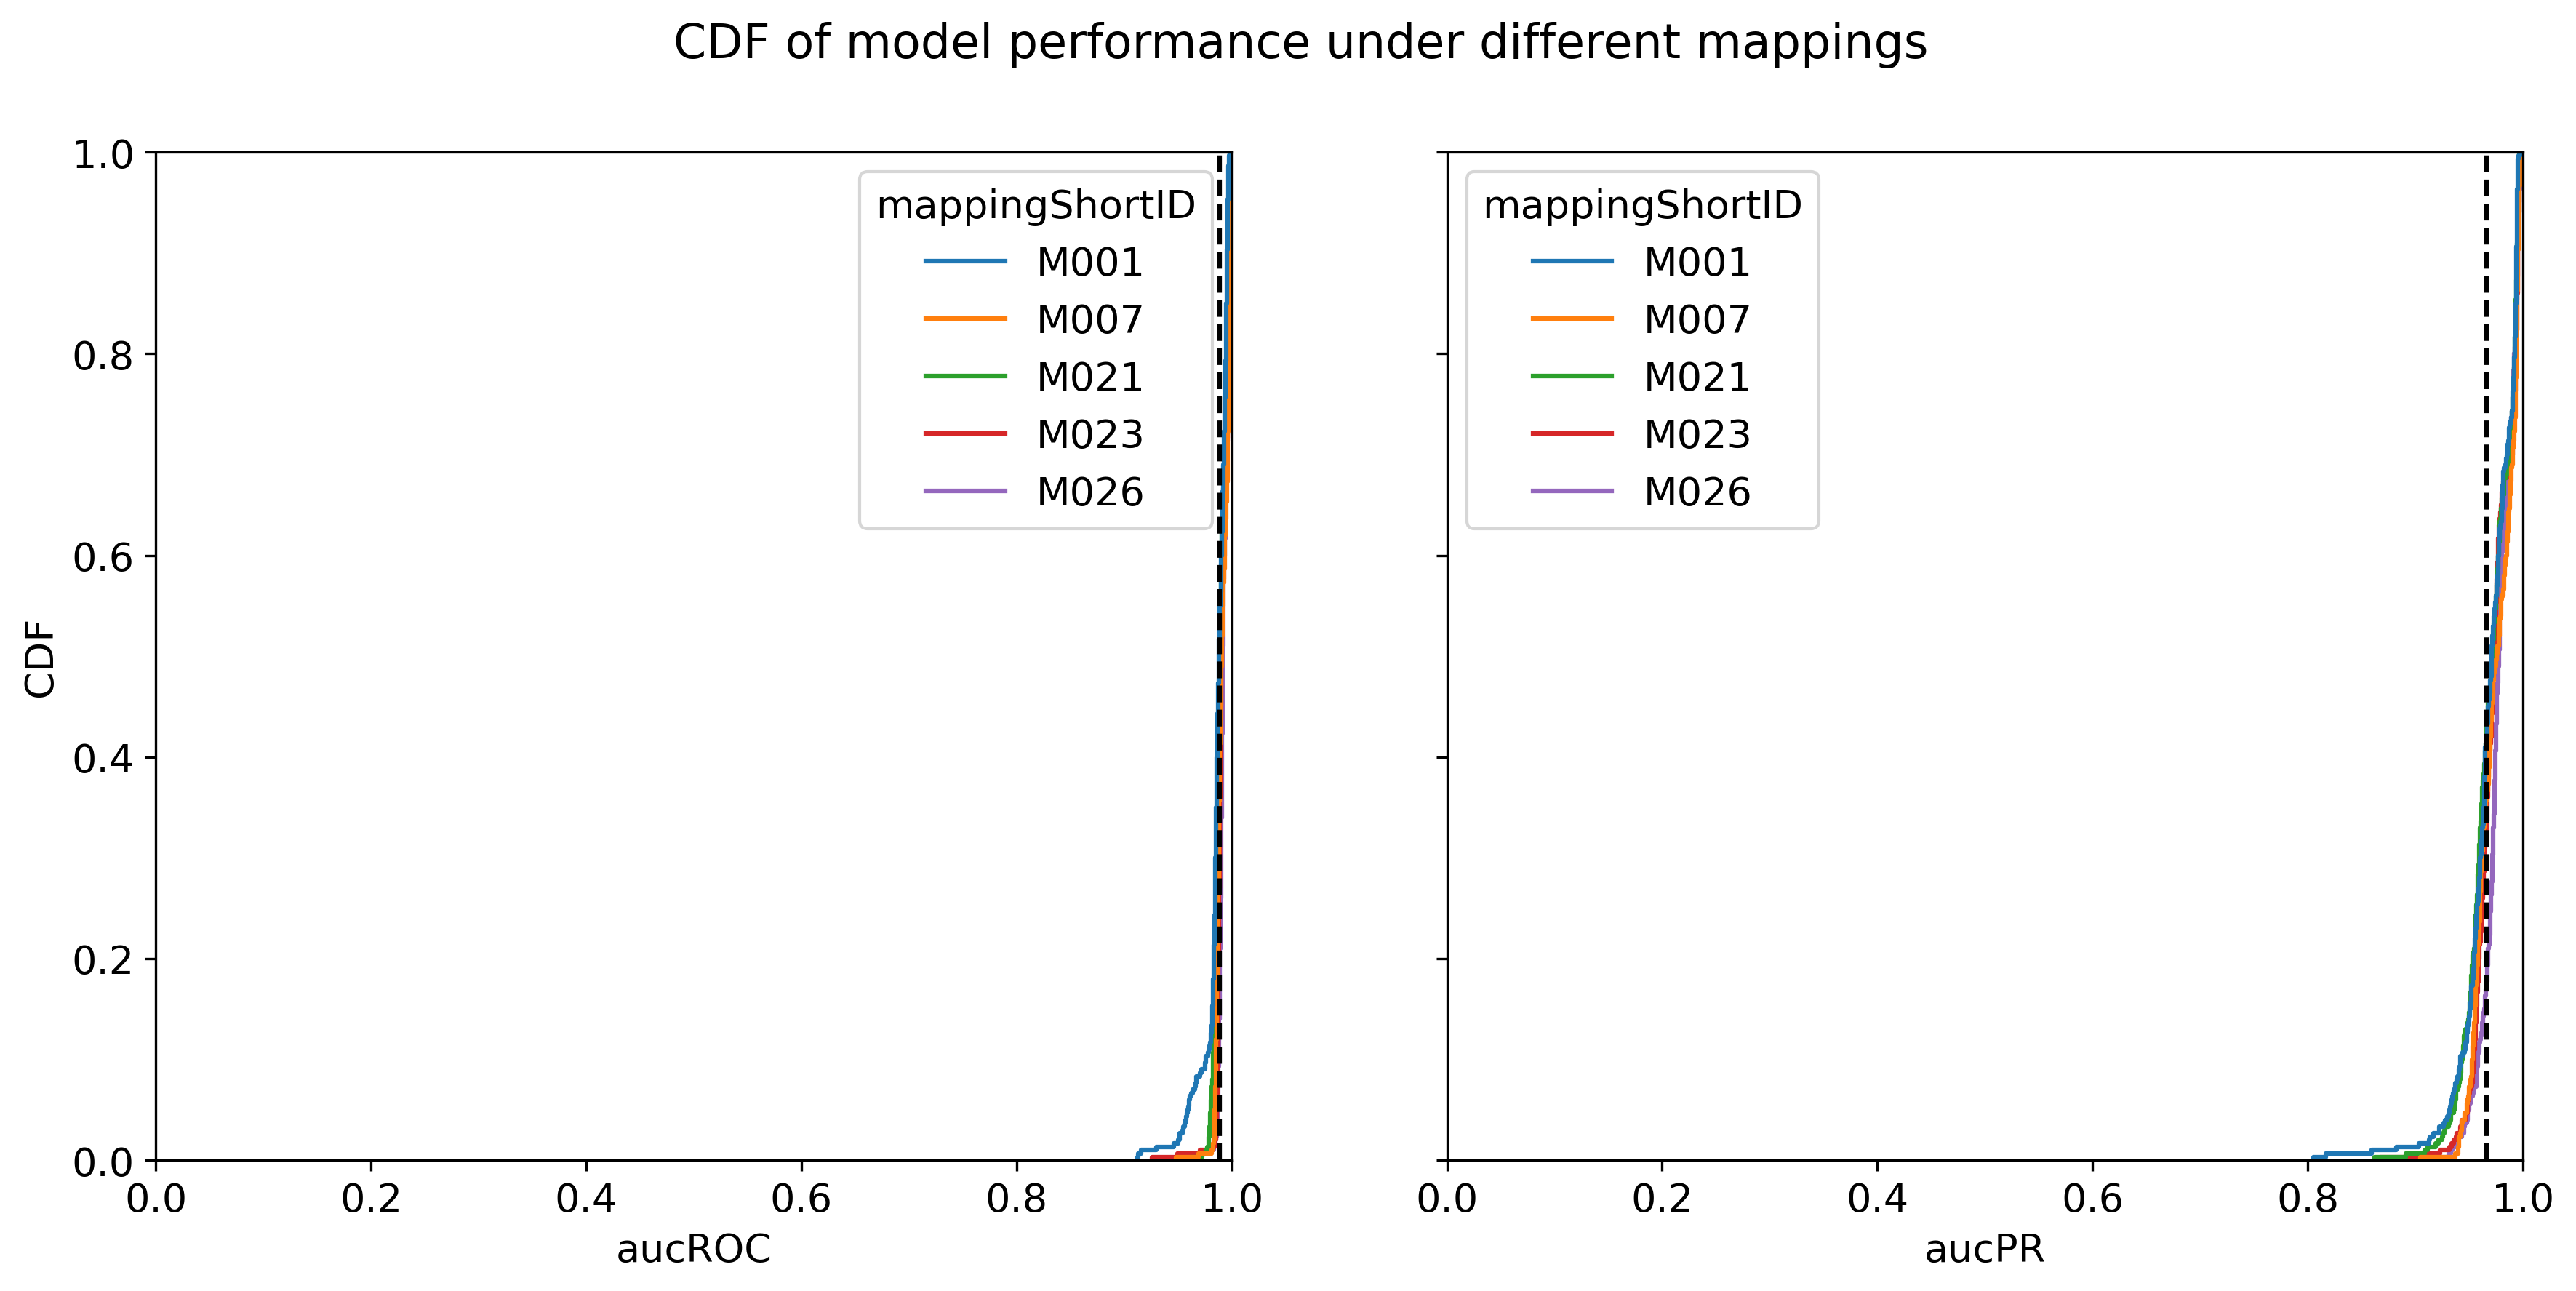

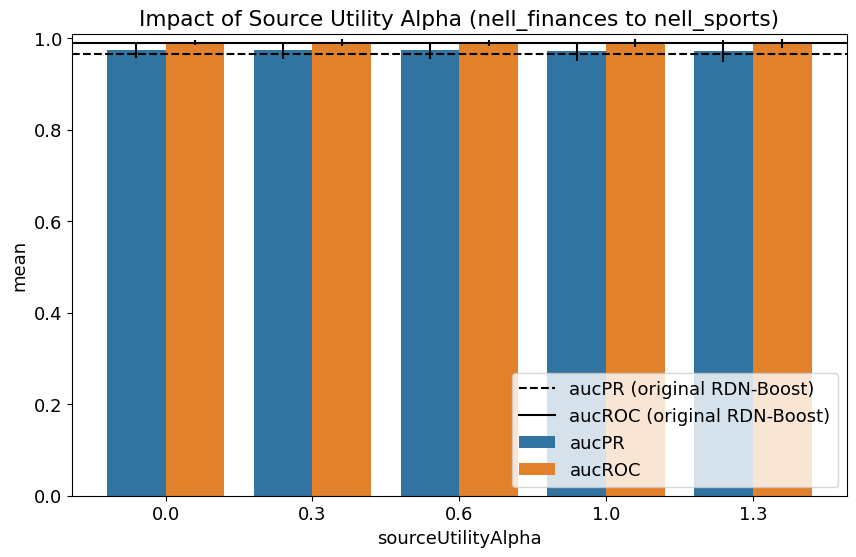

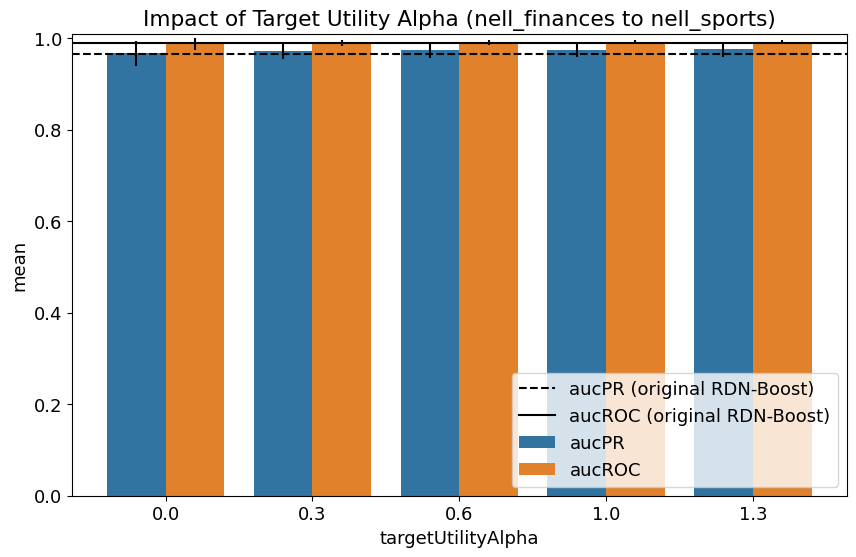

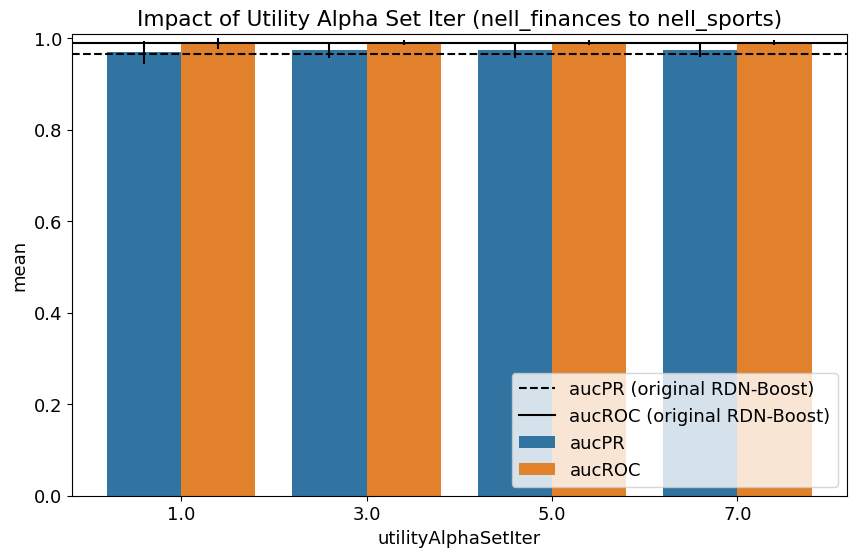

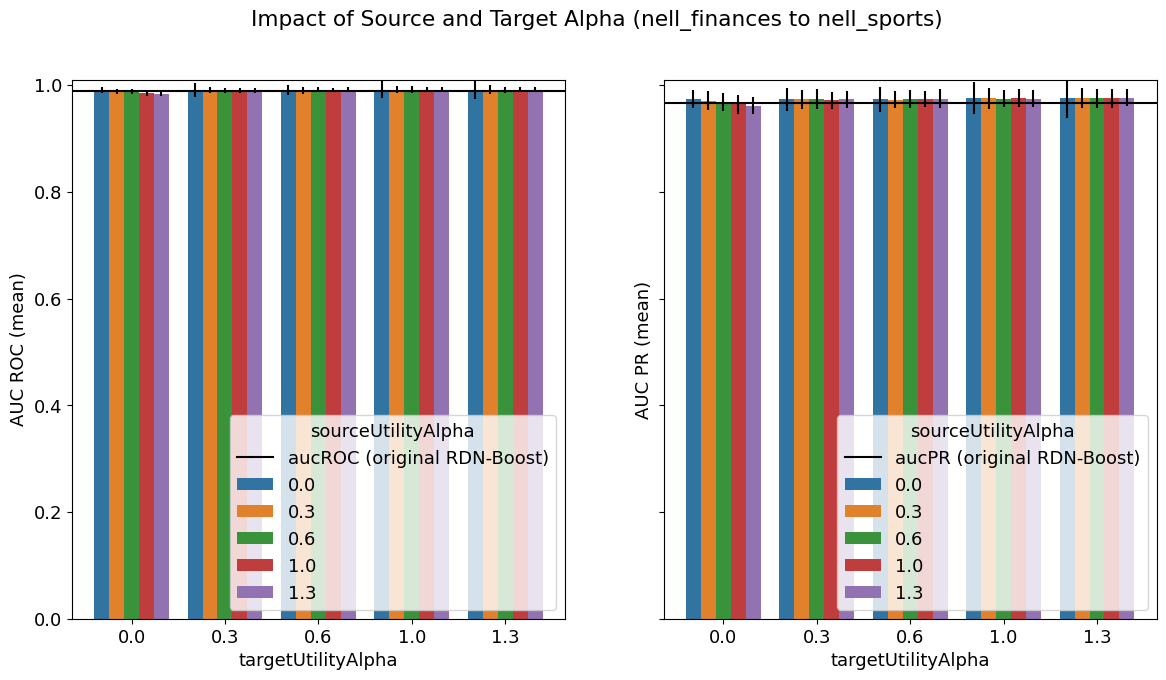

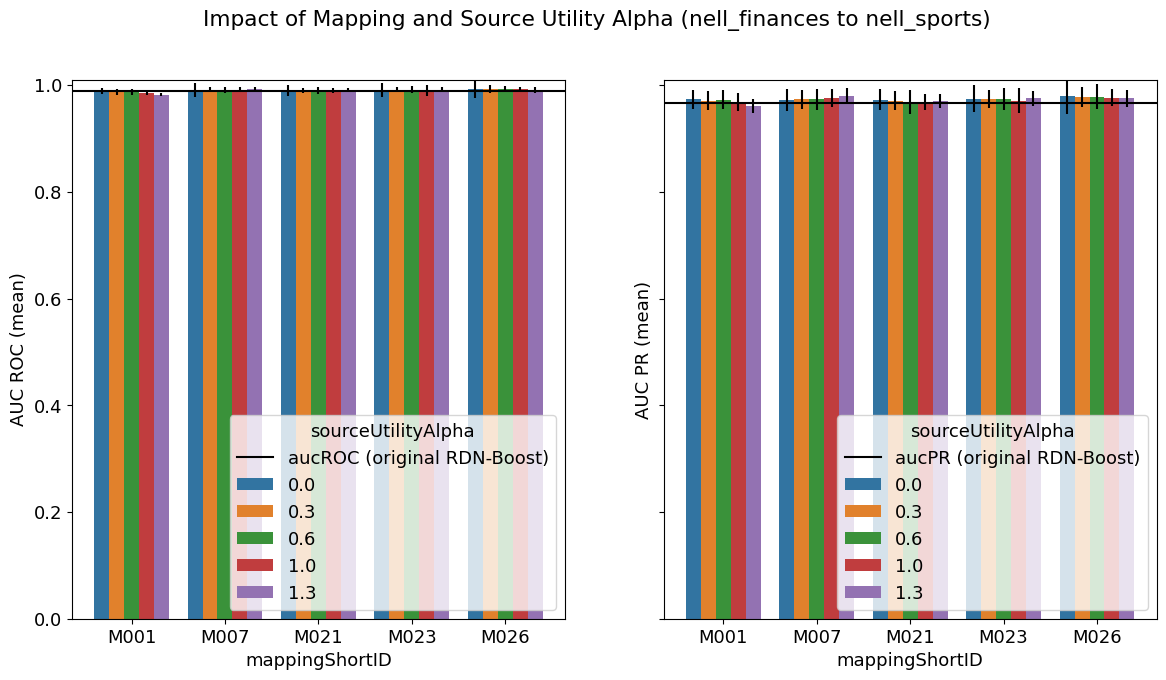

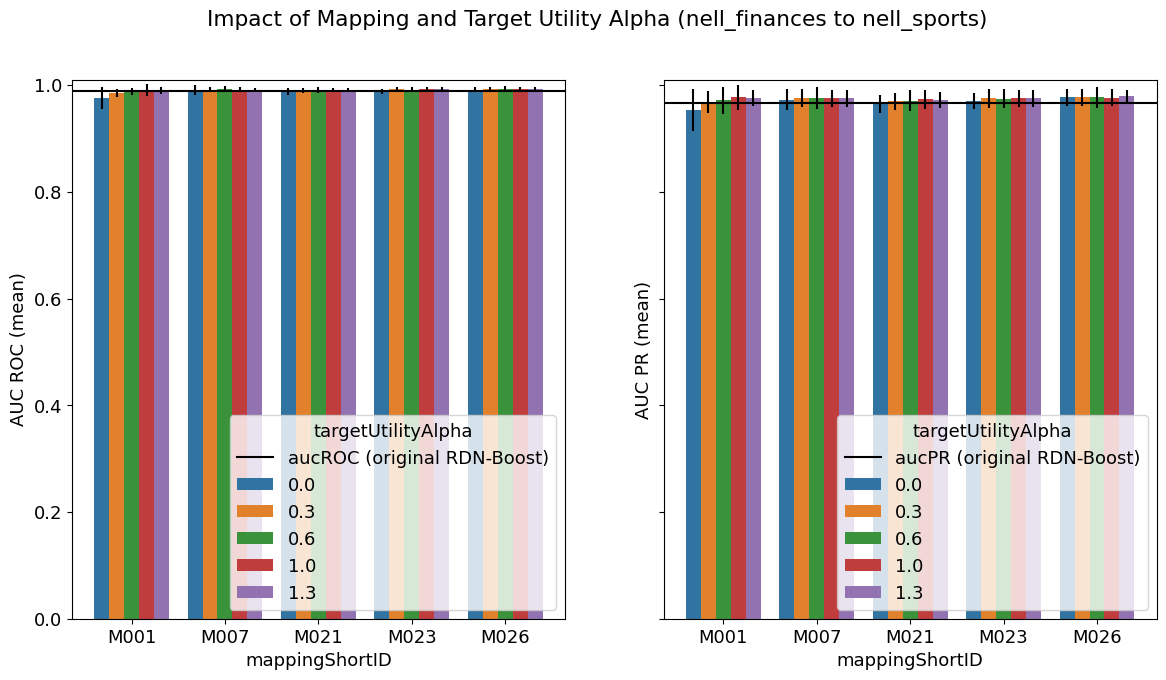

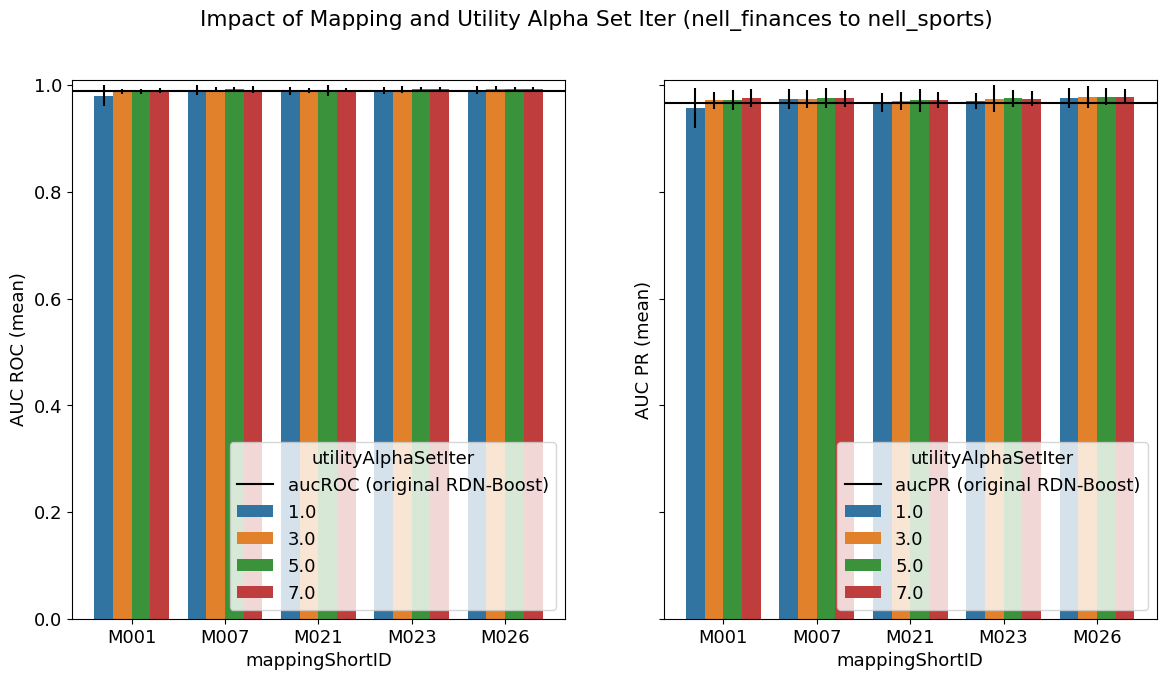

In [228]:
analysisVariables = runAnalysis("nell_finances", "nell_sports")

# **IGNORE**

## **Correlation between mapping and performance**

In [58]:
mappingPerformanceCorrelationDF = pd.merge(
    transferLearningMetricsDF,
    transferLearningDF[[
        "id", "mappingID", "path", "useRecursion", "target_targetPredicate", "negPosRatio", 
        "maxFailedNegSamplingRetries"
    ]],
    how = "left",
    left_on = "experimentID",
    right_on = "id"
)

mappingPerformanceCorrelationDF

experimentID    fold  threshold  \
0      0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...  fold01      0.490   
1      0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...  fold02      0.489   
2      0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...  fold00      0.454   
3      00211469e7d68242b8a5fd2170a8001164382df617e84d...  fold01      0.472   
4      00211469e7d68242b8a5fd2170a8001164382df617e84d...  fold00      0.394   
...                                                  ...     ...        ...   
13495  ffeca254b7b54c256beb8612f85f94167e6dc9fe33306e...  fold02      0.296   
13496  ffeca254b7b54c256beb8612f85f94167e6dc9fe33306e...  fold00      0.168   
13497  ffeca254b7b54c256beb8612f85f94167e6dc9fe33306e...  fold03      0.425   
13498  fff8970844a79335309fa798b007de0aea217de93d7fe5...  fold01      0.518   
13499  fff8970844a79335309fa798b007de0aea217de93d7fe5...  fold00      0.455   

            cll    aucROC     aucPR   prec       rec        f1  \
0     -0.180192  0.984483  0.955207  0.490  0.988506  0.960894   
1     -0.161034  0.993700  0.985012  0.489  0.984791  0.971857   
2     -0.167207  0.995072  0.993580  0.454  0.984733  0.980989   
3     -0.178223  0.993985  0.986539  0.472  0.928571  0.951220   
4     -0.215951  0.990189  0.965564  0.394  0.948718  0.954839   
...         ...       ...       ...    ...       ...       ...   
13495 -0.695664  0.606329  0.537986  0.296  0.155235  0.267081   
13496 -0.717882  0.616053  0.560562  0.168  0.234043  0.378223   
13497 -0.559557  0.937092  0.867791  0.425  0.169611  0.288288   
13498 -0.120577  0.996095  0.990665  0.518  0.992063  0.984252   
13499 -0.170824  0.991566  0.975201  0.455  0.935897  0.948052   

       utility@targetAlpha_0.0  ...  utility@targetAlpha_0.6  \
0                     0.855988  ...                 2.338048   
1                     0.863985  ...                 2.350993   
2                     0.854949  ...                 2.343022   
3                     0.862913  ...                 2.342529   
4                     0.823702  ...                 2.302601   
...                        ...  ...                      ...   
13495                 0.660246  ...                 2.001504   
13496                 0.660338  ...                 1.993785   
13497                 0.682737  ...                 2.066736   
13498                 0.895645  ...                 2.387270   
13499                 0.868566  ...                 2.349237   

       utility@targetAlpha_1.0  utility@targetAlpha_1.3  \
0                    -0.180192                -3.533254   
1                    -0.161034                -3.506343   
2                    -0.167207                -3.510198   
3                    -0.178223                -3.533526   
4                    -0.215951                -3.566741   
...                        ...                      ...   
13495                -0.695664                -4.268596   
13496                -0.717882                -4.313770   
13497                -0.559557                -4.030456   
13498                -0.120577                -3.461832   
13499                -0.170824                -3.525794   

                                                      id  \
0      0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...   
1      0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...   
2      0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6...   
3      00211469e7d68242b8a5fd2170a8001164382df617e84d...   
4      00211469e7d68242b8a5fd2170a8001164382df617e84d...   
...                                                  ...   
13495  ffeca254b7b54c256beb8612f85f94167e6dc9fe33306e...   
13496  ffeca254b7b54c256beb8612f85f94167e6dc9fe33306e...   
13497  ffeca254b7b54c256beb8612f85f94167e6dc9fe33306e...   
13498  fff8970844a79335309fa798b007de0aea217de93d7fe5...   
13499  fff8970844a79335309fa798b007de0aea217de93d7fe5...   

                                               mappingID  \
0      77d1b001c655f10d6af95f3425c9f67c7900

In [68]:
glob("./experiments/crossValidation/*")

['./experiments/crossValidation/0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6fc661145e67a637b6b',
 './experiments/crossValidation/00211469e7d68242b8a5fd2170a8001164382df617e84d873826d0ccc2c0bf5d',
 './experiments/crossValidation/00479b54d3e9c1a180fbdc3ee8a06a209072013989ed7b325777542c9e9c4631',
 './experiments/crossValidation/0070725a0f9099c6ed18bb53dcd586dc2f136ec52278878a8f9c8dbe7fe42523',
 './experiments/crossValidation/0072021f3a3021dd72df84a3b940a7c4f306d297989a25467e5c9728f2aa5570',
 './experiments/crossValidation/008ff1c674d11176bbc007ec7f19a2b9de339753b854fa98473f79cbfcd43d1b',
 './experiments/crossValidation/00918aed67e1679d218d149edb62311299e66d09c29080b0d9eb2281f605b6ef',
 './experiments/crossValidation/00a523792515d1e2fbd637020ff45063fbb169eb721e5e334d9f990beafe503e',
 './experiments/crossValidation/00b5357f4a9e3f62435ed69693ca64cf503a7af61401504f7d3cb4b1edc97010',
 './experiments/crossValidation/00b96cec83cfeafe60150b99992431689fe40b3e2a15c8435140495d643b4b20',
 './experi

In [61]:
from utils.experiment import getLogger, loadDatabase
logger = getLogger("Database loader")

experimentData = mappingPerformanceCorrelationDF.iloc[0]
yeast = loadDatabase(
    path = f"{experimentData.path}/{experimentData.id}",
    folds = [experimentData.fold],
    useRecursion = experimentData.useRecursion,
    targetPredicate = experimentData.target_targetPredicate,
    resetTargetPredicate = False, 
    negPosRatio = experimentData.negPosRatio,
    maxFailedNegSamplingRetries = experimentData.maxFailedNegSamplingRetries,
    logger = logger
)

FileNotFoundError: [Errno 2] No such file or directory: './experiments/crossValidation/0000254d5b45d6daeaac1ba8c7a5e949c799776eba9bf6fc661145e67a637b6b/fold01/pos.pl'